In [1]:
import sklearn
import gc
import numpy as np
import matplotlib
#import fancyimpute
import random
import os
import pickle
import pandas as pd
from pandas import DataFrame as df
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import KFold, cross_val_score, train_test_split, StratifiedKFold
import matplotlib.pylab as plt
import scipy
import seaborn as sns
import xgboost as xgb
from tqdm import tqdm, trange
import utils
import scoring
color = sns.color_palette()
sns.set_style('darkgrid')
#from feature_selector import FeatureSelector
from sklearn.model_selection import train_test_split
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
import lightgbm as lgbm
from IPython.core.display import display, HTML
import sys
sys.path.insert(0, '/home/livington/facets/facets_overview/python/')
import base64
from generic_feature_statistics_generator import GenericFeatureStatisticsGenerator
gfsg = GenericFeatureStatisticsGenerator()


RANDOM_STATE=42

dtypes = {
    'ncl[0]': 'int16',
'ncl[1]': 'int16',
'ncl[2]': 'int8',
'ncl[3]': 'int8',
'avg_cs[0]': 'float32',
'avg_cs[1]': 'float32',
'avg_cs[2]': 'float32',
'avg_cs[3]': 'float32',
'ndof': 'int8',
'MatchedHit_TYPE[0]': 'int8',
'MatchedHit_TYPE[1]': 'int8',
'MatchedHit_TYPE[2]': 'int8',
'MatchedHit_TYPE[3]': 'int8',
'MatchedHit_X[0]': 'float16',
'MatchedHit_X[1]': 'float16',
'MatchedHit_X[2]': 'float16',
'MatchedHit_X[3]': 'float16',
'MatchedHit_Y[0]': 'float16',
'MatchedHit_Y[1]': 'float16',
'MatchedHit_Y[2]': 'float16',
'MatchedHit_Y[3]': 'float16',
'MatchedHit_Z[0]': 'float16',
'MatchedHit_Z[1]': 'float16',
'MatchedHit_Z[2]': 'float16',
'MatchedHit_Z[3]': 'float16',
'MatchedHit_DX[0]': 'float16',
'MatchedHit_DX[1]': 'float16',
'MatchedHit_DX[2]': 'float16',
'MatchedHit_DX[3]': 'float16',
'MatchedHit_DY[0]': 'float16',
'MatchedHit_DY[1]': 'float16',
'MatchedHit_DY[2]': 'float16',
'MatchedHit_DY[3]': 'float16',
'MatchedHit_DZ[0]': 'float16',
'MatchedHit_DZ[1]': 'float16',
'MatchedHit_DZ[2]': 'float16',
'MatchedHit_DZ[3]': 'float16',
'MatchedHit_T[0]': 'int8',
'MatchedHit_T[1]': 'int8',
'MatchedHit_T[2]': 'int16',
'MatchedHit_T[3]': 'int16',
'MatchedHit_DT[0]': 'int8',
'MatchedHit_DT[1]': 'int8',
'MatchedHit_DT[2]': 'int8',
'MatchedHit_DT[3]': 'int8',
'Lextra_X[0]': 'float16',
'Lextra_X[1]': 'float16',
'Lextra_X[2]': 'float16',
'Lextra_X[3]': 'float16',
'Lextra_Y[0]': 'float16',
'Lextra_Y[1]': 'float16',
'Lextra_Y[2]': 'float16',
'Lextra_Y[3]': 'float16',
'NShared': 'int8',
'Mextra_DX2[0]': 'float16',
'Mextra_DX2[1]': 'float32',
'Mextra_DX2[2]': 'float32',
'Mextra_DX2[3]': 'float32',
'Mextra_DY2[0]': 'float16',
'Mextra_DY2[1]': 'float32',
'Mextra_DY2[2]': 'float32',
'Mextra_DY2[3]': 'float32',
'FOI_hits_N': 'int16',
'PT': 'float32',
'P': 'float32'
}

DIST_COLUMNS = [
    'Matched_dist[0]',
    'Matched_dist[1]',
    'Matched_dist[2]',
    'Matched_dist[3]'
]

DIST_LEXTRA_COLUMNS = [
'Lextra_dist[0]',
'Lextra_dist[1]',
'Lextra_dist[2]',
'Lextra_dist[3]'
]

SCALAR_MUL_LEXTRA_COLUMNS = [
'Lextra_scalar_mul[01]',
'Lextra_scalar_mul[02]',
'Lextra_scalar_mul[03]',
'Lextra_scalar_mul[12]',
'Lextra_scalar_mul[13]',
'Lextra_scalar_mul[23]'
]

DIV_LEXTRA_COLUMNS = [
'Lextra_div_X[01]',
'Lextra_div_X[02]',
'Lextra_div_X[03]',
'Lextra_div_X[12]',
'Lextra_div_X[13]',
'Lextra_div_X[23]',
'Lextra_div_Y[01]',
'Lextra_div_Y[02]',
'Lextra_div_Y[03]',
'Lextra_div_Y[12]',
'Lextra_div_Y[13]',
'Lextra_div_Y[23]',
'Lextra_dist[01]' ,
'Lextra_dist[02]' ,
'Lextra_dist[03]' ,
'Lextra_dist[12]' ,
'Lextra_dist[13]' ,
'Lextra_dist[23]'  
]

KILLER_FEATURES = [
    'Matched_dist[0]', 
    'Lextra_dist[03]'
]

CATEGORICAL_FEATURES = [
    'MatchedHit_TYPE[1]',
    'MatchedHit_TYPE[2]',
    'MatchedHit_TYPE[3]'
]

LEXTRA_MATCHED = [
'LextraMatched_X[2]',
'LextraMatched_Y[2]',
'LextraMatched_X[3]',
'LextraMatched_Y[3]',
'LextraMatched_X[4]',
'LextraMatched_Y[4]',
'LextraMatched_X[1]',
'LextraMatched_Y[1]'
]

HEIZE_MATCH = [ 
'Heize_math_X[0]',
'Heize_math_Y[0]',
'Heize_math_Z[0]',
'Heize_math_X[1]',
'Heize_math_Y[1]',
'Heize_math_Z[1]',
'Heize_math_X[2]',
'Heize_math_Y[2]',
'Heize_math_Z[2]',
'Heize_math_X[3]',
'Heize_math_Y[3]',
'Heize_math_Z[3]'
]

NSHARED_HIT = [
'nshared_x_per_station ',
'nshared_y_per_station ',
'nshared_T_per_station ',
'nshared_z_per_station ',
'nshared_dx_per_station',
'nshared_dy_per_station'
]

CLOSEST_HITS = [str(i) for i in range(24)]

X, Y, WEIGHT = None, None, None
COLUMNS = []

DATA_PATH = "./data"

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
def find_closest_hit_per_station_csv(row):
    """
        A function generates 'FOI' features, applys to dataframe, to each row
    """
    result = np.empty(utils.N_FOI_FEATURES, dtype=np.float32)
    closest_x_per_station = result[0:4]
    closest_y_per_station = result[4:8]
    closest_T_per_station = result[8:12]
    closest_z_per_station = result[12:16]
    closest_dx_per_station = result[16:20]
    closest_dy_per_station = result[20:24]
    
    FOI_hits_X = pd.Series([float(i) for i in row["FOI_hits_X"].split('[')[1].split(']')[0].split()])
    FOI_hits_Y = pd.Series([float(i) for i in row["FOI_hits_Y"].split('[')[1].split(']')[0].split()])
    FOI_hits_S_arr = [int(i) for i in row["FOI_hits_S"].split('[')[1].split(']')[0].split()]
    FOI_hits_T  = pd.Series([int(i) for i in row["FOI_hits_T"].split('[')[1].split(']')[0].split()])
    FOI_hits_Z  = pd.Series([float(i) for i in row["FOI_hits_Z"].split('[')[1].split(']')[0].split()])
    FOI_hits_DX = pd.Series([float(i) for i in row["FOI_hits_DX"].split('[')[1].split(']')[0].split()])
    FOI_hits_DY = pd.Series([float(i) for i in row["FOI_hits_DY"].split('[')[1].split(']')[0].split()])
    #print(row['id'])
    for station in range(4):
        #print([int(i) for i in row["FOI_hits_S"].split('[')[1].split(']')[0].split()])
        
        #print(FOI_hits_S_arr, station)
        #hits = [int(i) for i in row["FOI_hits_S"].split('[')[1].split(']')[0].split()] == station
        hits = [station == i for i in FOI_hits_S_arr]
        #print(hits)
        if not any(hits):#hits.any():
            closest_x_per_station[station] =  utils.EMPTY_FILLER
            closest_y_per_station[station] =  utils.EMPTY_FILLER
            closest_T_per_station[station] =  utils.EMPTY_FILLER
            closest_z_per_station[station] =  utils.EMPTY_FILLER
            closest_dx_per_station[station] = utils.EMPTY_FILLER
            closest_dy_per_station[station] = utils.EMPTY_FILLER
        else:

            #print(FOI_hits_X)
            x_distances_2 = (row["Lextra_X[%i]" % station] - FOI_hits_X[hits])**2
            y_distances_2 = (row["Lextra_Y[%i]" % station] - FOI_hits_Y[hits])**2
            distances_2 = x_distances_2 + y_distances_2
            closest_hit = np.argmin(distances_2)
            #print(closest_hit)
            #print(x_distances_2, closest_hit, x_distances_2[closest_hit])
            #print(station, x_distances_2[closest_hit])
            closest_x_per_station[station] = x_distances_2[closest_hit]
            closest_y_per_station[station] = y_distances_2[closest_hit]
            
            closest_T_per_station[station] =  FOI_hits_T [hits][closest_hit]
            closest_z_per_station[station] =  FOI_hits_Z [hits][closest_hit]
            closest_dx_per_station[station] = FOI_hits_DX[hits][closest_hit]
            closest_dy_per_station[station] = FOI_hits_DY[hits][closest_hit]
    return result

In [4]:
from sklearn.model_selection import KFold

def cros_val_rej90score(model, df, columns=utils.SIMPLE_FEATURE_COLUMNS, cv=2, skip_outliers=False, th=3):
    chunk_size = len(df)//cv
    val_scores = []
    train_scores = []
    kf = KFold(n_splits=cv)
    kf.get_n_splits(df)
    
    for train_index, test_index in kf.split(df):          
        train_part, validation = df.loc[train_index], df.loc[test_index]
        if skip_outliers:
            train_part = get_rid_of_outliers(train_part, th=th)
        
        abs_weights = np.abs(train_part.weight)
        model.fit(train_part.loc[:, columns],
              train_part.label,
              sample_weight=abs_weights.values)#,
              #categorical_feature=CATEGORICAL_FEATURES)
        gc.collect()
        
        validation_predictions = model.predict_proba(validation.loc[:, columns].values)[:, 1]
        train_part_prediction = model.predict_proba(train_part.loc[:, columns].values)[:, 1]
        
        val_score = scoring.rejection90(validation.label.values, validation_predictions, sample_weight=validation.weight.values)
        train_score = scoring.rejection90(train_part.label.values, train_part_prediction, sample_weight=train_part.weight.values)
        
        val_scores.append(val_score)
        train_scores.append(train_score)
        
        del train_part
        del validation
        gc.collect()
        
    return np.mean(train_scores), np.mean(val_scores)

In [5]:
#working with outliers
from scipy import stats

def get_rid_of_outliers(df, th=3):
    z = np.abs(stats.zscore(df.loc[:, utils.SIMPLE_FEATURE_COLUMNS]))
    return df[(z < th).all(axis=1)]

In [6]:
def get_distance_match(df):
    ddf = pd.DataFrame()
    ddf['Matched_dist[0]'] = np.sqrt(df['MatchedHit_X[0]'].astype('float32')**2 + df['MatchedHit_Y[0]'].astype('float32')**2 + df['MatchedHit_Z[0]'].astype('float32')**2)
    ddf['Matched_dist[1]'] = np.sqrt(df['MatchedHit_X[1]'].astype('float32')**2 + df['MatchedHit_Y[1]'].astype('float32')**2 + df['MatchedHit_Z[1]'].astype('float32')**2)
    ddf['Matched_dist[2]'] = np.sqrt(df['MatchedHit_X[2]'].astype('float32')**2 + df['MatchedHit_Y[2]'].astype('float32')**2 + df['MatchedHit_Z[2]'].astype('float32')**2)
    ddf['Matched_dist[3]'] = np.sqrt(df['MatchedHit_X[3]'].astype('float32')**2 + df['MatchedHit_Y[3]'].astype('float32')**2 + df['MatchedHit_Z[3]'].astype('float32')**2)
    
    return ddf

In [7]:
def get_distance_lextra(df):
    ddf = pd.DataFrame()
    ddf['Lextra_dist[0]'] = np.sqrt(df['Lextra_X[0]'].astype('float32')**2 + df['Lextra_Y[0]'].astype('float32')**2)
    ddf['Lextra_dist[1]'] = np.sqrt(df['Lextra_X[1]'].astype('float32')**2 + df['Lextra_Y[1]'].astype('float32')**2)
    ddf['Lextra_dist[2]'] = np.sqrt(df['Lextra_X[2]'].astype('float32')**2 + df['Lextra_Y[2]'].astype('float32')**2)
    ddf['Lextra_dist[3]'] = np.sqrt(df['Lextra_X[3]'].astype('float32')**2 + df['Lextra_Y[3]'].astype('float32')**2)
    
    return ddf

In [8]:
def get_scalar_mul_lextra(df):
    ddf = pd.DataFrame()
    ddf['Lextra_scalar_mul[01]'] = np.sqrt(df['Lextra_X[0]'].astype('float32')*df['Lextra_X[1]'].astype('float32') + df['Lextra_Y[0]'].astype('float32')*df['Lextra_Y[1]'].astype('float32'))
    ddf['Lextra_scalar_mul[02]'] = np.sqrt(df['Lextra_X[0]'].astype('float32')*df['Lextra_X[2]'].astype('float32') + df['Lextra_Y[0]'].astype('float32')*df['Lextra_Y[2]'].astype('float32'))
    ddf['Lextra_scalar_mul[03]'] = np.sqrt(df['Lextra_X[0]'].astype('float32')*df['Lextra_X[3]'].astype('float32') + df['Lextra_Y[0]'].astype('float32')*df['Lextra_Y[3]'].astype('float32'))    
    ddf['Lextra_scalar_mul[12]'] = np.sqrt(df['Lextra_X[1]'].astype('float32')*df['Lextra_X[2]'].astype('float32') + df['Lextra_Y[1]'].astype('float32')*df['Lextra_Y[2]'].astype('float32'))
    ddf['Lextra_scalar_mul[13]'] = np.sqrt(df['Lextra_X[1]'].astype('float32')*df['Lextra_X[3]'].astype('float32') + df['Lextra_Y[1]'].astype('float32')*df['Lextra_Y[3]'].astype('float32'))    
    ddf['Lextra_scalar_mul[23]'] = np.sqrt(df['Lextra_X[2]'].astype('float32')*df['Lextra_X[3]'].astype('float32') + df['Lextra_Y[2]'].astype('float32')*df['Lextra_Y[3]'].astype('float32'))
    
    return ddf

In [9]:
def get_div_lextra(df):
    ddf = pd.DataFrame()
    ddf['Lextra_div_X[01]'] = df['Lextra_X[0]'].astype('float32')-df['Lextra_X[1]'].astype('float32')
    ddf['Lextra_div_X[02]'] = df['Lextra_X[0]'].astype('float32')-df['Lextra_X[2]'].astype('float32')
    ddf['Lextra_div_X[03]'] = df['Lextra_X[0]'].astype('float32')-df['Lextra_X[3]'].astype('float32')    
    ddf['Lextra_div_X[12]'] = df['Lextra_X[1]'].astype('float32')-df['Lextra_X[2]'].astype('float32')
    ddf['Lextra_div_X[13]'] = df['Lextra_X[1]'].astype('float32')-df['Lextra_X[3]'].astype('float32')    
    ddf['Lextra_div_X[23]'] = df['Lextra_X[2]'].astype('float32')-df['Lextra_X[3]'].astype('float32')    
    ddf['Lextra_div_Y[01]'] = df['Lextra_Y[0]'].astype('float32')-df['Lextra_Y[1]'].astype('float32')
    ddf['Lextra_div_Y[02]'] = df['Lextra_Y[0]'].astype('float32')-df['Lextra_Y[2]'].astype('float32')
    ddf['Lextra_div_Y[03]'] = df['Lextra_Y[0]'].astype('float32')-df['Lextra_Y[3]'].astype('float32')    
    ddf['Lextra_div_Y[12]'] = df['Lextra_Y[1]'].astype('float32')-df['Lextra_Y[2]'].astype('float32')
    ddf['Lextra_div_Y[13]'] = df['Lextra_Y[1]'].astype('float32')-df['Lextra_Y[3]'].astype('float32')    
    ddf['Lextra_div_Y[23]'] = df['Lextra_Y[2]'].astype('float32')-df['Lextra_Y[3]'].astype('float32')    
    ddf['Lextra_dist[01]' ] = np.sqrt(ddf['Lextra_div_X[01]'].astype('float32')**2 + ddf['Lextra_div_Y[01]'].astype('float32')**2)
    ddf['Lextra_dist[02]' ] = np.sqrt(ddf['Lextra_div_X[02]'].astype('float32')**2 + ddf['Lextra_div_Y[02]'].astype('float32')**2) 
    ddf['Lextra_dist[03]' ] = np.sqrt(ddf['Lextra_div_X[03]'].astype('float32')**2 + ddf['Lextra_div_Y[03]'].astype('float32')**2)
    ddf['Lextra_dist[12]' ] = np.sqrt(ddf['Lextra_div_X[12]'].astype('float32')**2 + ddf['Lextra_div_Y[12]'].astype('float32')**2)
    ddf['Lextra_dist[13]' ] = np.sqrt(ddf['Lextra_div_X[13]'].astype('float32')**2 + ddf['Lextra_div_Y[13]'].astype('float32')**2)
    ddf['Lextra_dist[23]' ] = np.sqrt(ddf['Lextra_div_X[23]'].astype('float32')**2 + ddf['Lextra_div_Y[23]'].astype('float32')**2)
    
    return ddf

In [10]:
#['Matched_dist[0]', 'Lextra_dist[03]']
def get_killer_features(df):
    """
        A function return dataframe with features were generated by original dataframe and have importance
    """
    ddf = pd.DataFrame()
    ddf['Matched_dist[0]'] = np.sqrt(df['MatchedHit_X[0]'].astype('float32')**2 + df['MatchedHit_Y[0]'].astype('float32')**2 + df['MatchedHit_Z[0]'].astype('float32')**2)
    
    ddf['Lextra_div_X[03]'] = df['Lextra_X[0]'].astype('float32')-df['Lextra_X[3]'].astype('float32')   
    ddf['Lextra_div_Y[03]'] = df['Lextra_Y[0]'].astype('float32')-df['Lextra_Y[3]'].astype('float32')    
    ddf['Lextra_dist[03]' ] = np.sqrt(ddf['Lextra_div_X[03]'].astype('float32')**2 + ddf['Lextra_div_Y[03]'].astype('float32')**2)
    
    ddf.pop('Lextra_div_X[03]')
    ddf.pop('Lextra_div_Y[03]')
    
    return ddf

In [48]:
def get_n_sav_prediction(model, train_df, test_df, columns=utils.SIMPLE_FEATURE_COLUMNS, num_sb=1, stacking=False):
    """
        A function saves prediction. A model will fits. 
    """
    print('training...')
    if not stacking:
        model.fit(train_df.loc[:, columns].values, train_df.label, sample_weight=np.abs(train_df.weight))
    else:
        model.fit(train_df, train_df.label)
    gc.collect()
    num_res = num_sb
    print('predicting')
    predictions = model.predict_proba(test_df.loc[:, columns].values)[:, 1]
    predictions = predictions.astype('float32')
    pd.DataFrame(data={"prediction": predictions}, index=test_df.index).to_csv(
        "sub_{0}.csv".format(num_res), index_label=utils.ID_COLUMN)
    print('saving is done')

In [41]:
def get_n_sav_prediction_station(model, train_df, test_df, columns=utils.SIMPLE_FEATURE_COLUMNS, num_sb=1, stacking=False):
    """
        A function saves prediction. A model will fits. 
    """
    predictions = np.zeros(len(test_df))
    for station_columns in [ST1_COLUMNS, ST2_COLUMNS, ST3_COLUMNS, ST4_COLUMNS]:
        print('training...')
        if not stacking:
            model.fit(train_df.loc[:, station_columns].values, train_df.label, sample_weight=np.abs(train_df.weight))
        else:
            log_reg = LogisticRegression(C=0.765)
            columns = station_columns
            model = StackingAveragedModels(base_models = (lgb, cat_boost),
                                                 columns=station_columns,
                                                 meta_model = log_reg)
            model.fit(train_df, train_df.label)
        gc.collect()
        num_res = num_sb
        print('predicting')
        predictions += model.predict_proba(test_df.loc[:, station_columns].values)[:, 1]
    predictions /= 4
    predictions = predictions.astype('float32')
    pd.DataFrame(data={"prediction": predictions}, index=test_df.index).to_csv(
        "sub_station_{0}.csv".format(num_res), index_label=utils.ID_COLUMN)
    print('saving is done')

# Load train and test, including hits features

In [13]:
#%%time
#chf_train = pd.concat([pd.read_csv('./data/chf_train1.csv'), pd.read_csv('./data/chf_train2.csv')])
#chf_train.index = range(len(chf_train))
#chf_train.to_csv('./data/chf_train_all.csv', index=False)

In [14]:
train, test, test_pr = utils.load_data_csv(DATA_PATH, utils.SIMPLE_FEATURE_COLUMNS)
train = pd.concat([train, pd.read_csv('./data/chf_train_all.csv', usecols=[str(i) for i in range(24)])], axis=1)
test = pd.concat([test, pd.read_csv('./data/chf_test.csv', usecols=[str(i) for i in range(24)])], axis=1)
test_pr = pd.concat([test_pr, pd.read_csv('./data/chf_test_private.csv', usecols=[str(i) for i in range(24)])], axis=1)

test['tg11'] = (test['1'] - test['0'])/15270
test_pr['tg11'] = (test_pr['1'] - test_pr['0'])/15270
train['tg11'] = (train['1'] - train['0'])/15270

gc.collect()
train.head()

/home/livington/.local/lib/python3.5/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,ncl[0],ncl[1],ncl[2],ncl[3],avg_cs[0],avg_cs[1],avg_cs[2],avg_cs[3],ndof,MatchedHit_TYPE[0],...,15,16,17,18,19,20,21,22,23,tg11
0,47,31,13,15,2.000000,1.580645,1.153846,1.133333,8,2,...,18729.324,25.500000,27.50,118.0,126.0,126.278550,136.278490,146.278410,156.27835,0.061498
1,92,19,11,26,2.750000,2.789474,1.363636,1.230769,8,2,...,18824.430,25.500000,27.50,118.0,756.0,126.278550,136.278490,146.278410,156.27835,-0.038880
2,100,21,11,12,2.930000,2.428571,1.181818,1.083333,8,2,...,18806.352,12.750000,13.75,59.0,63.0,63.078957,68.078926,73.078896,78.07886,-0.000802
3,74,27,13,20,3.067568,2.518518,1.923077,1.300000,8,2,...,18806.352,12.948485,13.75,59.0,63.0,63.038590,68.078926,73.078896,78.07886,0.018223
4,18,22,8,8,1.833333,1.954545,1.125000,1.750000,8,2,...,18811.395,12.750000,13.75,59.0,63.0,63.078957,68.078926,73.078896,78.07886,-0.001610


In [15]:
ST1_COLUMNS = [col for col in train.columns[:64] if col[-2] == '0'] + [str(i) for i in range(24)] + ['FOI_hits_N','NShared', 'ndof', 'PT', 'P']
ST2_COLUMNS = [col for col in train.columns[:64] if col[-2] == '1'] + [str(i) for i in range(24)]+ ['FOI_hits_N' ,'NShared', 'ndof', 'PT', 'P']
ST3_COLUMNS = [col for col in train.columns[:64] if col[-2] == '2'] + [str(i) for i in range(24)] + ['FOI_hits_N','NShared', 'ndof', 'PT', 'P']
ST4_COLUMNS = [col for col in train.columns[:64] if col[-2] == '3'] + [str(i) for i in range(24)] + ['FOI_hits_N','NShared', 'ndof', 'PT', 'P']

In [16]:
proto = gfsg.ProtoFromDataFrames([{'name': 'train', 'table': train[:10000]},
                                  {'name': 'test', 'table': test[:10000]}])
protostr = base64.b64encode(proto.SerializeToString()).decode("utf-8")
HTML_TEMPLATE = """<link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/master/facets-dist/facets-jupyter.html" >
        <facets-overview id="elem"></facets-overview>
        <script>
          document.querySelector("#elem").protoInput = "{protostr}";
        </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)
display(HTML(html))

# Split to train and valid part

In [25]:
train_part, validation = train_test_split(train, test_size=0.25, shuffle=True, random_state=RANDOM_STATE)
train_part.index, validation.index = range(len(train_part)), range(len(validation))
#del train
gc.collect()

10

In [26]:
#del train
#del test
#gc.collect()

# Declare model

In [36]:
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier

param = {'num_leaves': 360,
         'min_data_in_leaf': 60, 
         'objective':'binary',
         'max_depth': -1,
         'learning_rate': 0.1,
         "boosting": "gbdt",
         "feature_fraction": 0.8,
         "bagging_freq": 1,
         "bagging_fraction": 0.8 ,
         "bagging_seed": 11,
         "metric": 'auc',
         "lambda_l1": 0.1,
         "random_state": 133,
         "verbosity": -1}

params = {'min_child_samples': 30,
          'reg_alpha': 0.403,
          'colsample_bytree': 0.927,
          'num_leaves': 70,
          'n_estimators': 270,#270
          'subsample_for_bin': 220000,
          'reg_lambda': 0.155,
          'learning_rate': 0.046}

params_best = {'subsample_for_bin': 180000,
               'n_estimators': 205,#205
               'min_child_samples': 20,
               'reg_lambda': 0.259,
               'learning_rate': 0.060,
               'reg_alpha': 0.107,
               'colsample_bytree': 0.826,
               'num_leaves': 50}#50

params_best2 = {'subsample_for_bin': 160000,
                'n_estimators': 320,
                'min_child_samples': 10,
                'reg_lambda': 0.145,
                'learning_rate': 0.056,
                'reg_alpha': 0.131,
                'colsample_bytree': 0.802,
                'num_leaves': 70}

params_best3 = {'learning_rate': 0.1137,
                'min_child_samples': 19,
                'n_estimators': 100,
                'num_leaves': 52,
                'subsample_for_bin': 198000,
                'colsample_bytree': 0.8561,
                'reg_lambda': 0.1028,
                'reg_alpha': 0.2156}

lgb = LGBMClassifier(num_leaves = params_best3['num_leaves'],
                     n_estimators=params_best3['n_estimators'],
                     learning_rate=params_best3['learning_rate'],
                     objective='binary',
                     feature_fraction=0.8,
                     bagging_freq=1,
                     bagging_fraction=0.8 ,
                     colsample_bytree= params_best3['colsample_bytree'],
                     reg_alpha=params_best3['reg_alpha'],
                     reg_lambda=params_best3['reg_lambda'],
                     subsample_for_bin=params_best3['subsample_for_bin'],
                     min_child_samples=params_best3['min_child_samples'],
                     random_state=RANDOM_STATE)
lgb

LGBMClassifier(bagging_fraction=0.8, bagging_freq=1, boosting_type='gbdt',
        class_weight=None, colsample_bytree=0.8561, feature_fraction=0.8,
        importance_type='split', learning_rate=0.1137, max_depth=-1,
        min_child_samples=19, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=52, objective='binary',
        random_state=42, reg_alpha=0.2156, reg_lambda=0.1028, silent=True,
        subsample=1.0, subsample_for_bin=198000, subsample_freq=0)

# Fit and test model on fold df, with only SIMPLE_FEATURES

In [ ]:
%%time
abs_weights = train_part.weight#np.abs(train_part.weight)#scl.fit_transform(train_part.weight.values.reshape(-1, 1)).reshape(1,-1)[0]
lgb.fit(train_part.loc[:, utils.SIMPLE_FEATURE_COLUMNS],
          train_part.label,
          sample_weight=abs_weights)#,
          #categorical_feature=CATEGORICAL_FEATURES)
gc.collect()

validation_predictions = lgb.predict_proba(validation.loc[:, utils.SIMPLE_FEATURE_COLUMNS].values)[:, 1]
train_part_prediction = lgb.predict_proba(train_part.loc[:, utils.SIMPLE_FEATURE_COLUMNS].values)[:, 1]
print('train: {0}, valid: {1}'.format(scoring.rejection90(train_part.label.values, train_part_prediction, sample_weight=train_part.weight.values),
                                     scoring.rejection90(validation.label.values, validation_predictions, sample_weight=validation.weight.values)))
cv_train, cv_test_org = cros_val_rej90score(lgb, train_part, columns=utils.SIMPLE_FEATURE_COLUMNS)
print('cv train org: {0}, cv test org: {1}'.format(cv_train, cv_test_org))

# Fit and test model on fold df, with SIMPLE_FEATURES and CLOSEST_HITS

In [38]:
%%time
#training with foi features
abs_weights = np.abs(train_part.weight)#np.abs(train_part.weight)#scl.fit_transform(train_part.weight.values.reshape(-1, 1)).reshape(1,-1)[0]
columns = utils.SIMPLE_FEATURE_COLUMNS+CLOSEST_HITS +['tg11']
#columns = ST3_COLUMNS
lgb.fit(train_part.loc[:, columns],
          train_part.label,
          sample_weight=abs_weights)#,
          #categorical_feature=CATEGORICAL_FEATURES)
gc.collect()

validation_predictions = lgb.predict_proba(validation.loc[:, columns].values)[:, 1]
train_part_prediction = lgb.predict_proba(train_part.loc[:, columns].values)[:, 1]
print('train: {0}, valid: {1}'.format(scoring.rejection90(train_part.label.values, train_part_prediction, sample_weight=train_part.weight.values),
                                     scoring.rejection90(validation.label.values, validation_predictions, sample_weight=validation.weight.values)))
#cv_train, cv_test_org = cros_val_rej90score(lgb, train_part, columns=utils.SIMPLE_FEATURE_COLUMNS+CLOSEST_HITS)
#print('cv train org: {0}, cv test org: {1}'.format(cv_train, cv_test_org))

train: 0.8006177460595061, valid: 0.7654940808032862
CPU times: user 10min 3s, sys: 10.3 s, total: 10min 13s
Wall time: 1min 34s


In [49]:
columns=utils.SIMPLE_FEATURE_COLUMNS+CLOSEST_HITS +['tg11']
get_n_sav_prediction(lgb, train, test_pr, columns=columns, num_sb=12, stacking=False)
#get_n_sav_prediction(lgb, train, test, columns=columns, num_sb=8, stacking=False)

training...
predicting
saving is done


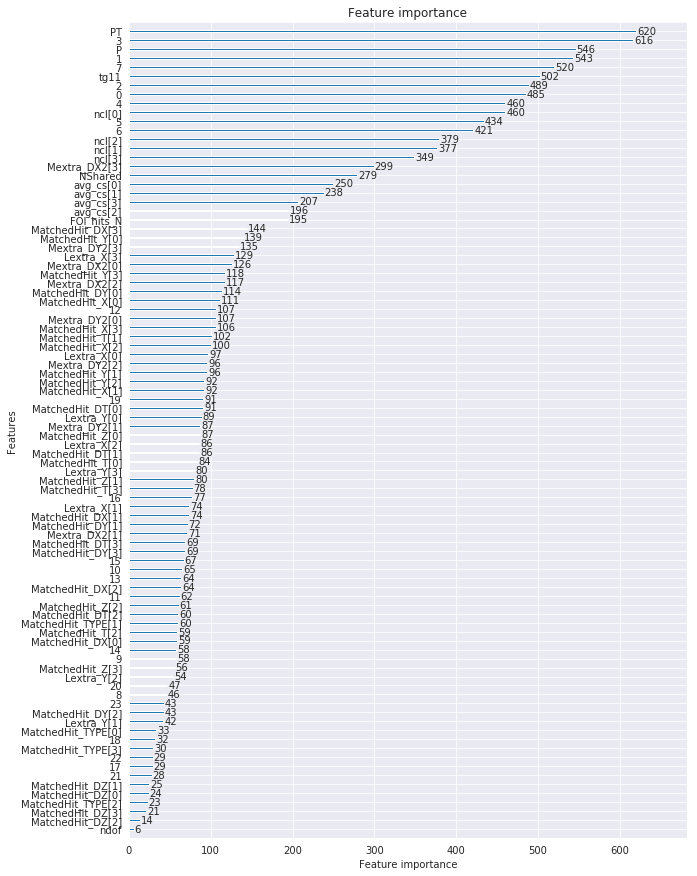

In [20]:
from lightgbm import plot_importance

plot_importance(lgb, figsize=(10, 15))

In [30]:
from catboost import CatBoostClassifier

#hyperpot est opt{'depth': 6.0, 'l2_leaf_reg': 68.0, 'border_count': 110.0, 'learning_rate': 0.08476126795545437, 'n_estimators': 440.0}
params1  = {'depth': 7,
           'l2_leaf_reg': 36,
           'n_estimators': 600,
           'learning_rate': 0.059,
           'border_count': 190}

params2 = {'n_estimators': 435,
           'learning_rate': 0.094,
           'border_count': 70,
           'depth': 6,
           'l2_leaf_reg': 48}

cat_boost = CatBoostClassifier(n_estimators=params2['n_estimators'],
                               learning_rate=params2['learning_rate'],
                               border_count=params2['border_count'],
                               l2_leaf_reg=params2['l2_leaf_reg'],
                               depth=params1['depth'],
                               thread_count=8,
                               verbose=False)
cat_boost

In [51]:
%%time
#training with foi features
abs_weights = np.abs(train_part.weight)#np.abs(train_part.weight)#scl.fit_transform(train_part.weight.values.reshape(-1, 1)).reshape(1,-1)[0]
columns = utils.SIMPLE_FEATURE_COLUMNS+CLOSEST_HITS
cat_boost.fit(train_part.loc[:, columns],
          train_part.label,
          sample_weight=abs_weights)
gc.collect()

validation_predictions = cat_boost.predict_proba(validation.loc[:, columns].values)[:, 1]
train_part_prediction = cat_boost.predict_proba(train_part.loc[:, columns].values)[:, 1]
tr_score = scoring.rejection90(train_part.label.values, train_part_prediction, sample_weight=train_part.weight.values)
test_score = scoring.rejection90(validation.label.values, validation_predictions, sample_weight=validation.weight.values)
print('train: {0}, valid: {1}'.format(tr_score, test_score))
#cv_train, cv_test_org = cros_val_rej90score(lgb, train_part, columns=utils.SIMPLE_FEATURE_COLUMNS+CLOSEST_HITS)
#print('cv train org: {0}, cv test org: {1}'.format(cv_train, cv_test_org))

train: 0.7930882809420309, valid: 0.7533174057994996
CPU times: user 1h 8min 58s, sys: 1min 47s, total: 1h 10min 45s
Wall time: 12min 13s


n estimators 200
train: 0.7776788897333269, valid: 0.7421788669233893
n estimators 220
train: 0.7836830654807302, valid: 0.7426697757018084
n estimators 240
train: 0.7874800155136242, valid: 0.7459233511865696
n estimators 260
train: 0.791884352564196, valid: 0.7467497951824138
n estimators 280
train: 0.7949641534784776, valid: 0.7475336387843897


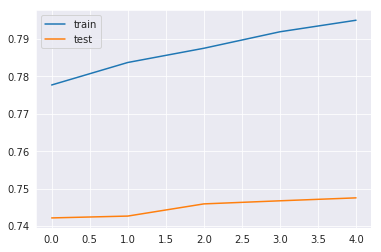

In [36]:
abs_weights = np.abs(train_part.weight)#np.abs(train_part.weight)#scl.fit_transform(train_part.weight.values.reshape(-1, 1)).reshape(1,-1)[0]
columns = utils.SIMPLE_FEATURE_COLUMNS+CLOSEST_HITS
train_scores = []
test_scores = []

for param in [290, 300, 310, 320, 339]:
    print('n estimators {}'.format(param))
    cat_boost = CatBoostClassifier(n_estimators=param,
                               learning_rate=0.1,
                               max_depth=8,
                               thread_count=8,
                               verbose=False)
    
    cat_boost.fit(train_part.loc[:, columns],
                  train_part.label,
                  sample_weight=abs_weights)
    gc.collect()

    validation_predictions = cat_boost.predict_proba(validation.loc[:, columns].values)[:, 1]
    train_part_prediction = cat_boost.predict_proba(train_part.loc[:, columns].values)[:, 1]
    tr_score = scoring.rejection90(train_part.label.values, train_part_prediction, sample_weight=train_part.weight.values)
    test_score = scoring.rejection90(validation.label.values, validation_predictions, sample_weight=validation.weight.values)
    print('train: {0}, valid: {1}'.format(tr_score, test_score))
    train_scores.append(tr_score)
    test_scores.append(test_score)
    
plt.plot(train_scores)
plt.plot(test_scores)
plt.legend(('train', 'test'))
plt.show()

In [25]:
from hyperopt import STATUS_OK

def objective_catboost(params):
    """
        A function to finds hyperparametrs using hyperopt
    """
    params = {
        'learning_rate': float('{:.3f}'.format(params['learning_rate'])),
        'depth': int(params['depth']),
        'n_estimators': int(params['n_estimators']),
        'border_count': int(params['border_count']),
        'l2_leaf_reg': int(params['l2_leaf_reg'])
    }
    
    clf = CatBoostClassifier(
                            learning_rate=float(params['learning_rate']),
                            iterations=int(params['n_estimators']),
                            depth=int(params['depth']),
                            border_count=int(params['border_count']),
                            l2_leaf_reg=int(params['l2_leaf_reg']),
                            random_state=RANDOM_STATE,
                            thread_count=8,
                            verbose=False
                            )
    
    score = cros_val_rej90score(clf, X, cv=4, columns=COLUMNS)
    clf.fit(X.loc[:, COLUMNS], Y, sample_weight=WEIGHT)
    validation_predictions = clf.predict_proba(TEST.loc[:, COLUMNS].values)[:, 1]
    train_part_prediction = clf.predict_proba(X.loc[:, COLUMNS].values)[:, 1]
    tr_score = scoring.rejection90(X.label.values, train_part_prediction, sample_weight=X.weight.values)
    test_score = scoring.rejection90(TEST.label.values, validation_predictions, sample_weight=TEST.weight.values)
    #print(score)
    print('train cv: {0},  test cv: {1}'.format(score[0], score[1]))
    print('train fold: {0},  test fold: {1},'.format(tr_score, test_score))
    res_train_s = (0.985*score[0]+tr_score)/2
    res_test_s = (0.985*score[1]+test_score)/2
    
    print('train res: {0},  test res: {1}, params {2}'.format(res_train_s, res_test_s, params))

        
    if (res_train_s - res_test_s) > 0.05:
        print('overfited')
        s = 0.5 - res_train_s + res_test_s
    else:
        s = res_test_s
    print('loss: ', 1 - s)
    print('________________________________________________________________________________________________________')
    
    with open('cat_boost_log.txt', 'a') as log:
        log.write(' '.join(['loss {}'.format(1 - s), str(res_train_s), str(res_test_s), str(params)]) +'\n')
    
    return {'loss': 1 - s, 'params':params, 'status': STATUS_OK}

In [ ]:
#an attempt to use hyperopt
X = train_part
Y = train_part.label
TEST = validation
WEIGHT = np.abs(train_part.weight)
COLUMNS = utils.SIMPLE_FEATURE_COLUMNS + CLOSEST_HITS + ['tg11']

space = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.04), np.log(0.1)),
    'depth': hp.quniform('depth', 3, 12, 1),
    'border_count': hp.quniform('border_count', 5, 200, 10),
    'n_estimators': hp.quniform('n_estimators', 90, 500, 5),
    'l2_leaf_reg': hp.quniform('l2_leaf_reg', 1, 100, 2)
}

best = fmin(fn=objective_catboost,
          space=space,
          algo=tpe.suggest,
          max_evals=100)

print("hyperpot est opt{}".format(best))

cat_boost = CatBoostClassifier(
    learning_rate=float(best['learning_rate']),
    iterations=int(best['n_estimators']),
    depth=int(best['depth']),
    border_count=int(best['border_count']),
    l2_leaf_reg=int(best['l2_leaf_reg']),
    random_state=RANDOM_STATE
)

abs_weights = np.abs(train_part.weight)
cat_boost.fit(train_part.loc[:, COLUMNS],
          train_part.label,
          sample_weight=abs_weights.values)
gc.collect()

validation_predictions = cat_boost.predict_proba(validation.loc[:, COLUMNS].values)[:, 1]
train_part_prediction = cat_boost.predict_proba(train_part.loc[:, COLUMNS].values)[:, 1]
tr_score = scoring.rejection90(train_part.label.values, train_part_prediction, sample_weight=train_part.weight.values)
test_score = scoring.rejection90(validation.label.values, validation_predictions, sample_weight=validation.weight.values)
print('train: {0}, valid: {1}'.format(tr_score, test_score))

In [ ]:
with open('cat_boost_params.pickle', 'wb') as f:
    pickle.dump(best, f)

In [ ]:
#from imblearn.ensemble import RUSBoostClassifier
#rusboost = RUSBoostClassifier(random_state=RANDOM_STATE)
#
#columns = utils.SIMPLE_FEATURE_COLUMNS+CLOSEST_HITS
#rusboost.fit(train_part.loc[:, columns],
#          train_part.label)
#gc.collect()
#
#validation_predictions = rusboost.predict_proba(validation.loc[:, columns].values)[:, 1]
#train_part_prediction = rusboost.predict_proba(train_part.loc[:, columns].values)[:, 1]
#tr_score = scoring.rejection90(train_part.label.values, train_part_prediction, sample_weight=train_part.weight.values)
#test_score = scoring.rejection90(validation.label.values, validation_predictions, sample_weight=validation.weight.values)
#print('train: {0}, valid: {1}'.format(tr_score, test_score))

In [45]:
#%%time
#from imblearn.combine import SMOTEENN
#smote_enn = SMOTEENN(random_state=RANDOM_STATE)
#
#columns = utils.SIMPLE_FEATURE_COLUMNS+CLOSEST_HITS
#X_resampled, y_resampled = smote_enn.fit_resample(train_part.loc[:1000000].loc[:, columns], train_part.loc[:1000000].label)
#
#X_resampled.shape

CPU times: user 4h 1min 46s, sys: 3.47 s, total: 4h 1min 50s
Wall time: 4h 1min 49s


In [46]:
#from imblearn.combine import SMOTEENN
#smote_enn = SMOTEENN(random_state=42)
#
#columns = utils.SIMPLE_FEATURE_COLUMNS+CLOSEST_HITS
##X_resampled, y_resampled = smote_enn.fit_resample(train_part.loc[:, columns], train_part.label)
#
#cat_boost.fit(X_resampled,
#          y_resampled)
#gc.collect()
#
#validation_predictions = cat_boost.predict_proba(validation.loc[:, columns])[:, 1]
#train_part_prediction = cat_boost.predict_proba(train_part.loc[:, columns])[:, 1]
#tr_score = scoring.rejection90(train_part.label.values, train_part_prediction, sample_weight=train_part.weight.values)
#test_score = scoring.rejection90(validation.label.values, validation_predictions, sample_weight=validation.weight.values)
#print('train: {0}, valid: {1}'.format(tr_score, test_score))

train: 0.7336224480825169, valid: 0.7131836619529655


In [ ]:
# An attempt to use stacking

In [31]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression

class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, columns, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
        self.columns = columns
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            print('current model is {}'.format(type(model)))
            j = 1
            for train_index, holdout_index in kfold.split(X, y):
                print('fold num is {}'.format(j))
                j += 1
                instance = clone(model)
                self.base_models_[i].append(instance)
                x_ = X.loc[:, self.columns]
                #print(X.columns)
                w = np.abs(X['weight'])
                instance.fit(x_.loc[train_index], y.loc[train_index], sample_weight=w.loc[train_index])
                y_pred = instance.predict(x_.loc[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                del x_
                gc.collect()
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict_proba(self, X):
        print('predicting meta features')
        meta_features = np.column_stack([
            np.column_stack([model.predict_proba(X)[:,1] for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        print('predicting result')
        return self.meta_model_.predict_proba(meta_features)

In [32]:
%%time
log_reg = LogisticRegression(C=0.765)
columns = utils.SIMPLE_FEATURE_COLUMNS+CLOSEST_HITS +['tg11']

stacked_averaged_models = StackingAveragedModels(base_models = (lgb, cat_boost),
                                                 columns=columns,
                                                 meta_model = log_reg)
#stacked_averaged_models.fit(train_part, train_part.label)
#
#validation_predictions = stacked_averaged_models.predict_proba(validation.loc[:, columns].values)[:, 1]
#train_part_prediction = stacked_averaged_models.predict_proba(train_part.loc[:, columns].values)[:, 1]
#tr_score = scoring.rejection90(train_part.label.values, train_part_prediction, sample_weight=train_part.weight.values)
#test_score = scoring.rejection90(validation.label.values, validation_predictions, sample_weight=validation.weight.values)
#print('train: {0}, valid: {1}'.format(tr_score, test_score))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 30.3 µs


In [ ]:
%%time
#training with foi features
abs_weights = train_part.weight#np.abs(train_part.weight)#scl.fit_transform(train_part.weight.values.reshape(-1, 1)).reshape(1,-1)[0]
lgb.fit(train_part.loc[:, utils.SIMPLE_FEATURE_COLUMNS+CLOSEST_HITS],
          train_part.label,
          sample_weight=abs_weights,
          categorical_feature=CATEGORICAL_FEATURES)
gc.collect()

validation_predictions = lgb.predict_proba(validation.loc[:, utils.SIMPLE_FEATURE_COLUMNS+CLOSEST_HITS].values)[:, 1]
train_part_prediction = lgb.predict_proba(train_part.loc[:, utils.SIMPLE_FEATURE_COLUMNS+CLOSEST_HITS].values)[:, 1]
print('train: {0}, valid: {1}'.format(scoring.rejection90(train_part.label.values, train_part_prediction, sample_weight=train_part.weight.values),
                                     scoring.rejection90(validation.label.values, validation_predictions, sample_weight=validation.weight.values)))
cv_train, cv_test_org = cros_val_rej90score(lgb, train_part, columns=utils.SIMPLE_FEATURE_COLUMNS+CLOSEST_HITS)
print('cv train org: {0}, cv test org: {1}'.format(cv_train, cv_test_org))

# Test X,Y dist beetween Lextra and Matched

In [ ]:
def get_lextra_match_dist(df):
    ddf = pd.DataFrame()
    ddf['LextraMatched_X[2]'] = (df['Lextra_X[1]'] - df['MatchedHit_X[1]'])**2
    ddf['LextraMatched_Y[2]'] = (df['Lextra_Y[1]'] - df['MatchedHit_Y[1]'])**2    
    ddf['LextraMatched_X[3]'] = (df['Lextra_X[2]'] - df['MatchedHit_X[2]'])**2
    ddf['LextraMatched_Y[3]'] = (df['Lextra_Y[2]'] - df['MatchedHit_Y[2]'])**2    
    ddf['LextraMatched_X[4]'] = (df['Lextra_X[3]'] - df['MatchedHit_X[3]'])**2
    ddf['LextraMatched_Y[4]'] = (df['Lextra_Y[3]'] - df['MatchedHit_Y[3]'])**2
    ddf['LextraMatched_X[1]'] = (df['Lextra_X[0]'] - df['MatchedHit_X[0]'])**2
    ddf['LextraMatched_Y[1]'] = (df['Lextra_Y[0]'] - df['MatchedHit_Y[0]'])**2
    
    return ddf

In [51]:
def get_heizenberg_match(df):
    ddf = pd.DataFrame()
    ddf['Heize_math_X[0]'] = df['P']*df['MatchedHit_DX[0]']
    ddf['Heize_math_Y[0]'] = df['P']*df['MatchedHit_DY[0]']
    ddf['Heize_math_Z[0]'] = df['P']*df['MatchedHit_DZ[0]']
    ddf['Heize_math_X[1]'] = df['P']*df['MatchedHit_DX[1]']
    ddf['Heize_math_Y[1]'] = df['P']*df['MatchedHit_DY[1]']
    ddf['Heize_math_Z[1]'] = df['P']*df['MatchedHit_DZ[1]']
    ddf['Heize_math_X[2]'] = df['P']*df['MatchedHit_DX[2]']
    ddf['Heize_math_Y[2]'] = df['P']*df['MatchedHit_DY[2]']
    ddf['Heize_math_Z[2]'] = df['P']*df['MatchedHit_DZ[2]']
    ddf['Heize_math_X[3]'] = df['P']*df['MatchedHit_DX[3]']
    ddf['Heize_math_Y[3]'] = df['P']*df['MatchedHit_DY[3]']
    ddf['Heize_math_Z[3]'] = df['P']*df['MatchedHit_DZ[3]']
    
    return ddf

In [52]:
#train_part = pd.concat([train_part, get_heizenberg_match(train_part)], axis=1)
#validation = pd.concat([validation, get_heizenberg_match(validation)], axis=1)

In [53]:
#%%time
##training with foi features
#columns = utils.SIMPLE_FEATURE_COLUMNS+CLOSEST_HITS+HEIZE_MATCH
#abs_weights = train_part.weight#np.abs(train_part.weight)#scl.fit_transform(train_part.weight.values.reshape(-1, 1)).reshape(1,-1)[0]
#lgb.fit(train_part.loc[:, columns],
#          train_part.label,
#          sample_weight=abs_weights,
#          categorical_feature=CATEGORICAL_FEATURES)
#gc.collect()
#
#validation_predictions = lgb.predict_proba(validation.loc[:, columns].values)[:, 1]
#train_part_prediction = lgb.predict_proba(train_part.loc[:, columns].values)[:, 1]
#print('train: {0}, valid: {1}'.format(scoring.rejection90(train_part.label.values, train_part_prediction, sample_weight=train_part.weight.values),
#                                     scoring.rejection90(validation.label.values, validation_predictions, sample_weight=validation.weight.values)))
#cv_train, cv_test_org = cros_val_rej90score(lgb, train_part, columns=columns, cv=3)
#print('cv train org: {0}, cv test org: {1}'.format(cv_train, cv_test_org))

/home/livington/.local/lib/python3.5/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


train: 0.7800765850348295, valid: 0.706938410141558


/home/livington/.local/lib/python3.5/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/livington/.local/lib/python3.5/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/livington/.local/lib/python3.5/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


cv train org: 0.7862909612142316, cv test org: 0.7159420025332027
CPU times: user 23min 14s, sys: 41.4 s, total: 23min 56s
Wall time: 5min 11s


In [12]:
# Test FOI for nshared hot

In [32]:
def find_hit_per_nshared_csv(row):
    """
        A function generates 'FOI' features, applys to dataframe, to each row
    """
    result = np.empty(6, dtype=np.float32)
    FOI_hits_S_arr = [int(i) for i in row["FOI_hits_S"].split('[')[1].split(']')[0].split()]
    needed_hit = row['NShared']
    if needed_hit >= len(FOI_hits_S_arr):
        needed_hit = len(FOI_hits_S_arr) -1
        print('something wrong')
    try:
        needed_station = FOI_hits_S_arr[needed_hit] - 1
    except IndexError:
        print(needed_hit, FOI_hits_S_arr)
    
    FOI_hits_X = pd.Series([float(i) for i in row["FOI_hits_X"].split('[')[1].split(']')[0].split()])
    FOI_hits_Y = pd.Series([float(i) for i in row["FOI_hits_Y"].split('[')[1].split(']')[0].split()])
    #print(FOI_hits_X)
    x_distances_2 = (row["Lextra_X[%i]" % needed_station] - FOI_hits_X[needed_hit])**2
    y_distances_2 = (row["Lextra_Y[%i]" % needed_station] - FOI_hits_Y[needed_hit])**2
    closest_x_per_station = x_distances_2
    closest_y_per_station = y_distances_2
    
    FOI_hits_T  = pd.Series([int(i) for i in row["FOI_hits_T"].split('[')[1].split(']')[0].split()])
    FOI_hits_Z  = pd.Series([float(i) for i in row["FOI_hits_Z"].split('[')[1].split(']')[0].split()])
    FOI_hits_DX = pd.Series([float(i) for i in row["FOI_hits_DX"].split('[')[1].split(']')[0].split()])
    FOI_hits_DY = pd.Series([float(i) for i in row["FOI_hits_DY"].split('[')[1].split(']')[0].split()])
    
    closest_T_per_station  =  FOI_hits_T [needed_hit]
    closest_z_per_station  =  FOI_hits_Z [needed_hit]
    closest_dx_per_station =  FOI_hits_DX[needed_hit]
    closest_dy_per_station =  FOI_hits_DY[needed_hit]
    
    return np.array([closest_x_per_station,
                     closest_y_per_station,
                     closest_T_per_station,
                     closest_z_per_station,
                     closest_dx_per_station,
                     closest_dy_per_station])

In [49]:
#nshared_features_test.to_csv('nshared_features_test.csv', index=False)
#nshared_features.to_csv('nshared_features_train.csv', index=False)

In [50]:
#test = pd.concat([test, nshared_features_test], axis=1)
#train = pd.concat([train, nshared_features], axis=1)
#test.head()

,ncl[0],ncl[1],ncl[2],ncl[3],avg_cs[0],avg_cs[1],avg_cs[2],avg_cs[3],ndof,MatchedHit_TYPE[0],...,20,21,22,23,nshared_x_per_station,nshared_y_per_station,nshared_T_per_station,nshared_z_per_station,nshared_dx_per_station,nshared_dy_per_station
0,55,12,10,15,2.127273,1.166667,1.500000,1.600000,8,2,...,63.078957,68.078926,73.078896,78.078860,5.248676,2706.392529,6.0,15396.441,12.750000,63.078957
1,43,18,12,15,2.697675,1.111111,1.333333,1.600000,8,2,...,31.479162,33.979145,36.479130,38.979115,89.682794,15987.718451,6.0,15401.720,6.375000,126.278550
2,90,34,19,29,1.800000,2.058824,1.210526,1.344828,8,2,...,126.278550,136.278490,146.278410,156.278350,1451.564280,0.652702,3.0,15112.236,25.500000,126.278550
3,141,43,15,16,4.609929,2.744186,1.466667,1.125000,8,2,...,15.679264,16.929256,18.179249,38.979115,686.785359,15321.156671,14.0,15119.441,3.208333,126.278550
4,22,18,8,9,1.636364,2.444444,1.000000,1.555556,8,2,...,15.679264,16.929256,18.179249,19.429240,3.157765,13.408340,8.0,15203.053,3.208333,15.679264


In [43]:
#train_part, validation = train_test_split(train, test_size=0.25, shuffle=True, random_state=RANDOM_STATE)
#train_part.index, validation.index = range(len(train_part)), range(len(validation))
##del train
#gc.collect()

10

In [55]:
#%%time
##training with foi features
#columns = utils.SIMPLE_FEATURE_COLUMNS+CLOSEST_HITS+NSHARED_HIT
#abs_weights = train_part.weight#np.abs(train_part.weight)#scl.fit_transform(train_part.weight.values.reshape(-1, 1)).reshape(1,-1)[0]
#lgb.fit(train_part.loc[:, columns],
#          train_part.label,
#          sample_weight=abs_weights,
#          categorical_feature=CATEGORICAL_FEATURES)
#gc.collect()
#
#validation_predictions = lgb.predict_proba(validation.loc[:, columns].values)[:, 1]
#train_part_prediction = lgb.predict_proba(train_part.loc[:, columns].values)[:, 1]
#print('train: {0}, valid: {1}'.format(scoring.rejection90(train_part.label.values, train_part_prediction, sample_weight=train_part.weight.values),
#                                     scoring.rejection90(validation.label.values, validation_predictions, sample_weight=validation.weight.values)))
##cv_train, cv_test_org = cros_val_rej90score(lgb, train_part, columns=columns, cv=3)
##print('cv train org: {0}, cv test org: {1}'.format(cv_train, cv_test_org))

/home/livington/.local/lib/python3.5/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


train: 0.7845869429947664, valid: 0.7191939777177951
CPU times: user 7min 23s, sys: 12.8 s, total: 7min 35s
Wall time: 1min 37s


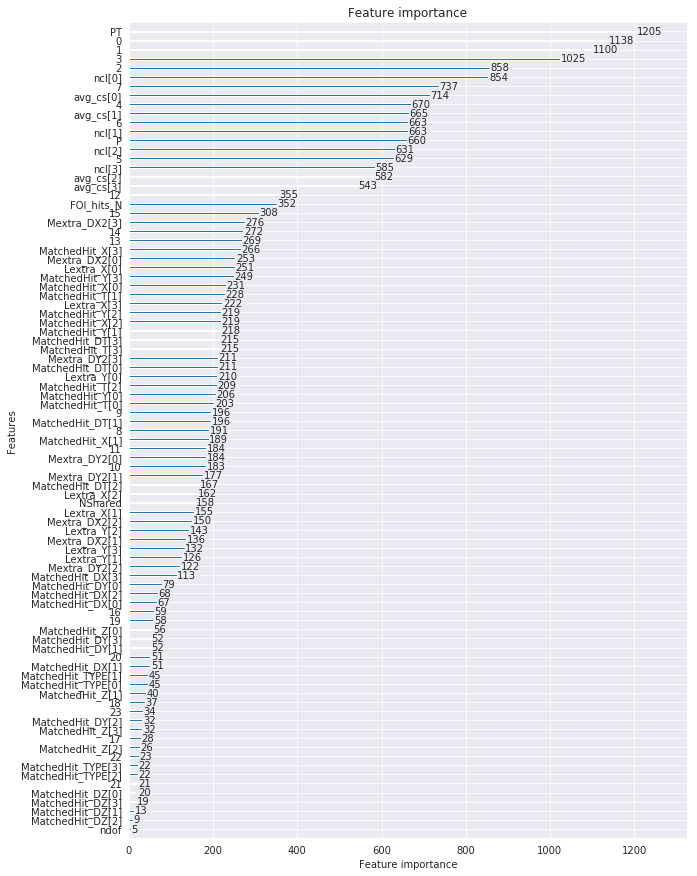

In [147]:
#from lightgbm import plot_importance
#
#plot_importance(lgb, figsize=(10, 15))

# Declare function for hyperopt

In [98]:
from hyperopt import STATUS_OK

def objective(params):
    """
        A function to finds hyperparametrs using hyperopt
    """
    params = {
        'learning_rate': '{:.4f}'.format(params['learning_rate']),
        'num_leaves': int(params['num_leaves']),
        'colsample_bytree': '{:.4f}'.format(params['colsample_bytree']),
        'subsample_for_bin': int(params['subsample_for_bin']),
        'min_child_samples': int(params['min_child_samples']),
        'n_estimators': int(params['n_estimators']),
        'reg_alpha': '{:.4f}'.format(params['reg_alpha']),
        'reg_lambda': '{:.4f}'.format(params['reg_lambda'])
    }
    
    clf = lgbm.LGBMClassifier(
    objective='binary',
    feature_fraction=0.8,
    bagging_freq=1,
    bagging_fraction=0.8,
    random_state=RANDOM_STATE,
    **params)
    
    score = cros_val_rej90score(clf, X, cv=4, columns=COLUMNS)
    clf.fit(X.loc[:, COLUMNS], Y, sample_weight=WEIGHT)
    validation_predictions = clf.predict_proba(TEST.loc[:, COLUMNS].values)[:, 1]
    train_part_prediction = clf.predict_proba(X.loc[:, COLUMNS].values)[:, 1]
    tr_score = scoring.rejection90(X.label.values, train_part_prediction, sample_weight=X.weight.values)
    test_score = scoring.rejection90(TEST.label.values, validation_predictions, sample_weight=TEST.weight.values)
    #print(score)
    print('train cv: {0},  test cv: {1}'.format(score[0], score[1]))
    print('train fold: {0},  test fold: {1},'.format(tr_score, test_score))
    res_train_s = (0.985*score[0]+tr_score)/2
    res_test_s = (0.985*score[1]+test_score)/2
    
    print('train res: {0},  test res: {1}, params {2}'.format(res_train_s, res_test_s, params))
    if (res_train_s - res_test_s) > 0.06:
        print('overfited')
        s = 0.5 - res_train_s + res_test_s
    else:
        s = res_test_s
    print('loss: ', 1 - s)
    print('________________________________________________________________________________________________________')
    with open('lgbm_log.txt', 'a') as log:
        log.write(' '.join(['loss {}'.format(1 - s), str(res_train_s), str(res_test_s), str(params)]) +'\n')
    
    return {'loss': 1 - s, 'params':params, 'status': STATUS_OK}

# A finding hyperparametrs using hyperopt

In [ ]:
#an attempt to use hyperopt
X = train_part
Y = train_part.label
TEST = validation
WEIGHT = np.abs(train_part.weight)
COLUMNS = utils.SIMPLE_FEATURE_COLUMNS + CLOSEST_HITS + ['tg11']

space = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.04), np.log(0.8)),
    'num_leaves': hp.quniform('num_leaves', 40, 60, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.80, 1.0),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 150000, 200000, 1000),
    'min_child_samples': hp.quniform('min_child_samples', 10, 40, 1),
    'n_estimators': hp.quniform('n_estimators', 90,300, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 0.3),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 0.3)
}

best = fmin(fn=objective,
          space=space,
          algo=tpe.suggest,
          max_evals=100)

print("hyperpot est opt{}".format(best))

lgb = LGBMClassifier(
    learning_rate=float(best['learning_rate']),
    n_esimators=int(best['n_estimators']),
    num_leaves=int(best['num_leaves']),
    reg_alpha=float(best['reg_alpha']),
    colsample_bytree=float(best['colsample_bytree']),
    reg_lambda=float(best['reg_lambda']),
    min_child_samples=int(best['min_child_samples']),
    subsample_for_bin=int(best['subsample_for_bin']),
    objective='binary',
    feature_fraction=0.8,
    bagging_freq=1,
    bagging_fraction=0.8,
    random_state=RANDOM_STATE
)

abs_weights = np.abs(train_part.weight)
lgb.fit(train_part.loc[:, COLUMNS],
          train_part.label,
          sample_weight=abs_weights.values)
gc.collect()

validation_predictions = lgb.predict_proba(validation.loc[:, COLUMNS].values)[:, 1]
train_part_prediction = lgb.predict_proba(train_part.loc[:, COLUMNS].values)[:, 1]
print('train rejection90: {0}, test rejection90: {1}'.format(scoring.rejection90(train_part.label.values, train_part_prediction, sample_weight=train_part.weight.values),
                                                             scoring.rejection90(validation.label.values, validation_predictions, sample_weight=validation.weight.values)))

train cv: 0.7845829985620505,  test cv: 0.7615055168899411
train fold: 0.7804339951979768,  test fold: 0.7533314386779931,
train res: 0.7766241243907983,  test res: 0.7517071864072925, params {'learning_rate': '0.0479', 'min_child_samples': 26, 'n_estimators': 135, 'num_leaves': 44, 'subsample_for_bin': 169000, 'colsample_bytree': '0.9915', 'reg_lambda': '0.1982', 'reg_alpha': '0.2118'}
loss:  0.2482928135927075
________________________________________________________________________________________________________
train cv: 0.8190587744782324,  test cv: 0.7779265294592341
train fold: 0.8094932473234346,  test fold: 0.7615004412036075,
train res: 0.8081330700922468,  test res: 0.7638790363604766, params {'learning_rate': '0.0845', 'min_child_samples': 16, 'n_estimators': 150, 'num_leaves': 58, 'subsample_for_bin': 182000, 'colsample_bytree': '0.9347', 'reg_lambda': '0.2592', 'reg_alpha': '0.1829'}
loss:  0.2361209636395234
_______________________________________________________________

train cv: 0.8043791989806534,  test cv: 0.7729291015123477
train fold: 0.7978245518969358,  test fold: 0.7511578956339716,
train res: 0.7950690314464397,  test res: 0.7562465303118171, params {'learning_rate': '0.0481', 'min_child_samples': 28, 'n_estimators': 220, 'num_leaves': 48, 'subsample_for_bin': 189000, 'colsample_bytree': '0.9419', 'reg_lambda': '0.1870', 'reg_alpha': '0.1367'}
loss:  0.2437534696881829
________________________________________________________________________________________________________
train cv: 0.8307499902729217,  test cv: 0.7729594809970537
train fold: 0.8197791627322552,  test fold: 0.7617543597637126,
train res: 0.8190339515755416,  test res: 0.7615597242729053, params {'learning_rate': '0.1172', 'min_child_samples': 24, 'n_estimators': 170, 'num_leaves': 47, 'subsample_for_bin': 192000, 'colsample_bytree': '0.8607', 'reg_lambda': '0.1581', 'reg_alpha': '0.1466'}
loss:  0.2384402757270947
_______________________________________________________________

In [ ]:
import pickle
with open('best_lgbm.pickle', 'wb') as f:
         pickle.dump(best, f)

# Plot feature importance

In [ ]:
from lightgbm import plot_importance

plot_importance(lgb, figsize=(10, 15))

# Declare function needs to test new features

In [30]:
from itertools import combinations_with_replacement as comb, product

def test_new_features(model, df, new_columns, fold_df, need_compare_org=False):    
    acc_fold = []
    acc_cv = []
    all_combinations = []
    killer_features = []
    
    if need_compare_org:
            cv_train, cv_test_org = cros_val_rej90score(model, df, columns=utils.SIMPLE_FEATURE_COLUMNS+CLOSEST_HITS)
            print('cv train org: {0}, cv test org: {1}'.format(cv_train, cv_test_org))
            
            abs_weights = df.weight
            model.fit(df.loc[:, utils.SIMPLE_FEATURE_COLUMNS+CLOSEST_HITS],
              df.label,
              sample_weight=abs_weights)
            gc.collect()
    
            validation_predictions = model.predict_proba(fold_df.loc[:, utils.SIMPLE_FEATURE_COLUMNS+CLOSEST_HITS].values)[:, 1]
            train_part_prediction = model.predict_proba(df.loc[:, utils.SIMPLE_FEATURE_COLUMNS+CLOSEST_HITS].values)[:, 1]
            print('train fold org: {0}, valid fold org: {1}'.format(scoring.rejection90(df.label.values, train_part_prediction, sample_weight=df.weight.values),
                                         scoring.rejection90(fold_df.label.values, validation_predictions, sample_weight=fold_df.weight.values)))
            fold_test_org = scoring.rejection90(fold_df.label.values, validation_predictions, sample_weight=fold_df.weight.values)
            print('__________________________________________________________________________________________')
            
    for num_cols in range(1, len(new_columns)+1):
        combination = list(comb(new_columns, num_cols))
        all_combinations += combination
        for cols in combination:
            test_cols = [col for col in cols]
            if len(test_cols) == len(set(test_cols)):
                print('testing: {}'.format(test_cols))
                cv_train, cv_test = cros_val_rej90score(model, df, columns=utils.SIMPLE_FEATURE_COLUMNS+test_cols)
                print('cv train: {0}, cv test: {1}'.format(cv_train, cv_test))
                
                abs_weights = df.weight
                model.fit(df.loc[:, utils.SIMPLE_FEATURE_COLUMNS+CLOSEST_HITS+CLOSEST_HITS + test_cols],
                  df.label,
                  sample_weight=abs_weights)
                gc.collect()
        
                validation_predictions = model.predict_proba(fold_df.loc[:, utils.SIMPLE_FEATURE_COLUMNS+CLOSEST_HITS + test_cols].values)[:, 1]
                train_part_prediction = model.predict_proba(df.loc[:, utils.SIMPLE_FEATURE_COLUMNS+CLOSEST_HITS + test_cols].values)[:, 1]
                print('train fold: {0}, valid fold: {1}'.format(scoring.rejection90(df.label.values, train_part_prediction, sample_weight=df.weight.values),
                                             scoring.rejection90(fold_df.label.values, validation_predictions, sample_weight=fold_df.weight.values)))
                acc_cv.append(cv_test)
                fold_test = scoring.rejection90(fold_df.label.values, validation_predictions, sample_weight=fold_df.weight.values)
                acc_fold.append(fold_test)
                
                if need_compare_org:
                    if cv_test > cv_test_org and fold_test > fold_test_org:
                        print('******************************************************************************************')
                        print('we found killer features!!!!!')
                        killer_features.append({'cols': test_cols, 'cv_test': cv_test, 'fold_test': fold_test, 'mean score': (cv_test + fold_test)/2.})
                        print('******************************************************************************************')
                        
                    print('__________________________________________________________________________________________')
        
    max_acc_cv = max(acc_cv)
    max_acc_fold = max(acc_fold)
    
    print('best results foc cv: {0}, with cols: {1}'.format(max_acc_cv, all_combinations[acc_cv.index(max_acc_cv)]))
    print('best results foc fold: {0}, with cols: {1}'.format(max_acc_fold, all_combinations[acc_fold.index(max_acc_fold)]))
    if killer_features == []:
        print('killer features were\'nt found')
        
    return killer_features

# Add to original dataframe and test their

# Fit models with needed features and save prediction to csv

In [28]:
get_n_sav_prediction(model=stacked_averaged_models,#lgb
                     train_df=train,
                     test_df=test,
                     columns=utils.SIMPLE_FEATURE_COLUMNS + CLOSEST_HITS+['tg11'],
                     num_sb=125,
                     stacking=True)

training...
current model is <class 'lightgbm.sklearn.LGBMClassifier'>
fold num is 1
fold num is 2
fold num is 3
fold num is 4
fold num is 5
current model is <class 'catboost.core.CatBoostClassifier'>
fold num is 1
fold num is 2
fold num is 3
fold num is 4
fold num is 5


/home/livington/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


predicting
predicting meta features
predicting result
saving is done


In [24]:
#outliers
#################################################################################################################
####################################################################################################
####################################################################################################

In [30]:
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier

lr = 0.05

lgb = LGBMClassifier(num_leaves= 15,
                     #min_data_in_leaf=60,
                     objective='binary',
                     feature_fraction=0.8,
                     bagging_freq=1,
                     bagging_fraction=0.8 ,
                     #lambda_l1=0.1,
                     #lambda_l2=0.1,
                     random_state=RANDOM_STATE,
    save_binary=True)
lgb

LGBMClassifier(bagging_fraction=0.8, bagging_freq=1, boosting_type='gbdt',
        class_weight=None, colsample_bytree=1.0, feature_fraction=0.8,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=15, objective='binary',
        random_state=42, reg_alpha=0.0, reg_lambda=0.0, save_binary=True,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0)

In [48]:
abs_weights = train_part.weight#np.abs(train_part.weight)#scl.fit_transform(train_part.weight.values.reshape(-1, 1)).reshape(1,-1)[0]
lgb.fit(train_part.loc[:, utils.SIMPLE_FEATURE_COLUMNS],
          train_part.label,
          sample_weight=abs_weights,
          categorical_feature=CATEGORICAL_FEATURES)
gc.collect()

validation_predictions = lgb.predict_proba(validation.loc[:, utils.SIMPLE_FEATURE_COLUMNS].values)[:, 1]
train_part_prediction = lgb.predict_proba(train_part.loc[:, utils.SIMPLE_FEATURE_COLUMNS].values)[:, 1]
print('train: {0}, valid: {1}'.format(scoring.rejection90(train_part.label.values, train_part_prediction, sample_weight=train_part.weight.values),
                                     scoring.rejection90(validation.label.values, validation_predictions, sample_weight=validation.weight.values)))
train_cv, valid_cv = cros_val_rej90score(model=lgb, df=train_part)
print('train cv: {0}, valid cv: {1}'.format(train_cv, valid_cv))

c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


train: 0.565197623228629, valid: 0.5478415211839943


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


train cv: 0.5560410520944179, valid cv: 0.5222822525208831


In [47]:
train_part_wo = get_rid_of_outliers(train_part, th=10)
abs_weights = train_part_wo.weight#np.abs(train_part.weight)#scl.fit_transform(train_part.weight.values.reshape(-1, 1)).reshape(1,-1)[0]
lgb.fit(train_part_wo.loc[:, utils.SIMPLE_FEATURE_COLUMNS],
          train_part_wo.label,
          sample_weight=abs_weights,
          categorical_feature=CATEGORICAL_FEATURES)
gc.collect()

validation_predictions = lgb.predict_proba(validation.loc[:, utils.SIMPLE_FEATURE_COLUMNS].values)[:, 1]
train_part_prediction = lgb.predict_proba(train_part_wo.loc[:, utils.SIMPLE_FEATURE_COLUMNS].values)[:, 1]
print('train: {0}, valid: {1}'.format(scoring.rejection90(train_part_wo.label.values, train_part_prediction, sample_weight=train_part_wo.weight.values),
                                     scoring.rejection90(validation.label.values, validation_predictions, sample_weight=validation.weight.values)))
train_cv, valid_cv = cros_val_rej90score(model=lgb, df=train_part, skip_outliers=True, th=10)
print('train cv: {0}, valid cv: {1}'.format(train_cv, valid_cv))

c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


train: 0.5718136986739554, valid: 0.5501839589313197


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


train: 0.5602210736400046, valid: 0.5214678952204261


In [ ]:
#end working with outliers
#################################################################################################################
####################################################################################################
####################################################################################################

In [15]:
#kmeans experementation
#################################################################################################################
####################################################################################################
####################################################################################################

from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=2)

pions_protons = train[train['label'] == 0]
muons = train[train['label'] == 1]
muons['label_new'] = muons['label']
kmeans.fit(pions_protons.loc[:, utils.SIMPLE_FEATURE_COLUMNS])
pions_protons['label_new'] = kmeans.labels_ + 2
train = pd.concat([muons, pions_protons]).sample(frac=1).reset_index(drop=True)

del pions_protons
del muons
gc.collect()

print(train['label_new'].value_counts())

train.head()

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


1    4101637
2     330983
3      13084
Name: label_new, dtype: int64


,ncl[0],ncl[1],ncl[2],ncl[3],avg_cs[0],avg_cs[1],avg_cs[2],avg_cs[3],ndof,MatchedHit_TYPE[0],...,Mextra_DY2[0],Mextra_DY2[1],Mextra_DY2[2],Mextra_DY2[3],FOI_hits_N,PT,P,label,weight,label_new
0,117,20,14,20,2.264957,2.300000,1.142857,1.750000,8,2,...,28.921875,83.881889,187.048660,357.625366,5,2223.342041,40941.765625,1,4.306937,1
1,58,12,8,11,1.896552,2.416667,1.250000,1.363636,8,2,...,189.250000,556.717834,1261.376831,2449.543213,7,1189.027710,16655.207031,1,1.597191,1
2,68,10,3,9,2.647059,1.400000,1.000000,1.222222,8,2,...,167.000000,479.947510,1081.584473,2101.219971,5,1409.377930,17447.039062,0,1.228503,2
3,79,34,18,15,2.025316,2.117647,1.777778,1.533333,8,2,...,530.500000,1539.136841,3423.833740,6407.241211,6,1034.950928,10180.036133,1,2.219013,1
4,19,6,18,10,3.052632,1.333333,1.555556,1.400000,8,2,...,1048.000000,2978.009277,6200.833984,11516.079102,4,921.205994,7475.289062,1,2.703635,1


In [16]:
train_part, validation = train_test_split(train, test_size=0.25, shuffle=True, random_state=RANDOM_STATE)
train_part.index, validation.index = range(len(train_part)), range(len(validation))

In [17]:
from sklearn.model_selection import KFold

def cros_val_rej90score_mclass(model, df, columns=utils.SIMPLE_FEATURE_COLUMNS, cv=3, skip_outliers=False, th=11):
    chunk_size = len(df)//cv
    val_scores = []
    train_scores = []
    kf = KFold(n_splits=cv)
    kf.get_n_splits(df)
    
    for train_index, test_index in kf.split(df):          
        train_part, validation = df.loc[train_index], df.loc[test_index]
        if skip_outliers:
            train_part = get_rid_of_outliers(train_part, th=th)
        
        abs_weights = train_part.weight
        model.fit(train_part.loc[:, columns],
              train_part.label_new,
              sample_weight=abs_weights.values,
              categorical_feature=CATEGORICAL_FEATURES)
        gc.collect()
        
        validation_predictions = model.predict_proba(validation.loc[:, columns].values)[:, 0]
        train_part_prediction = model.predict_proba(train_part.loc[:, columns].values)[:, 0]
        
        val_score = scoring.rejection90(validation.label.values, validation_predictions, sample_weight=validation.weight.values)
        train_score = scoring.rejection90(train_part.label.values, train_part_prediction, sample_weight=train_part.weight.values)
        
        val_scores.append(val_score)
        train_scores.append(train_score)
        
        del train_part
        del validation
        gc.collect()
        
    return np.mean(train_scores), np.mean(val_scores)

In [23]:
abs_weights = train_part.weight#np.abs(train_part.weight)#scl.fit_transform(train_part.weight.values.reshape(-1, 1)).reshape(1,-1)[0]
lgb.fit(train_part.loc[:, utils.SIMPLE_FEATURE_COLUMNS],
          train_part.label_new,
          sample_weight=abs_weights,
          categorical_feature=CATEGORICAL_FEATURES)
gc.collect()

validation_predictions = lgb.predict_proba(validation.loc[:, utils.SIMPLE_FEATURE_COLUMNS].values)[:, 0]
train_part_prediction = lgb.predict_proba(train_part.loc[:, utils.SIMPLE_FEATURE_COLUMNS].values)[:, 0]
print('train: {0}, valid: {1}'.format(scoring.rejection90(train_part.label.values, train_part_prediction, sample_weight=train_part.weight.values),
                                     scoring.rejection90(validation.label.values, validation_predictions, sample_weight=validation.weight.values)))
train_cv, valid_cv = cros_val_rej90score_mclass(model=lgb, df=train_part)
print('train cv: {0}, valid cv: {1}'.format(train_cv, valid_cv))


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


train: 0.5940414325182856, valid: 0.5445485233635905


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


train cv: 0.609454717104118, valid cv: 0.5138115638685596


In [18]:
from hyperopt import STATUS_OK

def objective(params):
    params = {
        'learning_rate': '{:.3f}'.format(params['learning_rate']),
        'num_leaves': int(params['num_leaves']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
        'subsample_for_bin': int(params['subsample_for_bin']),
        'min_child_samples': int(params['min_child_samples']),
        'n_estimators': int(params['n_estimators']),
        'reg_alpha': '{:.3f}'.format(params['reg_alpha']),
        'reg_lambda': '{:.3f}'.format(params['reg_lambda'])
    }
    
    clf = lgbm.LGBMClassifier(
    objective='multiclass',
    metric='multi_logloss',
    feature_fraction=0.8,
    bagging_fraction=0.8,
    random_state=RANDOM_STATE,
    **params)
    
    score = cros_val_rej90score_mclass(clf, X, skip_outliers=True)
    #print(score)
    
    print('rej90score train: {0},  rej90score test: {1}, params {2}'.format(score[0], score[1], params))
    if (score[0] - score[1]) > 0.07:
        print('overfited')
        s = 0.5 - score[0] + score[1]
    else:
        s = score[1]
    print('loss: ', 1 - s)
    print('________________________________________________________________________________________________________')
    
    return {'loss': 1 - s, 'params':params, 'status': STATUS_OK}

In [19]:
#an attempt to use hyperopt
from lightgbm import LGBMClassifier

X = train_part
Y = train_part.label
WEIGHT = train_part.weight

space = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.04), np.log(0.1)),
    'num_leaves': hp.quniform('num_leaves', 20, 150, 5),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.85, 1.0),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 150000, 250000, 20000),
    'min_child_samples': hp.quniform('min_child_samples', 5, 40, 5),
    'n_estimators': hp.quniform('n_estimators', 70,110, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 0.4),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 0.4)
}

best = fmin(fn=objective,
          space=space,
          algo=tpe.suggest,
          max_evals=600)

print("hyperpot est opt{}".format(best))

lgb = LGBMClassifier(
    learning_rate=float(best['learning_rate']),
    n_esimators=int(best['n_estimators']),
    num_leaves=int(best['num_leaves']),
    reg_alpha=float(best['reg_alpha']),
    colsample_bytree=float(best['colsample_bytree']),
    reg_lambda=float(best['reg_lambda']),
    min_child_samples=int(best['min_child_samples']),
    subsample_for_bin=int(best['subsample_for_bin']),
    objective='multiclass',
    metric='multi_logloss',
    feature_fraction=0.8,
    bagging_fraction=0.8,
    random_state=RANDOM_STATE
)

train_part = get_rid_of_outliers(train_part, th=11)
abs_weights = train_part.weight
lgb.fit(train_part.loc[:, utils.SIMPLE_FEATURE_COLUMNS],
          train_part.label_new,
          sample_weight=abs_weights.values)
gc.collect()

validation_predictions = lgb.predict_proba(validation.loc[:, utils.SIMPLE_FEATURE_COLUMNS].values)[:, 0]
train_part_prediction = lgb.predict_proba(train_part.loc[:, utils.SIMPLE_FEATURE_COLUMNS].values)[:, 0]
print('train rejection90: {0}, test rejection90: {1}'.format(scoring.rejection90(train_part.label.values, train_part_prediction, sample_weight=train_part.weight.values),
                                                             scoring.rejection90(validation.label.values, validation_predictions, sample_weight=validation.weight.values)))

c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6149583569456261,  rej90score test: 0.54566383420851, params {'learning_rate': '0.088', 'num_leaves': 75, 'colsample_bytree': '0.864', 'subsample_for_bin': 180000, 'min_child_samples': 40, 'n_estimators': 95, 'reg_alpha': '0.182', 'reg_lambda': '0.176'}
loss:  0.45433616579149005
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.582133927711585,  rej90score test: 0.5427094214994429, params {'learning_rate': '0.042', 'num_leaves': 40, 'colsample_bytree': '0.955', 'subsample_for_bin': 220000, 'min_child_samples': 15, 'n_estimators': 100, 'reg_alpha': '0.135', 'reg_lambda': '0.371'}
loss:  0.4572905785005571
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6330352011636224,  rej90score test: 0.5370669566273275, params {'learning_rate': '0.053', 'num_leaves': 120, 'colsample_bytree': '0.999', 'subsample_for_bin': 200000, 'min_child_samples': 25, 'n_estimators': 105, 'reg_alpha': '0.365', 'reg_lambda': '0.176'}
overfited
loss:  0.5959682445362949
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.60947796772356,  rej90score test: 0.5422669270965969, params {'learning_rate': '0.042', 'num_leaves': 100, 'colsample_bytree': '0.919', 'subsample_for_bin': 240000, 'min_child_samples': 15, 'n_estimators': 80, 'reg_alpha': '0.071', 'reg_lambda': '0.137'}
loss:  0.45773307290340315
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6027222109213193,  rej90score test: 0.5475988517203354, params {'learning_rate': '0.074', 'num_leaves': 65, 'colsample_bytree': '0.996', 'subsample_for_bin': 200000, 'min_child_samples': 15, 'n_estimators': 85, 'reg_alpha': '0.107', 'reg_lambda': '0.329'}
loss:  0.4524011482796646
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6375449485659223,  rej90score test: 0.5391018582032536, params {'learning_rate': '0.060', 'num_leaves': 125, 'colsample_bytree': '0.871', 'subsample_for_bin': 240000, 'min_child_samples': 25, 'n_estimators': 105, 'reg_alpha': '0.007', 'reg_lambda': '0.380'}
overfited
loss:  0.5984430903626686
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6032388425675,  rej90score test: 0.5473631082265524, params {'learning_rate': '0.072', 'num_leaves': 70, 'colsample_bytree': '0.986', 'subsample_for_bin': 180000, 'min_child_samples': 10, 'n_estimators': 95, 'reg_alpha': '0.326', 'reg_lambda': '0.062'}
loss:  0.45263689177344757
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.60599976749279,  rej90score test: 0.5450848553119892, params {'learning_rate': '0.090', 'num_leaves': 75, 'colsample_bytree': '0.854', 'subsample_for_bin': 160000, 'min_child_samples': 25, 'n_estimators': 70, 'reg_alpha': '0.018', 'reg_lambda': '0.313'}
loss:  0.45491514468801075
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6169409565267872,  rej90score test: 0.5451321397692395, params {'learning_rate': '0.094', 'num_leaves': 135, 'colsample_bytree': '0.871', 'subsample_for_bin': 220000, 'min_child_samples': 30, 'n_estimators': 100, 'reg_alpha': '0.340', 'reg_lambda': '0.226'}
overfited
loss:  0.5718088167575477
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.601054089961119,  rej90score test: 0.547351287747866, params {'learning_rate': '0.099', 'num_leaves': 80, 'colsample_bytree': '0.879', 'subsample_for_bin': 180000, 'min_child_samples': 5, 'n_estimators': 85, 'reg_alpha': '0.048', 'reg_lambda': '0.001'}
loss:  0.452648712252134
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6076307145317285,  rej90score test: 0.5450218181898676, params {'learning_rate': '0.056', 'num_leaves': 70, 'colsample_bytree': '0.895', 'subsample_for_bin': 180000, 'min_child_samples': 25, 'n_estimators': 95, 'reg_alpha': '0.034', 'reg_lambda': '0.166'}
loss:  0.4549781818101324
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6008400225861955,  rej90score test: 0.5401204945198996, params {'learning_rate': '0.089', 'num_leaves': 65, 'colsample_bytree': '0.923', 'subsample_for_bin': 220000, 'min_child_samples': 40, 'n_estimators': 110, 'reg_alpha': '0.249', 'reg_lambda': '0.081'}
loss:  0.45987950548010037
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6107959736047676,  rej90score test: 0.5432022419454153, params {'learning_rate': '0.063', 'num_leaves': 85, 'colsample_bytree': '0.883', 'subsample_for_bin': 240000, 'min_child_samples': 10, 'n_estimators': 90, 'reg_alpha': '0.339', 'reg_lambda': '0.179'}
loss:  0.45679775805458467
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.598625011521117,  rej90score test: 0.5428558300693819, params {'learning_rate': '0.054', 'num_leaves': 70, 'colsample_bytree': '0.914', 'subsample_for_bin': 200000, 'min_child_samples': 20, 'n_estimators': 70, 'reg_alpha': '0.261', 'reg_lambda': '0.388'}
loss:  0.4571441699306181
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6355237357675335,  rej90score test: 0.5380065702460542, params {'learning_rate': '0.046', 'num_leaves': 145, 'colsample_bytree': '0.893', 'subsample_for_bin': 160000, 'min_child_samples': 10, 'n_estimators': 95, 'reg_alpha': '0.074', 'reg_lambda': '0.349'}
overfited
loss:  0.5975171655214793
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6312930097789943,  rej90score test: 0.5430659928047271, params {'learning_rate': '0.067', 'num_leaves': 130, 'colsample_bytree': '0.856', 'subsample_for_bin': 240000, 'min_child_samples': 15, 'n_estimators': 85, 'reg_alpha': '0.244', 'reg_lambda': '0.251'}
overfited
loss:  0.5882270169742672
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5855036148869909,  rej90score test: 0.5472049308610286, params {'learning_rate': '0.090', 'num_leaves': 40, 'colsample_bytree': '0.861', 'subsample_for_bin': 160000, 'min_child_samples': 15, 'n_estimators': 75, 'reg_alpha': '0.283', 'reg_lambda': '0.165'}
loss:  0.4527950691389714
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.626146337803848,  rej90score test: 0.5394187033528323, params {'learning_rate': '0.054', 'num_leaves': 100, 'colsample_bytree': '0.977', 'subsample_for_bin': 180000, 'min_child_samples': 20, 'n_estimators': 105, 'reg_alpha': '0.381', 'reg_lambda': '0.395'}
overfited
loss:  0.5867276344510157
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6090798875071628,  rej90score test: 0.5443307249963502, params {'learning_rate': '0.062', 'num_leaves': 95, 'colsample_bytree': '0.955', 'subsample_for_bin': 240000, 'min_child_samples': 5, 'n_estimators': 80, 'reg_alpha': '0.310', 'reg_lambda': '0.085'}
loss:  0.45566927500364984
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.583564814003177,  rej90score test: 0.5401814166685893, params {'learning_rate': '0.041', 'num_leaves': 50, 'colsample_bytree': '0.940', 'subsample_for_bin': 220000, 'min_child_samples': 5, 'n_estimators': 90, 'reg_alpha': '0.034', 'reg_lambda': '0.248'}
loss:  0.4598185833314107
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5713582744309217,  rej90score test: 0.5437853235766549, params {'learning_rate': '0.075', 'num_leaves': 25, 'colsample_bytree': '0.998', 'subsample_for_bin': 200000, 'min_child_samples': 10, 'n_estimators': 85, 'reg_alpha': '0.135', 'reg_lambda': '0.015'}
loss:  0.4562146764233451
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5968751315283449,  rej90score test: 0.5534560812173409, params {'learning_rate': '0.077', 'num_leaves': 60, 'colsample_bytree': '0.982', 'subsample_for_bin': 180000, 'min_child_samples': 10, 'n_estimators': 80, 'reg_alpha': '0.178', 'reg_lambda': '0.300'}
loss:  0.4465439187826591
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5954605063755998,  rej90score test: 0.5473219870908782, params {'learning_rate': '0.080', 'num_leaves': 55, 'colsample_bytree': '0.974', 'subsample_for_bin': 200000, 'min_child_samples': 20, 'n_estimators': 75, 'reg_alpha': '0.132', 'reg_lambda': '0.294'}
loss:  0.4526780129091218
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5886834568675837,  rej90score test: 0.5475028585353557, params {'learning_rate': '0.079', 'num_leaves': 35, 'colsample_bytree': '0.959', 'subsample_for_bin': 180000, 'min_child_samples': 30, 'n_estimators': 80, 'reg_alpha': '0.173', 'reg_lambda': '0.310'}
loss:  0.45249714146464426
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5918896201989273,  rej90score test: 0.5492758090521553, params {'learning_rate': '0.068', 'num_leaves': 55, 'colsample_bytree': '0.989', 'subsample_for_bin': 200000, 'min_child_samples': 10, 'n_estimators': 75, 'reg_alpha': '0.213', 'reg_lambda': '0.340'}
loss:  0.45072419094784466
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5637827173544157,  rej90score test: 0.5379841108833404, params {'learning_rate': '0.067', 'num_leaves': 20, 'colsample_bytree': '0.938', 'subsample_for_bin': 160000, 'min_child_samples': 5, 'n_estimators': 75, 'reg_alpha': '0.215', 'reg_lambda': '0.281'}
loss:  0.4620158891166596
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5931007660094455,  rej90score test: 0.5476967606306918, params {'learning_rate': '0.083', 'num_leaves': 55, 'colsample_bytree': '0.970', 'subsample_for_bin': 220000, 'min_child_samples': 10, 'n_estimators': 70, 'reg_alpha': '0.196', 'reg_lambda': '0.349'}
loss:  0.45230323936930816
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5750702345819129,  rej90score test: 0.5433953056575739, params {'learning_rate': '0.068', 'num_leaves': 30, 'colsample_bytree': '0.939', 'subsample_for_bin': 180000, 'min_child_samples': 5, 'n_estimators': 75, 'reg_alpha': '0.222', 'reg_lambda': '0.269'}
loss:  0.4566046943424261
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.584868670941399,  rej90score test: 0.5406689380072797, params {'learning_rate': '0.049', 'num_leaves': 45, 'colsample_bytree': '0.992', 'subsample_for_bin': 200000, 'min_child_samples': 35, 'n_estimators': 80, 'reg_alpha': '0.167', 'reg_lambda': '0.215'}
loss:  0.45933106199272034
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6129926114246951,  rej90score test: 0.546150628048613, params {'learning_rate': '0.082', 'num_leaves': 90, 'colsample_bytree': '0.966', 'subsample_for_bin': 160000, 'min_child_samples': 10, 'n_estimators': 75, 'reg_alpha': '0.293', 'reg_lambda': '0.346'}
loss:  0.45384937195138697
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6150684194793318,  rej90score test: 0.5437631985759079, params {'learning_rate': '0.057', 'num_leaves': 110, 'colsample_bytree': '0.984', 'subsample_for_bin': 180000, 'min_child_samples': 15, 'n_estimators': 70, 'reg_alpha': '0.158', 'reg_lambda': '0.250'}
overfited
loss:  0.5713052209034238
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5967164154343897,  rej90score test: 0.5465990008188123, params {'learning_rate': '0.097', 'num_leaves': 60, 'colsample_bytree': '0.950', 'subsample_for_bin': 200000, 'min_child_samples': 20, 'n_estimators': 80, 'reg_alpha': '0.097', 'reg_lambda': '0.362'}
loss:  0.4534009991811877
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5849446365056338,  rej90score test: 0.5436312846159082, params {'learning_rate': '0.049', 'num_leaves': 45, 'colsample_bytree': '0.905', 'subsample_for_bin': 220000, 'min_child_samples': 5, 'n_estimators': 90, 'reg_alpha': '0.200', 'reg_lambda': '0.305'}
loss:  0.45636871538409185
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5841130814957167,  rej90score test: 0.5472293964821663, params {'learning_rate': '0.072', 'num_leaves': 35, 'colsample_bytree': '0.931', 'subsample_for_bin': 200000, 'min_child_samples': 10, 'n_estimators': 85, 'reg_alpha': '0.226', 'reg_lambda': '0.336'}
loss:  0.4527706035178337
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6262378054848942,  rej90score test: 0.5467848884574961, params {'learning_rate': '0.065', 'num_leaves': 110, 'colsample_bytree': '0.948', 'subsample_for_bin': 220000, 'min_child_samples': 15, 'n_estimators': 80, 'reg_alpha': '0.126', 'reg_lambda': '0.205'}
overfited
loss:  0.5794529170273981
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6100661724370205,  rej90score test: 0.5478481101417849, params {'learning_rate': '0.085', 'num_leaves': 80, 'colsample_bytree': '0.982', 'subsample_for_bin': 180000, 'min_child_samples': 15, 'n_estimators': 75, 'reg_alpha': '0.272', 'reg_lambda': '0.399'}
loss:  0.4521518898582151
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5978311735170408,  rej90score test: 0.5478346845591907, params {'learning_rate': '0.060', 'num_leaves': 60, 'colsample_bytree': '0.963', 'subsample_for_bin': 180000, 'min_child_samples': 30, 'n_estimators': 70, 'reg_alpha': '0.156', 'reg_lambda': '0.323'}
loss:  0.4521653154408093
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5705412579530211,  rej90score test: 0.5408376296716304, params {'learning_rate': '0.075', 'num_leaves': 20, 'colsample_bytree': '1.000', 'subsample_for_bin': 200000, 'min_child_samples': 20, 'n_estimators': 85, 'reg_alpha': '0.100', 'reg_lambda': '0.123'}
loss:  0.4591623703283696
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6227231030014744,  rej90score test: 0.5467393720342842, params {'learning_rate': '0.071', 'num_leaves': 105, 'colsample_bytree': '0.991', 'subsample_for_bin': 160000, 'min_child_samples': 10, 'n_estimators': 80, 'reg_alpha': '0.191', 'reg_lambda': '0.368'}
overfited
loss:  0.5759837309671901
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6009253123140867,  rej90score test: 0.5505630572429575, params {'learning_rate': '0.078', 'num_leaves': 50, 'colsample_bytree': '0.978', 'subsample_for_bin': 180000, 'min_child_samples': 25, 'n_estimators': 100, 'reg_alpha': '0.396', 'reg_lambda': '0.275'}
loss:  0.4494369427570425
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5990100122700815,  rej90score test: 0.5528027604237497, params {'learning_rate': '0.100', 'num_leaves': 45, 'colsample_bytree': '0.979', 'subsample_for_bin': 160000, 'min_child_samples': 35, 'n_estimators': 100, 'reg_alpha': '0.370', 'reg_lambda': '0.229'}
loss:  0.44719723957625035
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5886141847870833,  rej90score test: 0.5535702739469707, params {'learning_rate': '0.094', 'num_leaves': 30, 'colsample_bytree': '0.914', 'subsample_for_bin': 160000, 'min_child_samples': 40, 'n_estimators': 100, 'reg_alpha': '0.075', 'reg_lambda': '0.137'}
loss:  0.44642972605302933
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5836744136969866,  rej90score test: 0.5522424930898652, params {'learning_rate': '0.093', 'num_leaves': 30, 'colsample_bytree': '0.912', 'subsample_for_bin': 160000, 'min_child_samples': 40, 'n_estimators': 110, 'reg_alpha': '0.070', 'reg_lambda': '0.136'}
loss:  0.44775750691013483
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6077063648579463,  rej90score test: 0.541998564857031, params {'learning_rate': '0.085', 'num_leaves': 75, 'colsample_bytree': '0.901', 'subsample_for_bin': 160000, 'min_child_samples': 35, 'n_estimators': 105, 'reg_alpha': '0.056', 'reg_lambda': '0.049'}
loss:  0.458001435142969
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5782350406097402,  rej90score test: 0.5480644944726838, params {'learning_rate': '0.086', 'num_leaves': 25, 'colsample_bytree': '0.928', 'subsample_for_bin': 160000, 'min_child_samples': 40, 'n_estimators': 105, 'reg_alpha': '0.021', 'reg_lambda': '0.107'}
loss:  0.4519355055273162
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6109376444602883,  rej90score test: 0.5454475840481977, params {'learning_rate': '0.096', 'num_leaves': 85, 'colsample_bytree': '0.884', 'subsample_for_bin': 180000, 'min_child_samples': 30, 'n_estimators': 95, 'reg_alpha': '0.079', 'reg_lambda': '0.037'}
loss:  0.4545524159518023
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5919255656677095,  rej90score test: 0.550811768235689, params {'learning_rate': '0.092', 'num_leaves': 40, 'colsample_bytree': '0.919', 'subsample_for_bin': 180000, 'min_child_samples': 35, 'n_estimators': 100, 'reg_alpha': '0.003', 'reg_lambda': '0.175'}
loss:  0.449188231764311
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6030846243995781,  rej90score test: 0.5442391245885644, params {'learning_rate': '0.072', 'num_leaves': 65, 'colsample_bytree': '0.871', 'subsample_for_bin': 160000, 'min_child_samples': 25, 'n_estimators': 95, 'reg_alpha': '0.114', 'reg_lambda': '0.144'}
loss:  0.4557608754114356
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6061231303850463,  rej90score test: 0.5460026706785898, params {'learning_rate': '0.100', 'num_leaves': 80, 'colsample_bytree': '0.892', 'subsample_for_bin': 160000, 'min_child_samples': 30, 'n_estimators': 90, 'reg_alpha': '0.149', 'reg_lambda': '0.190'}
loss:  0.45399732932141024
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6230885651642595,  rej90score test: 0.5337597491857432, params {'learning_rate': '0.088', 'num_leaves': 145, 'colsample_bytree': '0.908', 'subsample_for_bin': 180000, 'min_child_samples': 40, 'n_estimators': 110, 'reg_alpha': '0.049', 'reg_lambda': '0.092'}
overfited
loss:  0.5893288159785163
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6255016291280846,  rej90score test: 0.5436452841293518, params {'learning_rate': '0.082', 'num_leaves': 120, 'colsample_bytree': '0.945', 'subsample_for_bin': 180000, 'min_child_samples': 20, 'n_estimators': 95, 'reg_alpha': '0.083', 'reg_lambda': '0.155'}
overfited
loss:  0.5818563449987328
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.603899711379445,  rej90score test: 0.546181920375799, params {'learning_rate': '0.077', 'num_leaves': 70, 'colsample_bytree': '0.932', 'subsample_for_bin': 160000, 'min_child_samples': 25, 'n_estimators': 90, 'reg_alpha': '0.252', 'reg_lambda': '0.070'}
loss:  0.45381807962420095
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6170763499669184,  rej90score test: 0.5456962633015378, params {'learning_rate': '0.058', 'num_leaves': 90, 'colsample_bytree': '0.921', 'subsample_for_bin': 200000, 'min_child_samples': 15, 'n_estimators': 100, 'reg_alpha': '0.239', 'reg_lambda': '0.237'}
overfited
loss:  0.5713800866653806
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5819282546481271,  rej90score test: 0.5482299069437722, params {'learning_rate': '0.064', 'num_leaves': 35, 'colsample_bytree': '0.863', 'subsample_for_bin': 180000, 'min_child_samples': 35, 'n_estimators': 105, 'reg_alpha': '0.115', 'reg_lambda': '0.013'}
loss:  0.45177009305622784
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5859964263629657,  rej90score test: 0.5508007752559737, params {'learning_rate': '0.091', 'num_leaves': 25, 'colsample_bytree': '0.897', 'subsample_for_bin': 160000, 'min_child_samples': 40, 'n_estimators': 110, 'reg_alpha': '0.179', 'reg_lambda': '0.190'}
loss:  0.4491992247440263
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6048273258856384,  rej90score test: 0.5479883224327896, params {'learning_rate': '0.074', 'num_leaves': 60, 'colsample_bytree': '0.889', 'subsample_for_bin': 180000, 'min_child_samples': 30, 'n_estimators': 95, 'reg_alpha': '0.029', 'reg_lambda': '0.215'}
loss:  0.4520116775672104
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6015192334949148,  rej90score test: 0.5505482609308346, params {'learning_rate': '0.095', 'num_leaves': 65, 'colsample_bytree': '0.877', 'subsample_for_bin': 160000, 'min_child_samples': 25, 'n_estimators': 85, 'reg_alpha': '0.330', 'reg_lambda': '0.114'}
loss:  0.44945173906916536
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5872724502816516,  rej90score test: 0.5453830040945467, params {'learning_rate': '0.052', 'num_leaves': 40, 'colsample_bytree': '0.916', 'subsample_for_bin': 200000, 'min_child_samples': 20, 'n_estimators': 105, 'reg_alpha': '0.057', 'reg_lambda': '0.293'}
loss:  0.45461699590545335
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5947685853226816,  rej90score test: 0.5480942009731703, params {'learning_rate': '0.081', 'num_leaves': 50, 'colsample_bytree': '0.956', 'subsample_for_bin': 240000, 'min_child_samples': 15, 'n_estimators': 85, 'reg_alpha': '0.311', 'reg_lambda': '0.159'}
loss:  0.4519057990268297
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6016019527605481,  rej90score test: 0.5473278641954487, params {'learning_rate': '0.089', 'num_leaves': 75, 'colsample_bytree': '0.926', 'subsample_for_bin': 180000, 'min_child_samples': 5, 'n_estimators': 100, 'reg_alpha': '0.148', 'reg_lambda': '0.263'}
loss:  0.45267213580455135
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6355300154356506,  rej90score test: 0.5474227177238419, params {'learning_rate': '0.070', 'num_leaves': 140, 'colsample_bytree': '0.851', 'subsample_for_bin': 160000, 'min_child_samples': 5, 'n_estimators': 90, 'reg_alpha': '0.089', 'reg_lambda': '0.386'}
overfited
loss:  0.5881072977118087
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5756295564960402,  rej90score test: 0.5416330722424113, params {'learning_rate': '0.045', 'num_leaves': 30, 'colsample_bytree': '0.968', 'subsample_for_bin': 220000, 'min_child_samples': 30, 'n_estimators': 95, 'reg_alpha': '0.001', 'reg_lambda': '0.130'}
loss:  0.4583669277575887
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6209277888903278,  rej90score test: 0.5392380453290027, params {'learning_rate': '0.066', 'num_leaves': 95, 'colsample_bytree': '0.944', 'subsample_for_bin': 200000, 'min_child_samples': 35, 'n_estimators': 85, 'reg_alpha': '0.132', 'reg_lambda': '0.096'}
overfited
loss:  0.5816897435613252
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5629251697447765,  rej90score test: 0.5386992429625775, params {'learning_rate': '0.061', 'num_leaves': 20, 'colsample_bytree': '0.910', 'subsample_for_bin': 180000, 'min_child_samples': 10, 'n_estimators': 90, 'reg_alpha': '0.235', 'reg_lambda': '0.320'}
loss:  0.46130075703742246
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5952090245103169,  rej90score test: 0.5463422997248236, params {'learning_rate': '0.084', 'num_leaves': 55, 'colsample_bytree': '0.935', 'subsample_for_bin': 160000, 'min_child_samples': 20, 'n_estimators': 80, 'reg_alpha': '0.066', 'reg_lambda': '0.055'}
loss:  0.4536577002751764
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5926955557961611,  rej90score test: 0.5467518594212336, params {'learning_rate': '0.100', 'num_leaves': 45, 'colsample_bytree': '0.962', 'subsample_for_bin': 160000, 'min_child_samples': 35, 'n_estimators': 100, 'reg_alpha': '0.354', 'reg_lambda': '0.290'}
loss:  0.4532481405787664
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5902152860556344,  rej90score test: 0.5499415790550728, params {'learning_rate': '0.098', 'num_leaves': 40, 'colsample_bytree': '0.970', 'subsample_for_bin': 160000, 'min_child_samples': 40, 'n_estimators': 110, 'reg_alpha': '0.378', 'reg_lambda': '0.230'}
loss:  0.4500584209449272
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5929470443060458,  rej90score test: 0.5461922623459351, params {'learning_rate': '0.088', 'num_leaves': 45, 'colsample_bytree': '0.980', 'subsample_for_bin': 180000, 'min_child_samples': 35, 'n_estimators': 100, 'reg_alpha': '0.291', 'reg_lambda': '0.203'}
loss:  0.4538077376540649
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5956119264279152,  rej90score test: 0.5474551875330635, params {'learning_rate': '0.078', 'num_leaves': 50, 'colsample_bytree': '0.987', 'subsample_for_bin': 160000, 'min_child_samples': 40, 'n_estimators': 100, 'reg_alpha': '0.274', 'reg_lambda': '0.189'}
loss:  0.45254481246693645
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6040823481590331,  rej90score test: 0.5424987043382418, params {'learning_rate': '0.094', 'num_leaves': 70, 'colsample_bytree': '0.995', 'subsample_for_bin': 160000, 'min_child_samples': 40, 'n_estimators': 105, 'reg_alpha': '0.353', 'reg_lambda': '0.265'}
loss:  0.45750129566175823
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6010981719978925,  rej90score test: 0.5443137084883748, params {'learning_rate': '0.080', 'num_leaves': 60, 'colsample_bytree': '0.975', 'subsample_for_bin': 180000, 'min_child_samples': 35, 'n_estimators': 105, 'reg_alpha': '0.308', 'reg_lambda': '0.220'}
loss:  0.4556862915116252
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5870658900242703,  rej90score test: 0.5479383562836013, params {'learning_rate': '0.073', 'num_leaves': 35, 'colsample_bytree': '0.996', 'subsample_for_bin': 160000, 'min_child_samples': 30, 'n_estimators': 95, 'reg_alpha': '0.201', 'reg_lambda': '0.248'}
loss:  0.4520616437163987
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5852704815976963,  rej90score test: 0.5542464115362545, params {'learning_rate': '0.095', 'num_leaves': 25, 'colsample_bytree': '0.953', 'subsample_for_bin': 180000, 'min_child_samples': 40, 'n_estimators': 95, 'reg_alpha': '0.017', 'reg_lambda': '0.303'}
loss:  0.44575358846374546
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5894830846711534,  rej90score test: 0.553515327781029, params {'learning_rate': '0.090', 'num_leaves': 30, 'colsample_bytree': '0.957', 'subsample_for_bin': 200000, 'min_child_samples': 40, 'n_estimators': 95, 'reg_alpha': '0.014', 'reg_lambda': '0.301'}
loss:  0.44648467221897103
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5811490647724892,  rej90score test: 0.546724441149948, params {'learning_rate': '0.091', 'num_leaves': 25, 'colsample_bytree': '0.949', 'subsample_for_bin': 220000, 'min_child_samples': 40, 'n_estimators': 95, 'reg_alpha': '0.014', 'reg_lambda': '0.357'}
loss:  0.453275558850052
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5895315139947507,  rej90score test: 0.5519220514701559, params {'learning_rate': '0.096', 'num_leaves': 30, 'colsample_bytree': '0.942', 'subsample_for_bin': 200000, 'min_child_samples': 40, 'n_estimators': 95, 'reg_alpha': '0.042', 'reg_lambda': '0.334'}
loss:  0.44807794852984406
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5808069937560322,  rej90score test: 0.5502448249770414, params {'learning_rate': '0.084', 'num_leaves': 25, 'colsample_bytree': '0.953', 'subsample_for_bin': 200000, 'min_child_samples': 40, 'n_estimators': 90, 'reg_alpha': '0.012', 'reg_lambda': '0.285'}
loss:  0.4497551750229586
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.586626459781157,  rej90score test: 0.551910962469516, params {'learning_rate': '0.087', 'num_leaves': 35, 'colsample_bytree': '0.959', 'subsample_for_bin': 220000, 'min_child_samples': 35, 'n_estimators': 100, 'reg_alpha': '0.036', 'reg_lambda': '0.306'}
loss:  0.448089037530484
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5776638267966808,  rej90score test: 0.5496503543340631, params {'learning_rate': '0.090', 'num_leaves': 20, 'colsample_bytree': '0.952', 'subsample_for_bin': 200000, 'min_child_samples': 40, 'n_estimators': 95, 'reg_alpha': '0.025', 'reg_lambda': '0.145'}
loss:  0.45034964566593694
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5786370600242146,  rej90score test: 0.5490525023632261, params {'learning_rate': '0.094', 'num_leaves': 20, 'colsample_bytree': '0.930', 'subsample_for_bin': 200000, 'min_child_samples': 35, 'n_estimators': 90, 'reg_alpha': '0.106', 'reg_lambda': '0.376'}
loss:  0.4509474976367739
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5871178427916708,  rej90score test: 0.5532398816583989, params {'learning_rate': '0.098', 'num_leaves': 30, 'colsample_bytree': '0.937', 'subsample_for_bin': 220000, 'min_child_samples': 40, 'n_estimators': 95, 'reg_alpha': '0.063', 'reg_lambda': '0.321'}
loss:  0.4467601183416011
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5912943162069801,  rej90score test: 0.5471618557526785, params {'learning_rate': '0.080', 'num_leaves': 40, 'colsample_bytree': '0.901', 'subsample_for_bin': 220000, 'min_child_samples': 30, 'n_estimators': 105, 'reg_alpha': '0.045', 'reg_lambda': '0.275'}
loss:  0.4528381442473215
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6048081029018202,  rej90score test: 0.5478440194789728, params {'learning_rate': '0.070', 'num_leaves': 55, 'colsample_bytree': '0.923', 'subsample_for_bin': 180000, 'min_child_samples': 35, 'n_estimators': 100, 'reg_alpha': '0.091', 'reg_lambda': '0.176'}
loss:  0.45215598052102723
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5938574390315123,  rej90score test: 0.5529619170889591, params {'learning_rate': '0.092', 'num_leaves': 35, 'colsample_bytree': '0.971', 'subsample_for_bin': 200000, 'min_child_samples': 40, 'n_estimators': 90, 'reg_alpha': '0.002', 'reg_lambda': '0.257'}
loss:  0.44703808291104086
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5708695126315021,  rej90score test: 0.5403294644599349, params {'learning_rate': '0.044', 'num_leaves': 25, 'colsample_bytree': '0.917', 'subsample_for_bin': 180000, 'min_child_samples': 40, 'n_estimators': 100, 'reg_alpha': '0.020', 'reg_lambda': '0.076'}
loss:  0.4596705355400651
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.64110571928863,  rej90score test: 0.533654925031736, params {'learning_rate': '0.050', 'num_leaves': 125, 'colsample_bytree': '0.963', 'subsample_for_bin': 200000, 'min_child_samples': 35, 'n_estimators': 105, 'reg_alpha': '0.076', 'reg_lambda': '0.241'}
overfited
loss:  0.6074507942568941
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6003854505497989,  rej90score test: 0.5516204364564302, params {'learning_rate': '0.076', 'num_leaves': 50, 'colsample_bytree': '0.940', 'subsample_for_bin': 180000, 'min_child_samples': 30, 'n_estimators': 110, 'reg_alpha': '0.115', 'reg_lambda': '0.314'}
loss:  0.4483795635435698
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5931162586934923,  rej90score test: 0.5524683119350048, params {'learning_rate': '0.086', 'num_leaves': 40, 'colsample_bytree': '0.946', 'subsample_for_bin': 240000, 'min_child_samples': 40, 'n_estimators': 95, 'reg_alpha': '0.054', 'reg_lambda': '0.362'}
loss:  0.4475316880649952
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5759417161928653,  rej90score test: 0.5413872130411094, params {'learning_rate': '0.040', 'num_leaves': 30, 'colsample_bytree': '0.925', 'subsample_for_bin': 200000, 'min_child_samples': 35, 'n_estimators': 100, 'reg_alpha': '0.009', 'reg_lambda': '0.344'}
loss:  0.45861278695889063
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6253885988263247,  rej90score test: 0.543372756725062, params {'learning_rate': '0.081', 'num_leaves': 110, 'colsample_bytree': '0.934', 'subsample_for_bin': 180000, 'min_child_samples': 35, 'n_estimators': 85, 'reg_alpha': '0.034', 'reg_lambda': '0.113'}
overfited
loss:  0.5820158421012627
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5759718636783139,  rej90score test: 0.551197714908398, params {'learning_rate': '0.097', 'num_leaves': 20, 'colsample_bytree': '0.906', 'subsample_for_bin': 180000, 'min_child_samples': 25, 'n_estimators': 90, 'reg_alpha': '0.168', 'reg_lambda': '0.389'}
loss:  0.448802285091602
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6034448226007613,  rej90score test: 0.5469675240924926, params {'learning_rate': '0.089', 'num_leaves': 65, 'colsample_bytree': '0.914', 'subsample_for_bin': 200000, 'min_child_samples': 40, 'n_estimators': 110, 'reg_alpha': '0.140', 'reg_lambda': '0.027'}
loss:  0.4530324759075074
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6280508461498452,  rej90score test: 0.538738687924957, params {'learning_rate': '0.041', 'num_leaves': 115, 'colsample_bytree': '0.929', 'subsample_for_bin': 220000, 'min_child_samples': 30, 'n_estimators': 95, 'reg_alpha': '0.124', 'reg_lambda': '0.166'}
overfited
loss:  0.5893121582248881
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5886522078835651,  rej90score test: 0.5484394000535695, params {'learning_rate': '0.100', 'num_leaves': 45, 'colsample_bytree': '0.960', 'subsample_for_bin': 180000, 'min_child_samples': 40, 'n_estimators': 105, 'reg_alpha': '0.082', 'reg_lambda': '0.211'}
loss:  0.4515605999464305
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6171000872630493,  rej90score test: 0.544658580392711, params {'learning_rate': '0.084', 'num_leaves': 80, 'colsample_bytree': '0.921', 'subsample_for_bin': 200000, 'min_child_samples': 35, 'n_estimators': 100, 'reg_alpha': '0.001', 'reg_lambda': '0.299'}
overfited
loss:  0.5724415068703383
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5867014043687596,  rej90score test: 0.5511567019130496, params {'learning_rate': '0.078', 'num_leaves': 30, 'colsample_bytree': '0.901', 'subsample_for_bin': 180000, 'min_child_samples': 30, 'n_estimators': 90, 'reg_alpha': '0.100', 'reg_lambda': '0.330'}
loss:  0.44884329808695045
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6180373264083759,  rej90score test: 0.5449454521306875, params {'learning_rate': '0.065', 'num_leaves': 90, 'colsample_bytree': '0.966', 'subsample_for_bin': 220000, 'min_child_samples': 25, 'n_estimators': 95, 'reg_alpha': '0.042', 'reg_lambda': '0.192'}
overfited
loss:  0.5730918742776885
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6105419058856651,  rej90score test: 0.5457549960854204, params {'learning_rate': '0.088', 'num_leaves': 70, 'colsample_bytree': '0.884', 'subsample_for_bin': 160000, 'min_child_samples': 40, 'n_estimators': 85, 'reg_alpha': '0.063', 'reg_lambda': '0.221'}
loss:  0.45424500391457956
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5993457411526179,  rej90score test: 0.549151940775377, params {'learning_rate': '0.058', 'num_leaves': 50, 'colsample_bytree': '0.911', 'subsample_for_bin': 180000, 'min_child_samples': 35, 'n_estimators': 100, 'reg_alpha': '0.189', 'reg_lambda': '0.354'}
loss:  0.450848059224623
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6281631892242383,  rej90score test: 0.5417267561522883, params {'learning_rate': '0.077', 'num_leaves': 100, 'colsample_bytree': '0.875', 'subsample_for_bin': 200000, 'min_child_samples': 40, 'n_estimators': 90, 'reg_alpha': '0.023', 'reg_lambda': '0.277'}
overfited
loss:  0.58643643307195
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5972766853321617,  rej90score test: 0.5480824060154107, params {'learning_rate': '0.083', 'num_leaves': 55, 'colsample_bytree': '0.947', 'subsample_for_bin': 160000, 'min_child_samples': 35, 'n_estimators': 95, 'reg_alpha': '0.158', 'reg_lambda': '0.125'}
loss:  0.4519175939845893
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5805072239769644,  rej90score test: 0.548869560579869, params {'learning_rate': '0.073', 'num_leaves': 25, 'colsample_bytree': '0.890', 'subsample_for_bin': 180000, 'min_child_samples': 40, 'n_estimators': 105, 'reg_alpha': '0.120', 'reg_lambda': '0.066'}
loss:  0.451130439420131
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5845010655658881,  rej90score test: 0.550193571461059, params {'learning_rate': '0.093', 'num_leaves': 35, 'colsample_bytree': '0.954', 'subsample_for_bin': 200000, 'min_child_samples': 30, 'n_estimators': 100, 'reg_alpha': '0.072', 'reg_lambda': '0.101'}
loss:  0.44980642853894104
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6356944402609028,  rej90score test: 0.5372049453652773, params {'learning_rate': '0.070', 'num_leaves': 135, 'colsample_bytree': '0.936', 'subsample_for_bin': 220000, 'min_child_samples': 35, 'n_estimators': 95, 'reg_alpha': '0.107', 'reg_lambda': '0.087'}
overfited
loss:  0.5984894948956255
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.613358479860664,  rej90score test: 0.5465019762461828, params {'learning_rate': '0.092', 'num_leaves': 85, 'colsample_bytree': '0.859', 'subsample_for_bin': 160000, 'min_child_samples': 25, 'n_estimators': 105, 'reg_alpha': '0.092', 'reg_lambda': '0.198'}
loss:  0.4534980237538172
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5703309721501156,  rej90score test: 0.5424217628610783, params {'learning_rate': '0.066', 'num_leaves': 20, 'colsample_bytree': '0.896', 'subsample_for_bin': 240000, 'min_child_samples': 40, 'n_estimators': 90, 'reg_alpha': '0.054', 'reg_lambda': '0.152'}
loss:  0.45757823713892165
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5889174650288996,  rej90score test: 0.5436568977278476, params {'learning_rate': '0.054', 'num_leaves': 40, 'colsample_bytree': '0.868', 'subsample_for_bin': 180000, 'min_child_samples': 35, 'n_estimators': 110, 'reg_alpha': '0.029', 'reg_lambda': '0.237'}
loss:  0.45634310227215236
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5978111775368733,  rej90score test: 0.5498796062801953, params {'learning_rate': '0.096', 'num_leaves': 45, 'colsample_bytree': '0.987', 'subsample_for_bin': 180000, 'min_child_samples': 30, 'n_estimators': 85, 'reg_alpha': '0.396', 'reg_lambda': '0.368'}
loss:  0.4501203937198047
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6066243041661424,  rej90score test: 0.5491544571472701, params {'learning_rate': '0.074', 'num_leaves': 60, 'colsample_bytree': '0.976', 'subsample_for_bin': 200000, 'min_child_samples': 40, 'n_estimators': 95, 'reg_alpha': '0.137', 'reg_lambda': '0.258'}
loss:  0.45084554285272993
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6238818331279369,  rej90score test: 0.5430154633226532, params {'learning_rate': '0.063', 'num_leaves': 95, 'colsample_bytree': '0.943', 'subsample_for_bin': 160000, 'min_child_samples': 35, 'n_estimators': 100, 'reg_alpha': '0.012', 'reg_lambda': '0.285'}
overfited
loss:  0.5808663698052837
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6103131624635204,  rej90score test: 0.5486131379583372, params {'learning_rate': '0.097', 'num_leaves': 65, 'colsample_bytree': '0.951', 'subsample_for_bin': 200000, 'min_child_samples': 40, 'n_estimators': 90, 'reg_alpha': '0.084', 'reg_lambda': '0.168'}
loss:  0.4513868620416628
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6109808712184748,  rej90score test: 0.5485344697501829, params {'learning_rate': '0.090', 'num_leaves': 75, 'colsample_bytree': '0.982', 'subsample_for_bin': 180000, 'min_child_samples': 30, 'n_estimators': 100, 'reg_alpha': '0.038', 'reg_lambda': '0.139'}
loss:  0.45146553024981706
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5767422516020336,  rej90score test: 0.542648362161776, params {'learning_rate': '0.060', 'num_leaves': 25, 'colsample_bytree': '0.958', 'subsample_for_bin': 220000, 'min_child_samples': 20, 'n_estimators': 95, 'reg_alpha': '0.048', 'reg_lambda': '0.183'}
loss:  0.45735163783822397
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5931968957536086,  rej90score test: 0.5491386086173407, params {'learning_rate': '0.085', 'num_leaves': 35, 'colsample_bytree': '0.973', 'subsample_for_bin': 160000, 'min_child_samples': 40, 'n_estimators': 105, 'reg_alpha': '0.001', 'reg_lambda': '0.399'}
loss:  0.45086139138265935
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5790272358926343,  rej90score test: 0.5450514999828666, params {'learning_rate': '0.069', 'num_leaves': 30, 'colsample_bytree': '0.941', 'subsample_for_bin': 200000, 'min_child_samples': 35, 'n_estimators': 85, 'reg_alpha': '0.151', 'reg_lambda': '0.003'}
loss:  0.4549485000171334
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5938756179617787,  rej90score test: 0.5417454459482185, params {'learning_rate': '0.052', 'num_leaves': 60, 'colsample_bytree': '0.925', 'subsample_for_bin': 160000, 'min_child_samples': 15, 'n_estimators': 90, 'reg_alpha': '0.221', 'reg_lambda': '0.312'}
loss:  0.4582545540517815
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5966164233980237,  rej90score test: 0.5497490867098765, params {'learning_rate': '0.081', 'num_leaves': 50, 'colsample_bytree': '0.904', 'subsample_for_bin': 180000, 'min_child_samples': 40, 'n_estimators': 95, 'reg_alpha': '0.168', 'reg_lambda': '0.228'}
loss:  0.45025091329012346
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5912291670401033,  rej90score test: 0.5471550829208268, params {'learning_rate': '0.094', 'num_leaves': 45, 'colsample_bytree': '0.932', 'subsample_for_bin': 160000, 'min_child_samples': 35, 'n_estimators': 100, 'reg_alpha': '0.206', 'reg_lambda': '0.246'}
loss:  0.4528449170791732
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5879159866408524,  rej90score test: 0.5474755924904072, params {'learning_rate': '0.047', 'num_leaves': 40, 'colsample_bytree': '0.887', 'subsample_for_bin': 220000, 'min_child_samples': 30, 'n_estimators': 110, 'reg_alpha': '0.066', 'reg_lambda': '0.271'}
loss:  0.4525244075095928
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.591351727581383,  rej90score test: 0.5443816818279096, params {'learning_rate': '0.076', 'num_leaves': 55, 'colsample_bytree': '0.967', 'subsample_for_bin': 240000, 'min_child_samples': 40, 'n_estimators': 105, 'reg_alpha': '0.028', 'reg_lambda': '0.050'}
loss:  0.4556183181720904
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5776455459308764,  rej90score test: 0.5483762524658026, params {'learning_rate': '0.088', 'num_leaves': 25, 'colsample_bytree': '0.963', 'subsample_for_bin': 180000, 'min_child_samples': 25, 'n_estimators': 80, 'reg_alpha': '0.019', 'reg_lambda': '0.340'}
loss:  0.45162374753419743
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5798916300555891,  rej90score test: 0.5471201690454528, params {'learning_rate': '0.079', 'num_leaves': 30, 'colsample_bytree': '0.956', 'subsample_for_bin': 200000, 'min_child_samples': 35, 'n_estimators': 95, 'reg_alpha': '0.260', 'reg_lambda': '0.034'}
loss:  0.4528798309545472
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6412639488482368,  rej90score test: 0.5391893662052585, params {'learning_rate': '0.072', 'num_leaves': 150, 'colsample_bytree': '0.880', 'subsample_for_bin': 160000, 'min_child_samples': 20, 'n_estimators': 100, 'reg_alpha': '0.100', 'reg_lambda': '0.255'}
overfited
loss:  0.6020745826429783
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5792502924075382,  rej90score test: 0.548332260864599, params {'learning_rate': '0.099', 'num_leaves': 20, 'colsample_bytree': '0.918', 'subsample_for_bin': 180000, 'min_child_samples': 40, 'n_estimators': 90, 'reg_alpha': '0.143', 'reg_lambda': '0.375'}
loss:  0.45166773913540104
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.589831068445058,  rej90score test: 0.550538411543395, params {'learning_rate': '0.085', 'num_leaves': 35, 'colsample_bytree': '1.000', 'subsample_for_bin': 200000, 'min_child_samples': 35, 'n_estimators': 85, 'reg_alpha': '0.129', 'reg_lambda': '0.303'}
loss:  0.449461588456605
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5710952425986189,  rej90score test: 0.5412830475785039, params {'learning_rate': '0.061', 'num_leaves': 20, 'colsample_bytree': '0.991', 'subsample_for_bin': 180000, 'min_child_samples': 30, 'n_estimators': 105, 'reg_alpha': '0.008', 'reg_lambda': '0.326'}
loss:  0.4587169524214961
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6111666498827205,  rej90score test: 0.5438414069631232, params {'learning_rate': '0.082', 'num_leaves': 75, 'colsample_bytree': '0.984', 'subsample_for_bin': 220000, 'min_child_samples': 25, 'n_estimators': 95, 'reg_alpha': '0.077', 'reg_lambda': '0.382'}
loss:  0.4561585930368768
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6139040915029592,  rej90score test: 0.5384382971624865, params {'learning_rate': '0.092', 'num_leaves': 105, 'colsample_bytree': '0.970', 'subsample_for_bin': 160000, 'min_child_samples': 40, 'n_estimators': 90, 'reg_alpha': '0.184', 'reg_lambda': '0.123'}
overfited
loss:  0.5754657943404727
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6196466263362338,  rej90score test: 0.5378647544355073, params {'learning_rate': '0.096', 'num_leaves': 125, 'colsample_bytree': '0.922', 'subsample_for_bin': 200000, 'min_child_samples': 40, 'n_estimators': 110, 'reg_alpha': '0.058', 'reg_lambda': '0.114'}
overfited
loss:  0.5817818719007265
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5954176231856161,  rej90score test: 0.5503281194188615, params {'learning_rate': '0.090', 'num_leaves': 40, 'colsample_bytree': '0.938', 'subsample_for_bin': 180000, 'min_child_samples': 35, 'n_estimators': 100, 'reg_alpha': '0.072', 'reg_lambda': '0.292'}
loss:  0.4496718805811385
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.596988601227081,  rej90score test: 0.5497382185415166, params {'learning_rate': '0.086', 'num_leaves': 50, 'colsample_bytree': '0.994', 'subsample_for_bin': 160000, 'min_child_samples': 30, 'n_estimators': 80, 'reg_alpha': '0.088', 'reg_lambda': '0.265'}
loss:  0.4502617814584834
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6091228329282804,  rej90score test: 0.5449648422340639, params {'learning_rate': '0.078', 'num_leaves': 65, 'colsample_bytree': '0.949', 'subsample_for_bin': 200000, 'min_child_samples': 40, 'n_estimators': 100, 'reg_alpha': '0.048', 'reg_lambda': '0.352'}
loss:  0.45503515776593606
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6055812459389268,  rej90score test: 0.544303365120462, params {'learning_rate': '0.071', 'num_leaves': 70, 'colsample_bytree': '0.898', 'subsample_for_bin': 180000, 'min_child_samples': 15, 'n_estimators': 95, 'reg_alpha': '0.040', 'reg_lambda': '0.202'}
loss:  0.45569663487953804
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6016363182711841,  rej90score test: 0.5494262919366991, params {'learning_rate': '0.056', 'num_leaves': 55, 'colsample_bytree': '0.913', 'subsample_for_bin': 160000, 'min_child_samples': 35, 'n_estimators': 105, 'reg_alpha': '0.115', 'reg_lambda': '0.145'}
loss:  0.4505737080633009
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5839346348186435,  rej90score test: 0.5498462819371877, params {'learning_rate': '0.100', 'num_leaves': 35, 'colsample_bytree': '0.892', 'subsample_for_bin': 180000, 'min_child_samples': 10, 'n_estimators': 95, 'reg_alpha': '0.024', 'reg_lambda': '0.392'}
loss:  0.45015371806281235
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5942248815744456,  rej90score test: 0.5501656073272293, params {'learning_rate': '0.088', 'num_leaves': 45, 'colsample_bytree': '0.908', 'subsample_for_bin': 220000, 'min_child_samples': 40, 'n_estimators': 110, 'reg_alpha': '0.105', 'reg_lambda': '0.212'}
loss:  0.4498343926727707
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6142988226489963,  rej90score test: 0.5449620952426495, params {'learning_rate': '0.068', 'num_leaves': 80, 'colsample_bytree': '0.934', 'subsample_for_bin': 160000, 'min_child_samples': 35, 'n_estimators': 85, 'reg_alpha': '0.018', 'reg_lambda': '0.173'}
loss:  0.4550379047573505
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5770458932781275,  rej90score test: 0.5450878557400368, params {'learning_rate': '0.064', 'num_leaves': 25, 'colsample_bytree': '0.961', 'subsample_for_bin': 200000, 'min_child_samples': 30, 'n_estimators': 100, 'reg_alpha': '0.231', 'reg_lambda': '0.078'}
loss:  0.4549121442599632
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5848956184291886,  rej90score test: 0.5510067885100817, params {'learning_rate': '0.080', 'num_leaves': 30, 'colsample_bytree': '0.927', 'subsample_for_bin': 180000, 'min_child_samples': 40, 'n_estimators': 90, 'reg_alpha': '0.174', 'reg_lambda': '0.161'}
loss:  0.44899321148991833
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6260646518393694,  rej90score test: 0.5394274705781954, params {'learning_rate': '0.094', 'num_leaves': 130, 'colsample_bytree': '0.978', 'subsample_for_bin': 200000, 'min_child_samples': 35, 'n_estimators': 95, 'reg_alpha': '0.030', 'reg_lambda': '0.221'}
overfited
loss:  0.586637181261174
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5796603965852783,  rej90score test: 0.5492935086450482, params {'learning_rate': '0.098', 'num_leaves': 20, 'colsample_bytree': '0.946', 'subsample_for_bin': 240000, 'min_child_samples': 25, 'n_estimators': 100, 'reg_alpha': '0.094', 'reg_lambda': '0.181'}
loss:  0.4507064913549518
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6018555376211285,  rej90score test: 0.5507784810280444, params {'learning_rate': '0.082', 'num_leaves': 60, 'colsample_bytree': '0.950', 'subsample_for_bin': 180000, 'min_child_samples': 5, 'n_estimators': 105, 'reg_alpha': '0.007', 'reg_lambda': '0.234'}
loss:  0.4492215189719556
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.571832574419198,  rej90score test: 0.5431601727810293, params {'learning_rate': '0.074', 'num_leaves': 25, 'colsample_bytree': '0.966', 'subsample_for_bin': 160000, 'min_child_samples': 20, 'n_estimators': 75, 'reg_alpha': '0.319', 'reg_lambda': '0.134'}
loss:  0.45683982721897065
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5962627659628364,  rej90score test: 0.5495119390061617, params {'learning_rate': '0.091', 'num_leaves': 50, 'colsample_bytree': '0.943', 'subsample_for_bin': 180000, 'min_child_samples': 40, 'n_estimators': 90, 'reg_alpha': '0.001', 'reg_lambda': '0.061'}
loss:  0.4504880609938383
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6243853391117549,  rej90score test: 0.5400586517147133, params {'learning_rate': '0.059', 'num_leaves': 90, 'colsample_bytree': '0.954', 'subsample_for_bin': 200000, 'min_child_samples': 35, 'n_estimators': 95, 'reg_alpha': '0.058', 'reg_lambda': '0.281'}
overfited
loss:  0.5843266873970415
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5809315352908696,  rej90score test: 0.5468861010953138, params {'learning_rate': '0.076', 'num_leaves': 35, 'colsample_bytree': '0.997', 'subsample_for_bin': 180000, 'min_child_samples': 10, 'n_estimators': 70, 'reg_alpha': '0.268', 'reg_lambda': '0.299'}
loss:  0.45311389890468623
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5899719023936876,  rej90score test: 0.5497859322490241, params {'learning_rate': '0.086', 'num_leaves': 45, 'colsample_bytree': '0.982', 'subsample_for_bin': 200000, 'min_child_samples': 15, 'n_estimators': 75, 'reg_alpha': '0.248', 'reg_lambda': '0.320'}
loss:  0.45021406775097594
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5863322670926054,  rej90score test: 0.5497670810950757, params {'learning_rate': '0.089', 'num_leaves': 40, 'colsample_bytree': '0.975', 'subsample_for_bin': 180000, 'min_child_samples': 10, 'n_estimators': 70, 'reg_alpha': '0.211', 'reg_lambda': '0.343'}
loss:  0.45023291890492434
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6092294402509792,  rej90score test: 0.5485040445564388, params {'learning_rate': '0.067', 'num_leaves': 85, 'colsample_bytree': '0.986', 'subsample_for_bin': 200000, 'min_child_samples': 15, 'n_estimators': 75, 'reg_alpha': '0.280', 'reg_lambda': '0.311'}
loss:  0.45149595544356125
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.608153011175407,  rej90score test: 0.5467980786092386, params {'learning_rate': '0.084', 'num_leaves': 75, 'colsample_bytree': '0.990', 'subsample_for_bin': 160000, 'min_child_samples': 5, 'n_estimators': 80, 'reg_alpha': '0.197', 'reg_lambda': '0.333'}
loss:  0.45320192139076143
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6015701855987711,  rej90score test: 0.5511837336238377, params {'learning_rate': '0.093', 'num_leaves': 65, 'colsample_bytree': '0.971', 'subsample_for_bin': 180000, 'min_child_samples': 5, 'n_estimators': 80, 'reg_alpha': '0.180', 'reg_lambda': '0.360'}
loss:  0.44881626637616234
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5867584126594267,  rej90score test: 0.5496282073480202, params {'learning_rate': '0.079', 'num_leaves': 40, 'colsample_bytree': '0.955', 'subsample_for_bin': 200000, 'min_child_samples': 10, 'n_estimators': 85, 'reg_alpha': '0.258', 'reg_lambda': '0.248'}
loss:  0.4503717926519798
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5970173005720375,  rej90score test: 0.5496850946643471, params {'learning_rate': '0.087', 'num_leaves': 55, 'colsample_bytree': '0.980', 'subsample_for_bin': 180000, 'min_child_samples': 20, 'n_estimators': 75, 'reg_alpha': '0.300', 'reg_lambda': '0.269'}
loss:  0.4503149053356529
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5811530170890528,  rej90score test: 0.548660046255555, params {'learning_rate': '0.081', 'num_leaves': 30, 'colsample_bytree': '0.931', 'subsample_for_bin': 160000, 'min_child_samples': 5, 'n_estimators': 90, 'reg_alpha': '0.162', 'reg_lambda': '0.371'}
loss:  0.451339953744445
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5911095572276025,  rej90score test: 0.5498746532773333, params {'learning_rate': '0.097', 'num_leaves': 45, 'colsample_bytree': '0.937', 'subsample_for_bin': 180000, 'min_child_samples': 15, 'n_estimators': 70, 'reg_alpha': '0.334', 'reg_lambda': '0.297'}
loss:  0.4501253467226667
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6086201157796923,  rej90score test: 0.5499068485018704, params {'learning_rate': '0.077', 'num_leaves': 70, 'colsample_bytree': '0.965', 'subsample_for_bin': 220000, 'min_child_samples': 20, 'n_estimators': 85, 'reg_alpha': '0.121', 'reg_lambda': '0.287'}
loss:  0.45009315149812956
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5813421910292099,  rej90score test: 0.5508316768003706, params {'learning_rate': '0.092', 'num_leaves': 25, 'colsample_bytree': '0.968', 'subsample_for_bin': 200000, 'min_child_samples': 10, 'n_estimators': 95, 'reg_alpha': '0.135', 'reg_lambda': '0.349'}
loss:  0.4491683231996294
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6078304607392507,  rej90score test: 0.5433634056941051, params {'learning_rate': '0.085', 'num_leaves': 95, 'colsample_bytree': '0.977', 'subsample_for_bin': 160000, 'min_child_samples': 10, 'n_estimators': 100, 'reg_alpha': '0.345', 'reg_lambda': '0.243'}
loss:  0.45663659430589487
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6026839909248535,  rej90score test: 0.5478027538648412, params {'learning_rate': '0.095', 'num_leaves': 60, 'colsample_bytree': '0.994', 'subsample_for_bin': 180000, 'min_child_samples': 15, 'n_estimators': 90, 'reg_alpha': '0.084', 'reg_lambda': '0.305'}
loss:  0.45219724613515877
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6103801088585119,  rej90score test: 0.5486857006561067, params {'learning_rate': '0.062', 'num_leaves': 80, 'colsample_bytree': '0.962', 'subsample_for_bin': 200000, 'min_child_samples': 5, 'n_estimators': 100, 'reg_alpha': '0.222', 'reg_lambda': '0.194'}
loss:  0.45131429934389333
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6004058405787881,  rej90score test: 0.5493330998327443, params {'learning_rate': '0.089', 'num_leaves': 50, 'colsample_bytree': '0.987', 'subsample_for_bin': 160000, 'min_child_samples': 40, 'n_estimators': 80, 'reg_alpha': '0.242', 'reg_lambda': '0.319'}
loss:  0.45066690016725575
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5842466651170009,  rej90score test: 0.5498767366422471, params {'learning_rate': '0.083', 'num_leaves': 30, 'colsample_bytree': '0.960', 'subsample_for_bin': 180000, 'min_child_samples': 40, 'n_estimators': 95, 'reg_alpha': '0.191', 'reg_lambda': '0.279'}
loss:  0.4501232633577529
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6119042605538131,  rej90score test: 0.5460300091981615, params {'learning_rate': '0.099', 'num_leaves': 105, 'colsample_bytree': '0.917', 'subsample_for_bin': 220000, 'min_child_samples': 20, 'n_estimators': 90, 'reg_alpha': '0.069', 'reg_lambda': '0.100'}
loss:  0.45396999080183853
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5727205784634911,  rej90score test: 0.5424825437254011, params {'learning_rate': '0.071', 'num_leaves': 20, 'colsample_bytree': '0.941', 'subsample_for_bin': 200000, 'min_child_samples': 25, 'n_estimators': 85, 'reg_alpha': '0.147', 'reg_lambda': '0.336'}
loss:  0.45751745627459894
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5894638221857814,  rej90score test: 0.5492809749631519, params {'learning_rate': '0.080', 'num_leaves': 35, 'colsample_bytree': '0.911', 'subsample_for_bin': 180000, 'min_child_samples': 40, 'n_estimators': 95, 'reg_alpha': '0.053', 'reg_lambda': '0.262'}
loss:  0.45071902503684813
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5848002492100713,  rej90score test: 0.5520767872659135, params {'learning_rate': '0.074', 'num_leaves': 30, 'colsample_bytree': '0.969', 'subsample_for_bin': 160000, 'min_child_samples': 30, 'n_estimators': 100, 'reg_alpha': '0.037', 'reg_lambda': '0.365'}
loss:  0.44792321273408653
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5928152305878425,  rej90score test: 0.5505913160855304, params {'learning_rate': '0.096', 'num_leaves': 40, 'colsample_bytree': '0.924', 'subsample_for_bin': 200000, 'min_child_samples': 35, 'n_estimators': 95, 'reg_alpha': '0.155', 'reg_lambda': '0.227'}
loss:  0.44940868391446964
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5979317826748266,  rej90score test: 0.5467587052340489, params {'learning_rate': '0.073', 'num_leaves': 55, 'colsample_bytree': '0.946', 'subsample_for_bin': 180000, 'min_child_samples': 15, 'n_estimators': 80, 'reg_alpha': '0.016', 'reg_lambda': '0.254'}
loss:  0.4532412947659511
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5854090489912593,  rej90score test: 0.5492869554830618, params {'learning_rate': '0.091', 'num_leaves': 35, 'colsample_bytree': '0.973', 'subsample_for_bin': 200000, 'min_child_samples': 40, 'n_estimators': 70, 'reg_alpha': '0.045', 'reg_lambda': '0.209'}
loss:  0.45071304451693817
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6050147197837327,  rej90score test: 0.5488063847823178, params {'learning_rate': '0.087', 'num_leaves': 65, 'colsample_bytree': '0.983', 'subsample_for_bin': 180000, 'min_child_samples': 35, 'n_estimators': 75, 'reg_alpha': '0.114', 'reg_lambda': '0.154'}
loss:  0.4511936152176822
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5688631638355919,  rej90score test: 0.5448917076479719, params {'learning_rate': '0.100', 'num_leaves': 20, 'colsample_bytree': '0.904', 'subsample_for_bin': 160000, 'min_child_samples': 5, 'n_estimators': 90, 'reg_alpha': '0.077', 'reg_lambda': '0.088'}
loss:  0.4551082923520281
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.595477346686273,  rej90score test: 0.5491653860504934, params {'learning_rate': '0.069', 'num_leaves': 45, 'colsample_bytree': '0.952', 'subsample_for_bin': 220000, 'min_child_samples': 25, 'n_estimators': 105, 'reg_alpha': '0.128', 'reg_lambda': '0.328'}
loss:  0.45083461394950664
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6219691570623574,  rej90score test: 0.5431211167183331, params {'learning_rate': '0.092', 'num_leaves': 90, 'colsample_bytree': '0.939', 'subsample_for_bin': 200000, 'min_child_samples': 40, 'n_estimators': 100, 'reg_alpha': '0.100', 'reg_lambda': '0.380'}
overfited
loss:  0.5788480403440244
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6027357160782189,  rej90score test: 0.5472576171863562, params {'learning_rate': '0.085', 'num_leaves': 60, 'colsample_bytree': '0.895', 'subsample_for_bin': 160000, 'min_child_samples': 40, 'n_estimators': 95, 'reg_alpha': '0.062', 'reg_lambda': '0.238'}
loss:  0.45274238281364376
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6271101223502832,  rej90score test: 0.5417662451675126, params {'learning_rate': '0.077', 'num_leaves': 115, 'colsample_bytree': '0.920', 'subsample_for_bin': 180000, 'min_child_samples': 35, 'n_estimators': 85, 'reg_alpha': '0.214', 'reg_lambda': '0.114'}
overfited
loss:  0.5853438771827706
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5804603442118225,  rej90score test: 0.5494178622074936, params {'learning_rate': '0.081', 'num_leaves': 25, 'colsample_bytree': '0.929', 'subsample_for_bin': 160000, 'min_child_samples': 30, 'n_estimators': 90, 'reg_alpha': '0.205', 'reg_lambda': '0.273'}
loss:  0.45058213779250644
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5916908176614024,  rej90score test: 0.5473480168144923, params {'learning_rate': '0.066', 'num_leaves': 50, 'colsample_bytree': '0.956', 'subsample_for_bin': 180000, 'min_child_samples': 10, 'n_estimators': 95, 'reg_alpha': '0.029', 'reg_lambda': '0.314'}
loss:  0.4526519831855077
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5913440345569982,  rej90score test: 0.551708003036932, params {'learning_rate': '0.097', 'num_leaves': 40, 'colsample_bytree': '0.997', 'subsample_for_bin': 200000, 'min_child_samples': 40, 'n_estimators': 85, 'reg_alpha': '0.009', 'reg_lambda': '0.293'}
loss:  0.448291996963068
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.604242418137003,  rej90score test: 0.5459093865152237, params {'learning_rate': '0.094', 'num_leaves': 70, 'colsample_bytree': '0.915', 'subsample_for_bin': 180000, 'min_child_samples': 20, 'n_estimators': 105, 'reg_alpha': '0.000', 'reg_lambda': '0.220'}
loss:  0.4540906134847763
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6078900475608018,  rej90score test: 0.544718189893678, params {'learning_rate': '0.076', 'num_leaves': 75, 'colsample_bytree': '0.907', 'subsample_for_bin': 200000, 'min_child_samples': 15, 'n_estimators': 100, 'reg_alpha': '0.382', 'reg_lambda': '0.172'}
loss:  0.45528181010632196
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6027222862424901,  rej90score test: 0.5487954757302457, params {'learning_rate': '0.065', 'num_leaves': 55, 'colsample_bytree': '0.934', 'subsample_for_bin': 220000, 'min_child_samples': 35, 'n_estimators': 100, 'reg_alpha': '0.171', 'reg_lambda': '0.130'}
loss:  0.4512045242697543
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5717777994025403,  rej90score test: 0.5460054925304666, params {'learning_rate': '0.089', 'num_leaves': 20, 'colsample_bytree': '0.949', 'subsample_for_bin': 160000, 'min_child_samples': 35, 'n_estimators': 90, 'reg_alpha': '0.109', 'reg_lambda': '0.201'}
loss:  0.4539945074695334
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5875647248542667,  rej90score test: 0.5496348871609626, params {'learning_rate': '0.079', 'num_leaves': 30, 'colsample_bytree': '0.850', 'subsample_for_bin': 180000, 'min_child_samples': 40, 'n_estimators': 95, 'reg_alpha': '0.228', 'reg_lambda': '0.386'}
loss:  0.45036511283903735
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6231719056635661,  rej90score test: 0.5439171646691813, params {'learning_rate': '0.082', 'num_leaves': 100, 'colsample_bytree': '0.958', 'subsample_for_bin': 180000, 'min_child_samples': 30, 'n_estimators': 100, 'reg_alpha': '0.284', 'reg_lambda': '0.184'}
overfited
loss:  0.5792547409943848
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.580635215290461,  rej90score test: 0.5471594100793381, params {'learning_rate': '0.071', 'num_leaves': 25, 'colsample_bytree': '1.000', 'subsample_for_bin': 160000, 'min_child_samples': 25, 'n_estimators': 110, 'reg_alpha': '0.139', 'reg_lambda': '0.306'}
loss:  0.4528405899206619
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5866914300395809,  rej90score test: 0.5430570646074274, params {'learning_rate': '0.043', 'num_leaves': 40, 'colsample_bytree': '0.901', 'subsample_for_bin': 200000, 'min_child_samples': 40, 'n_estimators': 95, 'reg_alpha': '0.162', 'reg_lambda': '0.347'}
loss:  0.4569429353925726
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5931446770200685,  rej90score test: 0.5537341907496963, params {'learning_rate': '0.086', 'num_leaves': 45, 'colsample_bytree': '0.880', 'subsample_for_bin': 180000, 'min_child_samples': 5, 'n_estimators': 90, 'reg_alpha': '0.089', 'reg_lambda': '0.286'}
loss:  0.4462658092503037
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5787503749654173,  rej90score test: 0.5414699874102595, params {'learning_rate': '0.046', 'num_leaves': 35, 'colsample_bytree': '0.855', 'subsample_for_bin': 200000, 'min_child_samples': 35, 'n_estimators': 90, 'reg_alpha': '0.090', 'reg_lambda': '0.400'}
loss:  0.45853001258974047
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5821004166205856,  rej90score test: 0.5504718288766486, params {'learning_rate': '0.098', 'num_leaves': 25, 'colsample_bytree': '0.872', 'subsample_for_bin': 180000, 'min_child_samples': 40, 'n_estimators': 90, 'reg_alpha': '0.049', 'reg_lambda': '0.286'}
loss:  0.4495281711233514
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5864895534185605,  rej90score test: 0.5429322648909971, params {'learning_rate': '0.051', 'num_leaves': 45, 'colsample_bytree': '0.868', 'subsample_for_bin': 220000, 'min_child_samples': 40, 'n_estimators': 95, 'reg_alpha': '0.066', 'reg_lambda': '0.019'}
loss:  0.4570677351090029
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5781682129230972,  rej90score test: 0.5490043681910319, params {'learning_rate': '0.093', 'num_leaves': 20, 'colsample_bytree': '0.860', 'subsample_for_bin': 160000, 'min_child_samples': 30, 'n_estimators': 90, 'reg_alpha': '0.038', 'reg_lambda': '0.264'}
loss:  0.45099563180896807
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.588883599982895,  rej90score test: 0.5500881590275818, params {'learning_rate': '0.086', 'num_leaves': 30, 'colsample_bytree': '0.892', 'subsample_for_bin': 200000, 'min_child_samples': 35, 'n_estimators': 95, 'reg_alpha': '0.024', 'reg_lambda': '0.145'}
loss:  0.4499118409724182
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5713742227724694,  rej90score test: 0.5397842580090181, params {'learning_rate': '0.054', 'num_leaves': 25, 'colsample_bytree': '0.878', 'subsample_for_bin': 180000, 'min_child_samples': 35, 'n_estimators': 85, 'reg_alpha': '0.097', 'reg_lambda': '0.358'}
loss:  0.4602157419909819
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5887800694622788,  rej90score test: 0.5533761451824614, params {'learning_rate': '0.091', 'num_leaves': 35, 'colsample_bytree': '0.880', 'subsample_for_bin': 160000, 'min_child_samples': 40, 'n_estimators': 90, 'reg_alpha': '0.080', 'reg_lambda': '0.161'}
loss:  0.44662385481753863
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5944753092012292,  rej90score test: 0.5482640943159175, params {'learning_rate': '0.096', 'num_leaves': 50, 'colsample_bytree': '0.887', 'subsample_for_bin': 180000, 'min_child_samples': 40, 'n_estimators': 105, 'reg_alpha': '0.056', 'reg_lambda': '0.040'}
loss:  0.4517359056840825
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.58540900431486,  rej90score test: 0.5512727126229464, params {'learning_rate': '0.084', 'num_leaves': 30, 'colsample_bytree': '0.884', 'subsample_for_bin': 160000, 'min_child_samples': 35, 'n_estimators': 100, 'reg_alpha': '0.070', 'reg_lambda': '0.104'}
loss:  0.4487272873770536
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5752624970144956,  rej90score test: 0.548811281629593, params {'learning_rate': '0.089', 'num_leaves': 20, 'colsample_bytree': '0.921', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 95, 'reg_alpha': '0.013', 'reg_lambda': '0.329'}
loss:  0.45118871837040697
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5941132863243433,  rej90score test: 0.5515538592740042, params {'learning_rate': '0.097', 'num_leaves': 40, 'colsample_bytree': '0.873', 'subsample_for_bin': 200000, 'min_child_samples': 40, 'n_estimators': 95, 'reg_alpha': '0.000', 'reg_lambda': '0.253'}
loss:  0.44844614072599576
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5907100523676454,  rej90score test: 0.5544831845727684, params {'learning_rate': '0.100', 'num_leaves': 45, 'colsample_bytree': '0.865', 'subsample_for_bin': 220000, 'min_child_samples': 5, 'n_estimators': 100, 'reg_alpha': '0.045', 'reg_lambda': '0.231'}
loss:  0.44551681542723165
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5928713048019961,  rej90score test: 0.5530689407381174, params {'learning_rate': '0.094', 'num_leaves': 50, 'colsample_bytree': '0.864', 'subsample_for_bin': 240000, 'min_child_samples': 5, 'n_estimators': 105, 'reg_alpha': '0.121', 'reg_lambda': '0.214'}
loss:  0.4469310592618826
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5856059136122739,  rej90score test: 0.5480866063312341, params {'learning_rate': '0.099', 'num_leaves': 55, 'colsample_bytree': '0.865', 'subsample_for_bin': 240000, 'min_child_samples': 5, 'n_estimators': 110, 'reg_alpha': '0.086', 'reg_lambda': '0.196'}
loss:  0.45191339366876593
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5996648985860321,  rej90score test: 0.5498340960442837, params {'learning_rate': '0.095', 'num_leaves': 60, 'colsample_bytree': '0.858', 'subsample_for_bin': 220000, 'min_child_samples': 10, 'n_estimators': 100, 'reg_alpha': '0.109', 'reg_lambda': '0.240'}
loss:  0.4501659039557163
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.591379785567734,  rej90score test: 0.5473115729100556, params {'learning_rate': '0.057', 'num_leaves': 45, 'colsample_bytree': '0.853', 'subsample_for_bin': 240000, 'min_child_samples': 5, 'n_estimators': 105, 'reg_alpha': '0.044', 'reg_lambda': '0.228'}
loss:  0.4526884270899444
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5982531773115868,  rej90score test: 0.54604110426571, params {'learning_rate': '0.100', 'num_leaves': 65, 'colsample_bytree': '0.867', 'subsample_for_bin': 220000, 'min_child_samples': 5, 'n_estimators': 105, 'reg_alpha': '0.033', 'reg_lambda': '0.183'}
loss:  0.45395889573429005
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5909103788364161,  rej90score test: 0.5447653168225961, params {'learning_rate': '0.055', 'num_leaves': 45, 'colsample_bytree': '0.862', 'subsample_for_bin': 240000, 'min_child_samples': 5, 'n_estimators': 110, 'reg_alpha': '0.131', 'reg_lambda': '0.276'}
loss:  0.4552346831774039
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5822128237210193,  rej90score test: 0.5468201962684626, params {'learning_rate': '0.091', 'num_leaves': 35, 'colsample_bytree': '0.870', 'subsample_for_bin': 220000, 'min_child_samples': 10, 'n_estimators': 100, 'reg_alpha': '0.079', 'reg_lambda': '0.206'}
loss:  0.45317980373153743
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6309516262980344,  rej90score test: 0.5448972555431614, params {'learning_rate': '0.086', 'num_leaves': 140, 'colsample_bytree': '0.881', 'subsample_for_bin': 220000, 'min_child_samples': 5, 'n_estimators': 100, 'reg_alpha': '0.095', 'reg_lambda': '0.232'}
overfited
loss:  0.586054370754873
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5975849104434295,  rej90score test: 0.5468420074638597, params {'learning_rate': '0.097', 'num_leaves': 60, 'colsample_bytree': '0.889', 'subsample_for_bin': 240000, 'min_child_samples': 10, 'n_estimators': 105, 'reg_alpha': '0.060', 'reg_lambda': '0.169'}
loss:  0.4531579925361403
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.595302628109356,  rej90score test: 0.5480960703126768, params {'learning_rate': '0.093', 'num_leaves': 55, 'colsample_bytree': '0.875', 'subsample_for_bin': 220000, 'min_child_samples': 5, 'n_estimators': 105, 'reg_alpha': '0.022', 'reg_lambda': '0.260'}
loss:  0.4519039296873232
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.595776789952328,  rej90score test: 0.5527757673654959, params {'learning_rate': '0.080', 'num_leaves': 50, 'colsample_bytree': '0.883', 'subsample_for_bin': 240000, 'min_child_samples': 10, 'n_estimators': 100, 'reg_alpha': '0.049', 'reg_lambda': '0.151'}
loss:  0.44722423263450406
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.599091671336887,  rej90score test: 0.5508405547062334, params {'learning_rate': '0.098', 'num_leaves': 65, 'colsample_bytree': '0.876', 'subsample_for_bin': 220000, 'min_child_samples': 5, 'n_estimators': 100, 'reg_alpha': '0.146', 'reg_lambda': '0.140'}
loss:  0.4491594452937666
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6123101596134999,  rej90score test: 0.5465034790499982, params {'learning_rate': '0.089', 'num_leaves': 85, 'colsample_bytree': '0.851', 'subsample_for_bin': 160000, 'min_child_samples': 10, 'n_estimators': 95, 'reg_alpha': '0.102', 'reg_lambda': '0.269'}
loss:  0.4534965209500018
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6095575346334042,  rej90score test: 0.547753718348242, params {'learning_rate': '0.100', 'num_leaves': 80, 'colsample_bytree': '0.897', 'subsample_for_bin': 160000, 'min_child_samples': 15, 'n_estimators': 110, 'reg_alpha': '0.072', 'reg_lambda': '0.244'}
loss:  0.45224628165175795
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5875165367695344,  rej90score test: 0.5525730784151918, params {'learning_rate': '0.088', 'num_leaves': 35, 'colsample_bytree': '0.861', 'subsample_for_bin': 180000, 'min_child_samples': 5, 'n_estimators': 100, 'reg_alpha': '0.033', 'reg_lambda': '0.222'}
loss:  0.44742692158480823
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5890395259328991,  rej90score test: 0.5510240528271987, params {'learning_rate': '0.085', 'num_leaves': 40, 'colsample_bytree': '0.887', 'subsample_for_bin': 220000, 'min_child_samples': 10, 'n_estimators': 95, 'reg_alpha': '0.119', 'reg_lambda': '0.075'}
loss:  0.4489759471728013
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5811010313683634,  rej90score test: 0.5414405188832946, params {'learning_rate': '0.049', 'num_leaves': 40, 'colsample_bytree': '0.903', 'subsample_for_bin': 160000, 'min_child_samples': 10, 'n_estimators': 90, 'reg_alpha': '0.111', 'reg_lambda': '0.178'}
loss:  0.4585594811167054
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6127231782785908,  rej90score test: 0.5464238869754917, params {'learning_rate': '0.075', 'num_leaves': 95, 'colsample_bytree': '0.900', 'subsample_for_bin': 240000, 'min_child_samples': 5, 'n_estimators': 85, 'reg_alpha': '0.087', 'reg_lambda': '0.125'}
loss:  0.4535761130245083
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6025945400760797,  rej90score test: 0.5515410562982271, params {'learning_rate': '0.082', 'num_leaves': 70, 'colsample_bytree': '0.893', 'subsample_for_bin': 160000, 'min_child_samples': 5, 'n_estimators': 95, 'reg_alpha': '0.042', 'reg_lambda': '0.192'}
loss:  0.44845894370177286
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5845805334402012,  rej90score test: 0.5505614802606882, params {'learning_rate': '0.072', 'num_leaves': 30, 'colsample_bytree': '0.910', 'subsample_for_bin': 180000, 'min_child_samples': 15, 'n_estimators': 105, 'reg_alpha': '0.014', 'reg_lambda': '0.281'}
loss:  0.4494385197393118
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5824654196791954,  rej90score test: 0.5423674850566144, params {'learning_rate': '0.041', 'num_leaves': 45, 'colsample_bytree': '0.866', 'subsample_for_bin': 220000, 'min_child_samples': 20, 'n_estimators': 100, 'reg_alpha': '0.063', 'reg_lambda': '0.059'}
loss:  0.45763251494338564
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5815603512230024,  rej90score test: 0.5505489519830357, params {'learning_rate': '0.100', 'num_leaves': 25, 'colsample_bytree': '0.875', 'subsample_for_bin': 180000, 'min_child_samples': 10, 'n_estimators': 90, 'reg_alpha': '0.001', 'reg_lambda': '0.321'}
loss:  0.44945104801696434
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5897161177772842,  rej90score test: 0.5463586238661858, params {'learning_rate': '0.061', 'num_leaves': 50, 'colsample_bytree': '0.856', 'subsample_for_bin': 160000, 'min_child_samples': 5, 'n_estimators': 110, 'reg_alpha': '0.053', 'reg_lambda': '0.095'}
loss:  0.45364137613381417
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5752273369963915,  rej90score test: 0.548817161373158, params {'learning_rate': '0.095', 'num_leaves': 20, 'colsample_bytree': '0.871', 'subsample_for_bin': 180000, 'min_child_samples': 15, 'n_estimators': 105, 'reg_alpha': '0.127', 'reg_lambda': '0.296'}
loss:  0.45118283862684205
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6101961183106036,  rej90score test: 0.5467099714371986, params {'learning_rate': '0.093', 'num_leaves': 75, 'colsample_bytree': '0.882', 'subsample_for_bin': 200000, 'min_child_samples': 25, 'n_estimators': 100, 'reg_alpha': '0.076', 'reg_lambda': '0.253'}
loss:  0.45329002856280143
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5957752919115059,  rej90score test: 0.5482525932209341, params {'learning_rate': '0.084', 'num_leaves': 55, 'colsample_bytree': '0.859', 'subsample_for_bin': 180000, 'min_child_samples': 5, 'n_estimators': 90, 'reg_alpha': '0.183', 'reg_lambda': '0.216'}
loss:  0.4517474067790659
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6270884905325019,  rej90score test: 0.5412782817656073, params {'learning_rate': '0.067', 'num_leaves': 120, 'colsample_bytree': '0.913', 'subsample_for_bin': 160000, 'min_child_samples': 15, 'n_estimators': 95, 'reg_alpha': '0.025', 'reg_lambda': '0.337'}
overfited
loss:  0.5858102087668946
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5795272965671504,  rej90score test: 0.5477048145559255, params {'learning_rate': '0.078', 'num_leaves': 25, 'colsample_bytree': '0.895', 'subsample_for_bin': 160000, 'min_child_samples': 10, 'n_estimators': 95, 'reg_alpha': '0.152', 'reg_lambda': '0.163'}
loss:  0.45229518544407454
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5940308696786031,  rej90score test: 0.5493550746546949, params {'learning_rate': '0.090', 'num_leaves': 45, 'colsample_bytree': '0.906', 'subsample_for_bin': 220000, 'min_child_samples': 20, 'n_estimators': 85, 'reg_alpha': '0.139', 'reg_lambda': '0.311'}
loss:  0.4506449253453051
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5964356667560425,  rej90score test: 0.5483516026821462, params {'learning_rate': '0.087', 'num_leaves': 60, 'colsample_bytree': '0.878', 'subsample_for_bin': 200000, 'min_child_samples': 5, 'n_estimators': 90, 'reg_alpha': '0.098', 'reg_lambda': '0.115'}
loss:  0.4516483973178538
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5792423783757173,  rej90score test: 0.5439321542068554, params {'learning_rate': '0.045', 'num_leaves': 35, 'colsample_bytree': '0.889', 'subsample_for_bin': 180000, 'min_child_samples': 10, 'n_estimators': 100, 'reg_alpha': '0.010', 'reg_lambda': '0.289'}
loss:  0.45606784579314463
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5733585848576063,  rej90score test: 0.5404953414202245, params {'learning_rate': '0.053', 'num_leaves': 30, 'colsample_bytree': '0.854', 'subsample_for_bin': 220000, 'min_child_samples': 5, 'n_estimators': 95, 'reg_alpha': '0.064', 'reg_lambda': '0.084'}
loss:  0.4595046585797755
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5916270892530576,  rej90score test: 0.5538197168572266, params {'learning_rate': '0.094', 'num_leaves': 35, 'colsample_bytree': '0.885', 'subsample_for_bin': 240000, 'min_child_samples': 25, 'n_estimators': 105, 'reg_alpha': '0.044', 'reg_lambda': '0.204'}
loss:  0.44618028314277336
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6076166907999114,  rej90score test: 0.5456017159893088, params {'learning_rate': '0.059', 'num_leaves': 70, 'colsample_bytree': '0.870', 'subsample_for_bin': 240000, 'min_child_samples': 20, 'n_estimators': 110, 'reg_alpha': '0.035', 'reg_lambda': '0.230'}
loss:  0.45439828401069116
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6004035219098932,  rej90score test: 0.5396379852904917, params {'learning_rate': '0.092', 'num_leaves': 100, 'colsample_bytree': '0.863', 'subsample_for_bin': 240000, 'min_child_samples': 25, 'n_estimators': 110, 'reg_alpha': '0.024', 'reg_lambda': '0.249'}
loss:  0.4603620147095083
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5951702364601784,  rej90score test: 0.5501774789097352, params {'learning_rate': '0.098', 'num_leaves': 50, 'colsample_bytree': '0.886', 'subsample_for_bin': 240000, 'min_child_samples': 25, 'n_estimators': 105, 'reg_alpha': '0.044', 'reg_lambda': '0.204'}
loss:  0.44982252109026477
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5929443763197324,  rej90score test: 0.5542687708991032, params {'learning_rate': '0.094', 'num_leaves': 40, 'colsample_bytree': '0.857', 'subsample_for_bin': 240000, 'min_child_samples': 20, 'n_estimators': 110, 'reg_alpha': '0.015', 'reg_lambda': '0.266'}
loss:  0.4457312291008968
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5922297343804185,  rej90score test: 0.5532476128204142, params {'learning_rate': '0.097', 'num_leaves': 40, 'colsample_bytree': '0.856', 'subsample_for_bin': 240000, 'min_child_samples': 25, 'n_estimators': 110, 'reg_alpha': '0.016', 'reg_lambda': '0.236'}
loss:  0.44675238717958576
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5974618028478685,  rej90score test: 0.5525952827519836, params {'learning_rate': '0.095', 'num_leaves': 55, 'colsample_bytree': '0.860', 'subsample_for_bin': 240000, 'min_child_samples': 20, 'n_estimators': 110, 'reg_alpha': '0.001', 'reg_lambda': '0.215'}
loss:  0.44740471724801645
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5800884321461915,  rej90score test: 0.5438920721537859, params {'learning_rate': '0.042', 'num_leaves': 35, 'colsample_bytree': '0.850', 'subsample_for_bin': 240000, 'min_child_samples': 25, 'n_estimators': 110, 'reg_alpha': '0.006', 'reg_lambda': '0.269'}
loss:  0.4561079278462141
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6157397532804006,  rej90score test: 0.5432614374433703, params {'learning_rate': '0.094', 'num_leaves': 110, 'colsample_bytree': '0.853', 'subsample_for_bin': 240000, 'min_child_samples': 20, 'n_estimators': 105, 'reg_alpha': '0.030', 'reg_lambda': '0.189'}
overfited
loss:  0.5724783158370303
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5849048842623801,  rej90score test: 0.5545286429849071, params {'learning_rate': '0.081', 'num_leaves': 25, 'colsample_bytree': '0.862', 'subsample_for_bin': 240000, 'min_child_samples': 20, 'n_estimators': 105, 'reg_alpha': '0.053', 'reg_lambda': '0.259'}
loss:  0.4454713570150929
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5754074433858118,  rej90score test: 0.5490258087258586, params {'learning_rate': '0.077', 'num_leaves': 20, 'colsample_bytree': '0.861', 'subsample_for_bin': 240000, 'min_child_samples': 20, 'n_estimators': 110, 'reg_alpha': '0.021', 'reg_lambda': '0.259'}
loss:  0.4509741912741414
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.582349440633577,  rej90score test: 0.5492864639799055, params {'learning_rate': '0.080', 'num_leaves': 25, 'colsample_bytree': '0.857', 'subsample_for_bin': 240000, 'min_child_samples': 15, 'n_estimators': 110, 'reg_alpha': '0.059', 'reg_lambda': '0.274'}
loss:  0.45071353602009445
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5863024901503933,  rej90score test: 0.5488692221554113, params {'learning_rate': '0.088', 'num_leaves': 30, 'colsample_bytree': '0.851', 'subsample_for_bin': 240000, 'min_child_samples': 20, 'n_estimators': 105, 'reg_alpha': '0.015', 'reg_lambda': '0.301'}
loss:  0.45113077784458866
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.592320775349362,  rej90score test: 0.5507140983931023, params {'learning_rate': '0.063', 'num_leaves': 40, 'colsample_bytree': '0.873', 'subsample_for_bin': 240000, 'min_child_samples': 20, 'n_estimators': 110, 'reg_alpha': '0.051', 'reg_lambda': '0.343'}
loss:  0.44928590160689774
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5853538805959402,  rej90score test: 0.5509712357485601, params {'learning_rate': '0.082', 'num_leaves': 30, 'colsample_bytree': '0.867', 'subsample_for_bin': 240000, 'min_child_samples': 15, 'n_estimators': 105, 'reg_alpha': '0.006', 'reg_lambda': '0.318'}
loss:  0.4490287642514399
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5744694544683963,  rej90score test: 0.5440155702914184, params {'learning_rate': '0.069', 'num_leaves': 20, 'colsample_bytree': '0.868', 'subsample_for_bin': 220000, 'min_child_samples': 20, 'n_estimators': 110, 'reg_alpha': '0.080', 'reg_lambda': '0.242'}
loss:  0.45598442970858155
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5815254647581054,  rej90score test: 0.5541034866871469, params {'learning_rate': '0.085', 'num_leaves': 25, 'colsample_bytree': '0.863', 'subsample_for_bin': 240000, 'min_child_samples': 15, 'n_estimators': 105, 'reg_alpha': '0.028', 'reg_lambda': '0.327'}
loss:  0.44589651331285307
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6286361353448123,  rej90score test: 0.535132140923642, params {'learning_rate': '0.083', 'num_leaves': 130, 'colsample_bytree': '0.854', 'subsample_for_bin': 220000, 'min_child_samples': 25, 'n_estimators': 110, 'reg_alpha': '0.037', 'reg_lambda': '0.265'}
overfited
loss:  0.5935039944211703
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5715939257772827,  rej90score test: 0.5474180491621236, params {'learning_rate': '0.075', 'num_leaves': 20, 'colsample_bytree': '0.851', 'subsample_for_bin': 240000, 'min_child_samples': 20, 'n_estimators': 105, 'reg_alpha': '0.371', 'reg_lambda': '0.225'}
loss:  0.45258195083787645
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.592523842124505,  rej90score test: 0.5483437558165098, params {'learning_rate': '0.073', 'num_leaves': 45, 'colsample_bytree': '0.872', 'subsample_for_bin': 240000, 'min_child_samples': 15, 'n_estimators': 110, 'reg_alpha': '0.068', 'reg_lambda': '0.306'}
loss:  0.45165624418349015
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5815108697327828,  rej90score test: 0.5518211342492312, params {'learning_rate': '0.090', 'num_leaves': 25, 'colsample_bytree': '0.875', 'subsample_for_bin': 220000, 'min_child_samples': 25, 'n_estimators': 105, 'reg_alpha': '0.321', 'reg_lambda': '0.250'}
loss:  0.4481788657507688
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.605959233780163,  rej90score test: 0.5494069413578705, params {'learning_rate': '0.078', 'num_leaves': 60, 'colsample_bytree': '0.860', 'subsample_for_bin': 220000, 'min_child_samples': 15, 'n_estimators': 110, 'reg_alpha': '0.057', 'reg_lambda': '0.291'}
loss:  0.4505930586421295
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6257391307937027,  rej90score test: 0.5379622573232695, params {'learning_rate': '0.092', 'num_leaves': 145, 'colsample_bytree': '0.877', 'subsample_for_bin': 240000, 'min_child_samples': 20, 'n_estimators': 105, 'reg_alpha': '0.106', 'reg_lambda': '0.354'}
overfited
loss:  0.5877768734704332
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6082515783824506,  rej90score test: 0.5471566541340601, params {'learning_rate': '0.100', 'num_leaves': 65, 'colsample_bytree': '0.858', 'subsample_for_bin': 220000, 'min_child_samples': 20, 'n_estimators': 105, 'reg_alpha': '0.008', 'reg_lambda': '0.276'}
loss:  0.4528433458659399
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.587409793585175,  rej90score test: 0.5540694136934646, params {'learning_rate': '0.081', 'num_leaves': 30, 'colsample_bytree': '0.870', 'subsample_for_bin': 240000, 'min_child_samples': 25, 'n_estimators': 110, 'reg_alpha': '0.047', 'reg_lambda': '0.373'}
loss:  0.44593058630653537
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5873640177298266,  rej90score test: 0.5495890204722248, params {'learning_rate': '0.088', 'num_leaves': 35, 'colsample_bytree': '0.891', 'subsample_for_bin': 220000, 'min_child_samples': 15, 'n_estimators': 100, 'reg_alpha': '0.305', 'reg_lambda': '0.283'}
loss:  0.4504109795277752
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5791211550547227,  rej90score test: 0.5535918243364835, params {'learning_rate': '0.085', 'num_leaves': 25, 'colsample_bytree': '0.864', 'subsample_for_bin': 240000, 'min_child_samples': 20, 'n_estimators': 105, 'reg_alpha': '0.071', 'reg_lambda': '0.331'}
loss:  0.44640817566351654
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5745790987435256,  rej90score test: 0.5459167373207331, params {'learning_rate': '0.086', 'num_leaves': 20, 'colsample_bytree': '0.862', 'subsample_for_bin': 240000, 'min_child_samples': 20, 'n_estimators': 105, 'reg_alpha': '0.028', 'reg_lambda': '0.310'}
loss:  0.4540832626792669
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5866776057988837,  rej90score test: 0.5507384420326112, params {'learning_rate': '0.079', 'num_leaves': 35, 'colsample_bytree': '0.856', 'subsample_for_bin': 240000, 'min_child_samples': 15, 'n_estimators': 110, 'reg_alpha': '0.018', 'reg_lambda': '0.301'}
loss:  0.44926155796738876
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5898664313088976,  rej90score test: 0.5537290859717665, params {'learning_rate': '0.089', 'num_leaves': 30, 'colsample_bytree': '0.868', 'subsample_for_bin': 240000, 'min_child_samples': 20, 'n_estimators': 105, 'reg_alpha': '0.002', 'reg_lambda': '0.366'}
loss:  0.4462709140282335
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5835134005336128,  rej90score test: 0.552364086376199, params {'learning_rate': '0.097', 'num_leaves': 25, 'colsample_bytree': '0.851', 'subsample_for_bin': 240000, 'min_child_samples': 15, 'n_estimators': 100, 'reg_alpha': '0.033', 'reg_lambda': '0.342'}
loss:  0.44763591362380095
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5926556457714836,  rej90score test: 0.5516722678181382, params {'learning_rate': '0.091', 'num_leaves': 40, 'colsample_bytree': '0.882', 'subsample_for_bin': 240000, 'min_child_samples': 20, 'n_estimators': 105, 'reg_alpha': '0.040', 'reg_lambda': '0.316'}
loss:  0.44832773218186184
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5806936318505066,  rej90score test: 0.5536359895708444, params {'learning_rate': '0.086', 'num_leaves': 25, 'colsample_bytree': '0.863', 'subsample_for_bin': 240000, 'min_child_samples': 15, 'n_estimators': 110, 'reg_alpha': '0.051', 'reg_lambda': '0.258'}
loss:  0.44636401042915563
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5793761224716933,  rej90score test: 0.5514745398546421, params {'learning_rate': '0.093', 'num_leaves': 20, 'colsample_bytree': '0.865', 'subsample_for_bin': 240000, 'min_child_samples': 15, 'n_estimators': 105, 'reg_alpha': '0.000', 'reg_lambda': '0.322'}
loss:  0.4485254601453579
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5949455323959936,  rej90score test: 0.5539511967288461, params {'learning_rate': '0.100', 'num_leaves': 40, 'colsample_bytree': '0.872', 'subsample_for_bin': 220000, 'min_child_samples': 20, 'n_estimators': 100, 'reg_alpha': '0.030', 'reg_lambda': '0.295'}
loss:  0.4460488032711539
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5917590581451998,  rej90score test: 0.5515021065322268, params {'learning_rate': '0.076', 'num_leaves': 35, 'colsample_bytree': '0.878', 'subsample_for_bin': 240000, 'min_child_samples': 25, 'n_estimators': 110, 'reg_alpha': '0.014', 'reg_lambda': '0.234'}
loss:  0.44849789346777325
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5794806673214923,  rej90score test: 0.5519838293415206, params {'learning_rate': '0.083', 'num_leaves': 25, 'colsample_bytree': '0.856', 'subsample_for_bin': 240000, 'min_child_samples': 20, 'n_estimators': 100, 'reg_alpha': '0.021', 'reg_lambda': '0.333'}
loss:  0.44801617065847943
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5934412679745747,  rej90score test: 0.5507966225752837, params {'learning_rate': '0.090', 'num_leaves': 45, 'colsample_bytree': '0.866', 'subsample_for_bin': 220000, 'min_child_samples': 20, 'n_estimators': 110, 'reg_alpha': '0.091', 'reg_lambda': '0.278'}
loss:  0.4492033774247163
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5853939653932221,  rej90score test: 0.5506295088243488, params {'learning_rate': '0.097', 'num_leaves': 30, 'colsample_bytree': '0.850', 'subsample_for_bin': 240000, 'min_child_samples': 25, 'n_estimators': 105, 'reg_alpha': '0.000', 'reg_lambda': '0.248'}
loss:  0.4493704911756512
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.57229333452341,  rej90score test: 0.5447311397885214, params {'learning_rate': '0.085', 'num_leaves': 20, 'colsample_bytree': '0.858', 'subsample_for_bin': 220000, 'min_child_samples': 15, 'n_estimators': 100, 'reg_alpha': '0.075', 'reg_lambda': '0.267'}
loss:  0.4552688602114786
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5899493429139406,  rej90score test: 0.5501651080300297, params {'learning_rate': '0.081', 'num_leaves': 40, 'colsample_bytree': '0.855', 'subsample_for_bin': 240000, 'min_child_samples': 15, 'n_estimators': 100, 'reg_alpha': '0.083', 'reg_lambda': '0.326'}
loss:  0.4498348919699703
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5966921916710675,  rej90score test: 0.5483752538720544, params {'learning_rate': '0.087', 'num_leaves': 50, 'colsample_bytree': '0.875', 'subsample_for_bin': 240000, 'min_child_samples': 25, 'n_estimators': 105, 'reg_alpha': '0.062', 'reg_lambda': '0.390'}
loss:  0.45162474612794556
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5780913303564442,  rej90score test: 0.5502779591004464, params {'learning_rate': '0.091', 'num_leaves': 20, 'colsample_bytree': '0.870', 'subsample_for_bin': 220000, 'min_child_samples': 20, 'n_estimators': 110, 'reg_alpha': '0.040', 'reg_lambda': '0.296'}
loss:  0.4497220408995536
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5919750750754824,  rej90score test: 0.5497517338020891, params {'learning_rate': '0.096', 'num_leaves': 35, 'colsample_bytree': '0.883', 'subsample_for_bin': 240000, 'min_child_samples': 25, 'n_estimators': 105, 'reg_alpha': '0.011', 'reg_lambda': '0.355'}
loss:  0.4502482661979109
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5835599695855156,  rej90score test: 0.548136835558417, params {'learning_rate': '0.082', 'num_leaves': 30, 'colsample_bytree': '0.861', 'subsample_for_bin': 220000, 'min_child_samples': 15, 'n_estimators': 100, 'reg_alpha': '0.052', 'reg_lambda': '0.308'}
loss:  0.45186316444158303
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5781326159808784,  rej90score test: 0.5478751871251312, params {'learning_rate': '0.071', 'num_leaves': 25, 'colsample_bytree': '0.897', 'subsample_for_bin': 240000, 'min_child_samples': 20, 'n_estimators': 110, 'reg_alpha': '0.026', 'reg_lambda': '0.260'}
loss:  0.45212481287486883
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5863324064644159,  rej90score test: 0.5525919669084384, params {'learning_rate': '0.093', 'num_leaves': 30, 'colsample_bytree': '0.854', 'subsample_for_bin': 220000, 'min_child_samples': 20, 'n_estimators': 105, 'reg_alpha': '0.034', 'reg_lambda': '0.288'}
loss:  0.44740803309156163
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5933686354445401,  rej90score test: 0.5508724094776953, params {'learning_rate': '0.074', 'num_leaves': 45, 'colsample_bytree': '0.887', 'subsample_for_bin': 240000, 'min_child_samples': 15, 'n_estimators': 100, 'reg_alpha': '0.068', 'reg_lambda': '0.348'}
loss:  0.44912759052230466
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6000926646892536,  rej90score test: 0.547614590668225, params {'learning_rate': '0.098', 'num_leaves': 55, 'colsample_bytree': '0.880', 'subsample_for_bin': 220000, 'min_child_samples': 25, 'n_estimators': 110, 'reg_alpha': '0.046', 'reg_lambda': '0.242'}
loss:  0.45238540933177496
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5919098436079576,  rej90score test: 0.5541835770977029, params {'learning_rate': '0.078', 'num_leaves': 40, 'colsample_bytree': '0.867', 'subsample_for_bin': 240000, 'min_child_samples': 20, 'n_estimators': 105, 'reg_alpha': '0.000', 'reg_lambda': '0.379'}
loss:  0.44581642290229706
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5992937973256433,  rej90score test: 0.5470456706095236, params {'learning_rate': '0.070', 'num_leaves': 50, 'colsample_bytree': '0.894', 'subsample_for_bin': 240000, 'min_child_samples': 20, 'n_estimators': 110, 'reg_alpha': '0.006', 'reg_lambda': '0.381'}
loss:  0.4529543293904764
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6076632002338672,  rej90score test: 0.5498407332630081, params {'learning_rate': '0.066', 'num_leaves': 60, 'colsample_bytree': '0.873', 'subsample_for_bin': 220000, 'min_child_samples': 30, 'n_estimators': 105, 'reg_alpha': '0.018', 'reg_lambda': '0.211'}
loss:  0.4501592667369919
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5894458328999025,  rej90score test: 0.5481695535880026, params {'learning_rate': '0.068', 'num_leaves': 40, 'colsample_bytree': '0.867', 'subsample_for_bin': 240000, 'min_child_samples': 25, 'n_estimators': 100, 'reg_alpha': '0.011', 'reg_lambda': '0.220'}
loss:  0.45183044641199743
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5943339666601917,  rej90score test: 0.5484588253610955, params {'learning_rate': '0.061', 'num_leaves': 45, 'colsample_bytree': '0.878', 'subsample_for_bin': 240000, 'min_child_samples': 20, 'n_estimators': 100, 'reg_alpha': '0.038', 'reg_lambda': '0.398'}
loss:  0.45154117463890453
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6068942177612854,  rej90score test: 0.5479465219758812, params {'learning_rate': '0.064', 'num_leaves': 55, 'colsample_bytree': '0.926', 'subsample_for_bin': 220000, 'min_child_samples': 30, 'n_estimators': 110, 'reg_alpha': '0.359', 'reg_lambda': '0.194'}
loss:  0.45205347802411877
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5926518113196754,  rej90score test: 0.5510845205788337, params {'learning_rate': '0.076', 'num_leaves': 40, 'colsample_bytree': '0.943', 'subsample_for_bin': 220000, 'min_child_samples': 25, 'n_estimators': 105, 'reg_alpha': '0.056', 'reg_lambda': '0.269'}
loss:  0.4489154794211663
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5951498729920516,  rej90score test: 0.5497657539560237, params {'learning_rate': '0.067', 'num_leaves': 50, 'colsample_bytree': '0.889', 'subsample_for_bin': 240000, 'min_child_samples': 20, 'n_estimators': 105, 'reg_alpha': '0.001', 'reg_lambda': '0.200'}
loss:  0.4502342460439763
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5890855540365297,  rej90score test: 0.5511193100390543, params {'learning_rate': '0.080', 'num_leaves': 35, 'colsample_bytree': '0.859', 'subsample_for_bin': 240000, 'min_child_samples': 25, 'n_estimators': 100, 'reg_alpha': '0.079', 'reg_lambda': '0.234'}
loss:  0.44888068996094566
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5927830071115215,  rej90score test: 0.5490056564563549, params {'learning_rate': '0.078', 'num_leaves': 45, 'colsample_bytree': '0.851', 'subsample_for_bin': 220000, 'min_child_samples': 20, 'n_estimators': 100, 'reg_alpha': '0.020', 'reg_lambda': '0.249'}
loss:  0.4509943435436451
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6103753515900113,  rej90score test: 0.5475439404823221, params {'learning_rate': '0.072', 'num_leaves': 75, 'colsample_bytree': '0.902', 'subsample_for_bin': 240000, 'min_child_samples': 25, 'n_estimators': 110, 'reg_alpha': '0.000', 'reg_lambda': '0.225'}
loss:  0.45245605951767787
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.604633465159283,  rej90score test: 0.5454497256211368, params {'learning_rate': '0.073', 'num_leaves': 60, 'colsample_bytree': '0.870', 'subsample_for_bin': 220000, 'min_child_samples': 30, 'n_estimators': 105, 'reg_alpha': '0.100', 'reg_lambda': '0.363'}
loss:  0.4545502743788632
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5961744431878246,  rej90score test: 0.5485687451252721, params {'learning_rate': '0.065', 'num_leaves': 50, 'colsample_bytree': '0.884', 'subsample_for_bin': 240000, 'min_child_samples': 15, 'n_estimators': 110, 'reg_alpha': '0.061', 'reg_lambda': '0.391'}
loss:  0.4514312548747279
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5890155277117827,  rej90score test: 0.5499958101339432, params {'learning_rate': '0.062', 'num_leaves': 45, 'colsample_bytree': '0.937', 'subsample_for_bin': 240000, 'min_child_samples': 20, 'n_estimators': 100, 'reg_alpha': '0.119', 'reg_lambda': '0.283'}
loss:  0.45000418986605684
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.604540073779657,  rej90score test: 0.5464139171282958, params {'learning_rate': '0.077', 'num_leaves': 65, 'colsample_bytree': '0.875', 'subsample_for_bin': 220000, 'min_child_samples': 25, 'n_estimators': 105, 'reg_alpha': '0.047', 'reg_lambda': '0.178'}
loss:  0.4535860828717042
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5927578443368052,  rej90score test: 0.5504661941858751, params {'learning_rate': '0.090', 'num_leaves': 55, 'colsample_bytree': '0.853', 'subsample_for_bin': 240000, 'min_child_samples': 20, 'n_estimators': 95, 'reg_alpha': '0.025', 'reg_lambda': '0.376'}
loss:  0.44953380581412494
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6065237702884655,  rej90score test: 0.5452020108355677, params {'learning_rate': '0.083', 'num_leaves': 70, 'colsample_bytree': '0.857', 'subsample_for_bin': 220000, 'min_child_samples': 15, 'n_estimators': 100, 'reg_alpha': '0.088', 'reg_lambda': '0.256'}
loss:  0.45479798916443226
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5897973503314815,  rej90score test: 0.5526672297223484, params {'learning_rate': '0.070', 'num_leaves': 35, 'colsample_bytree': '0.850', 'subsample_for_bin': 240000, 'min_child_samples': 20, 'n_estimators': 110, 'reg_alpha': '0.390', 'reg_lambda': '0.212'}
loss:  0.4473327702776516
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5942468012006704,  rej90score test: 0.5521906097312009, params {'learning_rate': '0.074', 'num_leaves': 40, 'colsample_bytree': '0.899', 'subsample_for_bin': 220000, 'min_child_samples': 25, 'n_estimators': 105, 'reg_alpha': '0.072', 'reg_lambda': '0.241'}
loss:  0.44780939026879907
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6174735056633224,  rej90score test: 0.5429499545382971, params {'learning_rate': '0.055', 'num_leaves': 80, 'colsample_bytree': '0.865', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 110, 'reg_alpha': '0.008', 'reg_lambda': '0.272'}
overfited
loss:  0.5745235511250253
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.581904022417492,  rej90score test: 0.5477963489312607, params {'learning_rate': '0.079', 'num_leaves': 30, 'colsample_bytree': '0.862', 'subsample_for_bin': 240000, 'min_child_samples': 15, 'n_estimators': 105, 'reg_alpha': '0.034', 'reg_lambda': '0.187'}
loss:  0.4522036510687393
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5871093508913808,  rej90score test: 0.5510489984131092, params {'learning_rate': '0.075', 'num_leaves': 35, 'colsample_bytree': '0.890', 'subsample_for_bin': 240000, 'min_child_samples': 20, 'n_estimators': 95, 'reg_alpha': '0.001', 'reg_lambda': '0.339'}
loss:  0.44895100158689083
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5939702799208729,  rej90score test: 0.5511487395558042, params {'learning_rate': '0.081', 'num_leaves': 50, 'colsample_bytree': '0.881', 'subsample_for_bin': 220000, 'min_child_samples': 10, 'n_estimators': 100, 'reg_alpha': '0.016', 'reg_lambda': '0.232'}
loss:  0.44885126044419577
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6223604746412899,  rej90score test: 0.5456796507233886, params {'learning_rate': '0.057', 'num_leaves': 90, 'colsample_bytree': '0.872', 'subsample_for_bin': 220000, 'min_child_samples': 25, 'n_estimators': 105, 'reg_alpha': '0.056', 'reg_lambda': '0.313'}
overfited
loss:  0.5766808239179012
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5805240779316979,  rej90score test: 0.5503754026959086, params {'learning_rate': '0.095', 'num_leaves': 20, 'colsample_bytree': '0.954', 'subsample_for_bin': 240000, 'min_child_samples': 20, 'n_estimators': 100, 'reg_alpha': '0.107', 'reg_lambda': '0.303'}
loss:  0.44962459730409143
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6091474833124361,  rej90score test: 0.5420208138589288, params {'learning_rate': '0.048', 'num_leaves': 85, 'colsample_bytree': '0.866', 'subsample_for_bin': 240000, 'min_child_samples': 15, 'n_estimators': 95, 'reg_alpha': '0.042', 'reg_lambda': '0.221'}
loss:  0.45797918614107125
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6024819378483135,  rej90score test: 0.5463520477910023, params {'learning_rate': '0.088', 'num_leaves': 65, 'colsample_bytree': '0.931', 'subsample_for_bin': 220000, 'min_child_samples': 20, 'n_estimators': 110, 'reg_alpha': '0.065', 'reg_lambda': '0.262'}
loss:  0.4536479522089977
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5870758334154703,  rej90score test: 0.5566898474724673, params {'learning_rate': '0.100', 'num_leaves': 40, 'colsample_bytree': '0.886', 'subsample_for_bin': 240000, 'min_child_samples': 10, 'n_estimators': 105, 'reg_alpha': '0.027', 'reg_lambda': '0.208'}
loss:  0.4433101525275327
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5803057041456984,  rej90score test: 0.5486073589401137, params {'learning_rate': '0.100', 'num_leaves': 30, 'colsample_bytree': '0.908', 'subsample_for_bin': 240000, 'min_child_samples': 10, 'n_estimators': 105, 'reg_alpha': '0.097', 'reg_lambda': '0.202'}
loss:  0.4513926410598863
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5964625704767436,  rej90score test: 0.548059696944243, params {'learning_rate': '0.098', 'num_leaves': 55, 'colsample_bytree': '0.965', 'subsample_for_bin': 200000, 'min_child_samples': 10, 'n_estimators': 110, 'reg_alpha': '0.132', 'reg_lambda': '0.155'}
loss:  0.45194030305575705
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5788264237204008,  rej90score test: 0.5497477522042556, params {'learning_rate': '0.100', 'num_leaves': 25, 'colsample_bytree': '0.894', 'subsample_for_bin': 220000, 'min_child_samples': 10, 'n_estimators': 95, 'reg_alpha': '0.253', 'reg_lambda': '0.195'}
loss:  0.45025224779574435
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5922250600517195,  rej90score test: 0.5527149030827986, params {'learning_rate': '0.096', 'num_leaves': 40, 'colsample_bytree': '0.924', 'subsample_for_bin': 240000, 'min_child_samples': 5, 'n_estimators': 100, 'reg_alpha': '0.083', 'reg_lambda': '0.206'}
loss:  0.4472850969172014
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5912809755989542,  rej90score test: 0.5470911306171757, params {'learning_rate': '0.092', 'num_leaves': 45, 'colsample_bytree': '0.917', 'subsample_for_bin': 220000, 'min_child_samples': 10, 'n_estimators': 100, 'reg_alpha': '0.050', 'reg_lambda': '0.173'}
loss:  0.45290886938282426
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5838213638098442,  rej90score test: 0.5517129995344453, params {'learning_rate': '0.098', 'num_leaves': 35, 'colsample_bytree': '0.885', 'subsample_for_bin': 240000, 'min_child_samples': 5, 'n_estimators': 110, 'reg_alpha': '0.033', 'reg_lambda': '0.227'}
loss:  0.4482870004655547
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6208315864997319,  rej90score test: 0.5432800357026012, params {'learning_rate': '0.093', 'num_leaves': 120, 'colsample_bytree': '0.876', 'subsample_for_bin': 220000, 'min_child_samples': 5, 'n_estimators': 105, 'reg_alpha': '0.115', 'reg_lambda': '0.239'}
overfited
loss:  0.5775515507971307
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5950678589016619,  rej90score test: 0.5479491938573285, params {'learning_rate': '0.095', 'num_leaves': 50, 'colsample_bytree': '0.905', 'subsample_for_bin': 200000, 'min_child_samples': 10, 'n_estimators': 95, 'reg_alpha': '0.074', 'reg_lambda': '0.217'}
loss:  0.45205080614267146
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6207497857178045,  rej90score test: 0.54749807492483, params {'learning_rate': '0.092', 'num_leaves': 115, 'colsample_bytree': '0.870', 'subsample_for_bin': 240000, 'min_child_samples': 10, 'n_estimators': 100, 'reg_alpha': '0.063', 'reg_lambda': '0.148'}
overfited
loss:  0.5732517107929744
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6079231419310259,  rej90score test: 0.5507847184936207, params {'learning_rate': '0.100', 'num_leaves': 75, 'colsample_bytree': '0.947', 'subsample_for_bin': 240000, 'min_child_samples': 5, 'n_estimators': 105, 'reg_alpha': '0.089', 'reg_lambda': '0.253'}
loss:  0.44921528150637935
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5806786997307886,  rej90score test: 0.551149731604727, params {'learning_rate': '0.097', 'num_leaves': 20, 'colsample_bytree': '0.862', 'subsample_for_bin': 240000, 'min_child_samples': 10, 'n_estimators': 110, 'reg_alpha': '0.021', 'reg_lambda': '0.291'}
loss:  0.448850268395273
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5702109073817315,  rej90score test: 0.5393999978424934, params {'learning_rate': '0.051', 'num_leaves': 25, 'colsample_bytree': '0.857', 'subsample_for_bin': 220000, 'min_child_samples': 5, 'n_estimators': 95, 'reg_alpha': '0.042', 'reg_lambda': '0.276'}
loss:  0.4606000021575066
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5857354368394817,  rej90score test: 0.5519195065280982, params {'learning_rate': '0.089', 'num_leaves': 30, 'colsample_bytree': '0.911', 'subsample_for_bin': 200000, 'min_child_samples': 10, 'n_estimators': 110, 'reg_alpha': '0.028', 'reg_lambda': '0.168'}
loss:  0.4480804934719018
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6198019994236103,  rej90score test: 0.5448242375904068, params {'learning_rate': '0.094', 'num_leaves': 125, 'colsample_bytree': '0.879', 'subsample_for_bin': 220000, 'min_child_samples': 5, 'n_estimators': 105, 'reg_alpha': '0.194', 'reg_lambda': '0.249'}
overfited
loss:  0.5749777618332035
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5896312595983267,  rej90score test: 0.5540503228398664, params {'learning_rate': '0.099', 'num_leaves': 40, 'colsample_bytree': '0.941', 'subsample_for_bin': 240000, 'min_child_samples': 5, 'n_estimators': 100, 'reg_alpha': '0.236', 'reg_lambda': '0.178'}
loss:  0.44594967716013356
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.586946522360203,  rej90score test: 0.5491313349581478, params {'learning_rate': '0.087', 'num_leaves': 35, 'colsample_bytree': '0.859', 'subsample_for_bin': 240000, 'min_child_samples': 10, 'n_estimators': 100, 'reg_alpha': '0.158', 'reg_lambda': '0.187'}
loss:  0.4508686650418522
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5983369206846502,  rej90score test: 0.5514716665656124, params {'learning_rate': '0.091', 'num_leaves': 60, 'colsample_bytree': '0.961', 'subsample_for_bin': 200000, 'min_child_samples': 10, 'n_estimators': 110, 'reg_alpha': '0.012', 'reg_lambda': '0.208'}
loss:  0.4485283334343876
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6257456429552471,  rej90score test: 0.5410347103967229, params {'learning_rate': '0.095', 'num_leaves': 150, 'colsample_bytree': '0.887', 'subsample_for_bin': 220000, 'min_child_samples': 15, 'n_estimators': 105, 'reg_alpha': '0.053', 'reg_lambda': '0.160'}
overfited
loss:  0.5847109325585242
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5904528088002471,  rej90score test: 0.5524294692416524, params {'learning_rate': '0.096', 'num_leaves': 45, 'colsample_bytree': '0.935', 'subsample_for_bin': 240000, 'min_child_samples': 5, 'n_estimators': 100, 'reg_alpha': '0.125', 'reg_lambda': '0.268'}
loss:  0.44757053075834763
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5960512283264526,  rej90score test: 0.5519675234291883, params {'learning_rate': '0.088', 'num_leaves': 55, 'colsample_bytree': '0.919', 'subsample_for_bin': 240000, 'min_child_samples': 10, 'n_estimators': 95, 'reg_alpha': '0.106', 'reg_lambda': '0.232'}
loss:  0.4480324765708117
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5836671474765281,  rej90score test: 0.550675139029983, params {'learning_rate': '0.084', 'num_leaves': 30, 'colsample_bytree': '0.974', 'subsample_for_bin': 220000, 'min_child_samples': 5, 'n_estimators': 105, 'reg_alpha': '0.068', 'reg_lambda': '0.262'}
loss:  0.449324860970017
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5763403125480285,  rej90score test: 0.5485472736777081, params {'learning_rate': '0.100', 'num_leaves': 20, 'colsample_bytree': '0.896', 'subsample_for_bin': 220000, 'min_child_samples': 10, 'n_estimators': 105, 'reg_alpha': '0.095', 'reg_lambda': '0.245'}
loss:  0.45145272632229194
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5963347734372967,  rej90score test: 0.5506114944048682, params {'learning_rate': '0.092', 'num_leaves': 45, 'colsample_bytree': '0.873', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 110, 'reg_alpha': '0.272', 'reg_lambda': '0.218'}
loss:  0.44938850559513177
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5751702288878114,  rej90score test: 0.5443924372430472, params {'learning_rate': '0.098', 'num_leaves': 25, 'colsample_bytree': '0.928', 'subsample_for_bin': 200000, 'min_child_samples': 15, 'n_estimators': 100, 'reg_alpha': '0.081', 'reg_lambda': '0.198'}
loss:  0.4556075627569528
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6137950783371241,  rej90score test: 0.5422892201346012, params {'learning_rate': '0.087', 'num_leaves': 105, 'colsample_bytree': '0.864', 'subsample_for_bin': 240000, 'min_child_samples': 5, 'n_estimators': 95, 'reg_alpha': '0.037', 'reg_lambda': '0.279'}
overfited
loss:  0.5715058582025229
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6056707464965059,  rej90score test: 0.5485180184997518, params {'learning_rate': '0.086', 'num_leaves': 65, 'colsample_bytree': '0.952', 'subsample_for_bin': 220000, 'min_child_samples': 15, 'n_estimators': 110, 'reg_alpha': '0.346', 'reg_lambda': '0.295'}
loss:  0.4514819815002482
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.575851355480366,  rej90score test: 0.5481964756006277, params {'learning_rate': '0.091', 'num_leaves': 20, 'colsample_bytree': '0.899', 'subsample_for_bin': 240000, 'min_child_samples': 10, 'n_estimators': 105, 'reg_alpha': '0.009', 'reg_lambda': '0.237'}
loss:  0.4518035243993723
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6260032732399122,  rej90score test: 0.5437646686999612, params {'learning_rate': '0.095', 'num_leaves': 135, 'colsample_bytree': '0.854', 'subsample_for_bin': 200000, 'min_child_samples': 15, 'n_estimators': 100, 'reg_alpha': '0.142', 'reg_lambda': '0.254'}
overfited
loss:  0.582238604539951
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.594183059919673,  rej90score test: 0.5492564524086551, params {'learning_rate': '0.088', 'num_leaves': 50, 'colsample_bytree': '0.890', 'subsample_for_bin': 240000, 'min_child_samples': 5, 'n_estimators': 105, 'reg_alpha': '0.025', 'reg_lambda': '0.285'}
loss:  0.45074354759134494
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5831591630204297,  rej90score test: 0.5441779962643554, params {'learning_rate': '0.052', 'num_leaves': 40, 'colsample_bytree': '0.850', 'subsample_for_bin': 220000, 'min_child_samples': 15, 'n_estimators': 95, 'reg_alpha': '0.055', 'reg_lambda': '0.209'}
loss:  0.45582200373564463
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5899894326805056,  rej90score test: 0.5546719756812437, params {'learning_rate': '0.098', 'num_leaves': 35, 'colsample_bytree': '0.969', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 110, 'reg_alpha': '0.017', 'reg_lambda': '0.226'}
loss:  0.4453280243187563
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5927170276543285,  rej90score test: 0.5532908457821798, params {'learning_rate': '0.100', 'num_leaves': 35, 'colsample_bytree': '0.992', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 110, 'reg_alpha': '0.041', 'reg_lambda': '0.135'}
loss:  0.4467091542178202
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5999878612398727,  rej90score test: 0.5492722624994014, params {'learning_rate': '0.098', 'num_leaves': 55, 'colsample_bytree': '0.877', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 110, 'reg_alpha': '0.171', 'reg_lambda': '0.185'}
loss:  0.4507277375005986
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6072160627074251,  rej90score test: 0.5467560628567233, params {'learning_rate': '0.096', 'num_leaves': 70, 'colsample_bytree': '0.882', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 110, 'reg_alpha': '0.018', 'reg_lambda': '0.171'}
loss:  0.4532439371432767
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5974329113116531,  rej90score test: 0.5474847691193385, params {'learning_rate': '0.083', 'num_leaves': 50, 'colsample_bytree': '0.869', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 110, 'reg_alpha': '0.061', 'reg_lambda': '0.193'}
loss:  0.4525152308806615
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5986068976804441,  rej90score test: 0.5481019054066084, params {'learning_rate': '0.092', 'num_leaves': 60, 'colsample_bytree': '0.988', 'subsample_for_bin': 240000, 'min_child_samples': 25, 'n_estimators': 110, 'reg_alpha': '0.074', 'reg_lambda': '0.157'}
loss:  0.4518980945933916
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6078496722378088,  rej90score test: 0.5430180523263539, params {'learning_rate': '0.090', 'num_leaves': 80, 'colsample_bytree': '0.884', 'subsample_for_bin': 240000, 'min_child_samples': 25, 'n_estimators': 110, 'reg_alpha': '0.289', 'reg_lambda': '0.226'}
loss:  0.4569819476736461
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5890773238967109,  rej90score test: 0.5463753459215691, params {'learning_rate': '0.046', 'num_leaves': 40, 'colsample_bytree': '0.856', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 110, 'reg_alpha': '0.030', 'reg_lambda': '0.217'}
loss:  0.4536246540784309
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5950030510935431,  rej90score test: 0.5484751531513035, params {'learning_rate': '0.096', 'num_leaves': 50, 'colsample_bytree': '0.873', 'subsample_for_bin': 240000, 'min_child_samples': 25, 'n_estimators': 110, 'reg_alpha': '0.103', 'reg_lambda': '0.184'}
loss:  0.45152484684869654
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5923825740474077,  rej90score test: 0.5516686072772282, params {'learning_rate': '0.098', 'num_leaves': 45, 'colsample_bytree': '0.915', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 110, 'reg_alpha': '0.047', 'reg_lambda': '0.199'}
loss:  0.4483313927227718
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5939511995242966,  rej90score test: 0.5492938476728575, params {'learning_rate': '0.100', 'num_leaves': 55, 'colsample_bytree': '0.979', 'subsample_for_bin': 220000, 'min_child_samples': 25, 'n_estimators': 110, 'reg_alpha': '0.113', 'reg_lambda': '0.165'}
loss:  0.4507061523271425
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6109656667568393,  rej90score test: 0.5406128158899112, params {'learning_rate': '0.085', 'num_leaves': 95, 'colsample_bytree': '0.893', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 105, 'reg_alpha': '0.001', 'reg_lambda': '0.225'}
overfited
loss:  0.5703528508669281
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5878202783414422,  rej90score test: 0.5529616298672047, params {'learning_rate': '0.094', 'num_leaves': 35, 'colsample_bytree': '0.878', 'subsample_for_bin': 240000, 'min_child_samples': 25, 'n_estimators': 110, 'reg_alpha': '0.084', 'reg_lambda': '0.212'}
loss:  0.44703837013279535
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5824068246993699,  rej90score test: 0.5511566682113282, params {'learning_rate': '0.089', 'num_leaves': 30, 'colsample_bytree': '0.860', 'subsample_for_bin': 220000, 'min_child_samples': 5, 'n_estimators': 105, 'reg_alpha': '0.011', 'reg_lambda': '0.143'}
loss:  0.44884333178867175
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6037216691566002,  rej90score test: 0.5486015892103068, params {'learning_rate': '0.091', 'num_leaves': 70, 'colsample_bytree': '0.864', 'subsample_for_bin': 240000, 'min_child_samples': 20, 'n_estimators': 110, 'reg_alpha': '0.092', 'reg_lambda': '0.237'}
loss:  0.4513984107896932
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6009925869741897,  rej90score test: 0.5479474176589401, params {'learning_rate': '0.060', 'num_leaves': 60, 'colsample_bytree': '0.853', 'subsample_for_bin': 240000, 'min_child_samples': 10, 'n_estimators': 105, 'reg_alpha': '0.033', 'reg_lambda': '0.241'}
loss:  0.45205258234105994
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6018463489330531,  rej90score test: 0.5457188425393437, params {'learning_rate': '0.087', 'num_leaves': 65, 'colsample_bytree': '0.867', 'subsample_for_bin': 220000, 'min_child_samples': 25, 'n_estimators': 105, 'reg_alpha': '0.067', 'reg_lambda': '0.176'}
loss:  0.45428115746065634
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5896659850598457,  rej90score test: 0.5472458023978061, params {'learning_rate': '0.058', 'num_leaves': 45, 'colsample_bytree': '0.870', 'subsample_for_bin': 240000, 'min_child_samples': 15, 'n_estimators': 110, 'reg_alpha': '0.021', 'reg_lambda': '0.191'}
loss:  0.45275419760219393
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5834828777553808,  rej90score test: 0.5500470326280459, params {'learning_rate': '0.097', 'num_leaves': 30, 'colsample_bytree': '0.850', 'subsample_for_bin': 220000, 'min_child_samples': 5, 'n_estimators': 105, 'reg_alpha': '0.051', 'reg_lambda': '0.128'}
loss:  0.4499529673719541
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5875265685574692,  rej90score test: 0.551675538795144, params {'learning_rate': '0.083', 'num_leaves': 40, 'colsample_bytree': '0.903', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 110, 'reg_alpha': '0.135', 'reg_lambda': '0.266'}
loss:  0.44832446120485603
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6016128158549562,  rej90score test: 0.5523307228398595, params {'learning_rate': '0.093', 'num_leaves': 55, 'colsample_bytree': '0.995', 'subsample_for_bin': 240000, 'min_child_samples': 10, 'n_estimators': 105, 'reg_alpha': '0.008', 'reg_lambda': '0.247'}
loss:  0.4476692771601405
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5802823146933848,  rej90score test: 0.541946174660064, params {'learning_rate': '0.045', 'num_leaves': 35, 'colsample_bytree': '0.880', 'subsample_for_bin': 240000, 'min_child_samples': 15, 'n_estimators': 110, 'reg_alpha': '0.074', 'reg_lambda': '0.207'}
loss:  0.458053825339936
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5839738878372162,  rej90score test: 0.5535665753890462, params {'learning_rate': '0.089', 'num_leaves': 25, 'colsample_bytree': '0.875', 'subsample_for_bin': 220000, 'min_child_samples': 20, 'n_estimators': 110, 'reg_alpha': '0.055', 'reg_lambda': '0.227'}
loss:  0.4464334246109538
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5896491082044607,  rej90score test: 0.5514279697103093, params {'learning_rate': '0.081', 'num_leaves': 35, 'colsample_bytree': '0.862', 'subsample_for_bin': 240000, 'min_child_samples': 25, 'n_estimators': 105, 'reg_alpha': '0.039', 'reg_lambda': '0.253'}
loss:  0.4485720302896907
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5982380824115777,  rej90score test: 0.5519346166995017, params {'learning_rate': '0.100', 'num_leaves': 50, 'colsample_bytree': '0.885', 'subsample_for_bin': 220000, 'min_child_samples': 30, 'n_estimators': 105, 'reg_alpha': '0.201', 'reg_lambda': '0.262'}
loss:  0.4480653833004983
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5889552501079917,  rej90score test: 0.5500867178117806, params {'learning_rate': '0.098', 'num_leaves': 40, 'colsample_bytree': '0.858', 'subsample_for_bin': 240000, 'min_child_samples': 20, 'n_estimators': 110, 'reg_alpha': '0.023', 'reg_lambda': '0.218'}
loss:  0.44991328218821935
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5943088915226257,  rej90score test: 0.5511383610668359, params {'learning_rate': '0.095', 'num_leaves': 45, 'colsample_bytree': '0.985', 'subsample_for_bin': 220000, 'min_child_samples': 10, 'n_estimators': 105, 'reg_alpha': '0.125', 'reg_lambda': '0.273'}
loss:  0.4488616389331641
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.601461858489936,  rej90score test: 0.5501891961634965, params {'learning_rate': '0.084', 'num_leaves': 60, 'colsample_bytree': '0.897', 'subsample_for_bin': 240000, 'min_child_samples': 25, 'n_estimators': 110, 'reg_alpha': '0.047', 'reg_lambda': '0.201'}
loss:  0.4498108038365035
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5800455548285256,  rej90score test: 0.5493292565453928, params {'learning_rate': '0.087', 'num_leaves': 25, 'colsample_bytree': '0.850', 'subsample_for_bin': 240000, 'min_child_samples': 5, 'n_estimators': 105, 'reg_alpha': '0.007', 'reg_lambda': '0.110'}
loss:  0.4506707434546072
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5795022400039592,  rej90score test: 0.5522193988718412, params {'learning_rate': '0.097', 'num_leaves': 20, 'colsample_bytree': '0.907', 'subsample_for_bin': 220000, 'min_child_samples': 35, 'n_estimators': 110, 'reg_alpha': '0.150', 'reg_lambda': '0.231'}
loss:  0.44778060112815876
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5880384987226055,  rej90score test: 0.5551085538001315, params {'learning_rate': '0.093', 'num_leaves': 35, 'colsample_bytree': '0.889', 'subsample_for_bin': 240000, 'min_child_samples': 20, 'n_estimators': 110, 'reg_alpha': '0.221', 'reg_lambda': '0.120'}
loss:  0.44489144619986853
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5778491098079223,  rej90score test: 0.5500283571238486, params {'learning_rate': '0.092', 'num_leaves': 25, 'colsample_bytree': '0.901', 'subsample_for_bin': 220000, 'min_child_samples': 15, 'n_estimators': 105, 'reg_alpha': '0.245', 'reg_lambda': '0.042'}
loss:  0.44997164287615143
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5803967727442196,  rej90score test: 0.5510365513313266, params {'learning_rate': '0.080', 'num_leaves': 30, 'colsample_bytree': '0.893', 'subsample_for_bin': 240000, 'min_child_samples': 5, 'n_estimators': 110, 'reg_alpha': '0.222', 'reg_lambda': '0.021'}
loss:  0.44896344866867344
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.575077174904548,  rej90score test: 0.5473892192657718, params {'learning_rate': '0.089', 'num_leaves': 20, 'colsample_bytree': '0.890', 'subsample_for_bin': 240000, 'min_child_samples': 10, 'n_estimators': 105, 'reg_alpha': '0.213', 'reg_lambda': '0.120'}
loss:  0.4526107807342282
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5923749144653632,  rej90score test: 0.5561495705974967, params {'learning_rate': '0.100', 'num_leaves': 35, 'colsample_bytree': '0.905', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 110, 'reg_alpha': '0.185', 'reg_lambda': '0.007'}
loss:  0.4438504294025033
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5835650392282415,  rej90score test: 0.5525557284981465, params {'learning_rate': '0.088', 'num_leaves': 30, 'colsample_bytree': '0.917', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 110, 'reg_alpha': '0.259', 'reg_lambda': '0.053'}
loss:  0.4474442715018535
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6187157153879198,  rej90score test: 0.5374499459453551, params {'learning_rate': '0.093', 'num_leaves': 140, 'colsample_bytree': '0.911', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 110, 'reg_alpha': '0.179', 'reg_lambda': '0.002'}
overfited
loss:  0.5812657694425647
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5794427801647609,  rej90score test: 0.5442382954282214, params {'learning_rate': '0.077', 'num_leaves': 35, 'colsample_bytree': '0.907', 'subsample_for_bin': 240000, 'min_child_samples': 35, 'n_estimators': 70, 'reg_alpha': '0.229', 'reg_lambda': '0.011'}
loss:  0.45576170457177856
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5814654504964261,  rej90score test: 0.5499915462617952, params {'learning_rate': '0.085', 'num_leaves': 25, 'colsample_bytree': '0.923', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 110, 'reg_alpha': '0.189', 'reg_lambda': '0.067'}
loss:  0.45000845373820475
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5864222591091927,  rej90score test: 0.553542844501997, params {'learning_rate': '0.090', 'num_leaves': 35, 'colsample_bytree': '0.913', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 110, 'reg_alpha': '0.277', 'reg_lambda': '0.030'}
loss:  0.446457155498003
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5774954947026139,  rej90score test: 0.5488718471944516, params {'learning_rate': '0.096', 'num_leaves': 20, 'colsample_bytree': '0.905', 'subsample_for_bin': 240000, 'min_child_samples': 35, 'n_estimators': 110, 'reg_alpha': '0.316', 'reg_lambda': '0.096'}
loss:  0.4511281528055484
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5806894466699004,  rej90score test: 0.5447170649225841, params {'learning_rate': '0.056', 'num_leaves': 30, 'colsample_bytree': '0.899', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 110, 'reg_alpha': '0.297', 'reg_lambda': '0.088'}
loss:  0.4552829350774159
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5822708548082587,  rej90score test: 0.5486953262033222, params {'learning_rate': '0.083', 'num_leaves': 30, 'colsample_bytree': '0.895', 'subsample_for_bin': 240000, 'min_child_samples': 35, 'n_estimators': 110, 'reg_alpha': '0.239', 'reg_lambda': '0.102'}
loss:  0.4513046737966778
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5893674361804755,  rej90score test: 0.5523457363153331, params {'learning_rate': '0.098', 'num_leaves': 40, 'colsample_bytree': '0.910', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 80, 'reg_alpha': '0.267', 'reg_lambda': '0.013'}
loss:  0.4476542636846669
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5723222646302472,  rej90score test: 0.5500327132491912, params {'learning_rate': '0.100', 'num_leaves': 20, 'colsample_bytree': '0.904', 'subsample_for_bin': 240000, 'min_child_samples': 25, 'n_estimators': 110, 'reg_alpha': '0.254', 'reg_lambda': '0.043'}
loss:  0.44996728675080877
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5910459040889104,  rej90score test: 0.5492084598905439, params {'learning_rate': '0.095', 'num_leaves': 50, 'colsample_bytree': '0.920', 'subsample_for_bin': 240000, 'min_child_samples': 35, 'n_estimators': 75, 'reg_alpha': '0.201', 'reg_lambda': '0.061'}
loss:  0.4507915401094561
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5802864375437536,  rej90score test: 0.5513333558537358, params {'learning_rate': '0.092', 'num_leaves': 25, 'colsample_bytree': '0.901', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 110, 'reg_alpha': '0.331', 'reg_lambda': '0.023'}
loss:  0.4486666441462642
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.586477025999779,  rej90score test: 0.5501458147335901, params {'learning_rate': '0.088', 'num_leaves': 35, 'colsample_bytree': '0.887', 'subsample_for_bin': 240000, 'min_child_samples': 25, 'n_estimators': 105, 'reg_alpha': '0.211', 'reg_lambda': '0.140'}
loss:  0.44985418526640986
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5887774240104129,  rej90score test: 0.551217240427946, params {'learning_rate': '0.081', 'num_leaves': 40, 'colsample_bytree': '0.890', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 110, 'reg_alpha': '0.245', 'reg_lambda': '0.077'}
loss:  0.44878275957205405
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5850904756065045,  rej90score test: 0.5483725422652871, params {'learning_rate': '0.079', 'num_leaves': 45, 'colsample_bytree': '0.914', 'subsample_for_bin': 240000, 'min_child_samples': 25, 'n_estimators': 105, 'reg_alpha': '0.305', 'reg_lambda': '0.032'}
loss:  0.4516274577347129
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5825032553931969,  rej90score test: 0.5529574736549489, params {'learning_rate': '0.084', 'num_leaves': 25, 'colsample_bytree': '0.897', 'subsample_for_bin': 240000, 'min_child_samples': 35, 'n_estimators': 110, 'reg_alpha': '0.217', 'reg_lambda': '0.149'}
loss:  0.44704252634505115
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5823880748016013,  rej90score test: 0.5512666085375751, params {'learning_rate': '0.090', 'num_leaves': 30, 'colsample_bytree': '0.926', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 105, 'reg_alpha': '0.171', 'reg_lambda': '0.070'}
loss:  0.44873339146242486
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5756446231061892,  rej90score test: 0.5502949325646641, params {'learning_rate': '0.100', 'num_leaves': 20, 'colsample_bytree': '0.908', 'subsample_for_bin': 240000, 'min_child_samples': 35, 'n_estimators': 110, 'reg_alpha': '0.263', 'reg_lambda': '0.008'}
loss:  0.4497050674353359
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5825362952079747,  rej90score test: 0.5514295848633436, params {'learning_rate': '0.094', 'num_leaves': 30, 'colsample_bytree': '0.893', 'subsample_for_bin': 240000, 'min_child_samples': 25, 'n_estimators': 105, 'reg_alpha': '0.163', 'reg_lambda': '0.135'}
loss:  0.4485704151366564
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.591741071381824,  rej90score test: 0.5412453021287603, params {'learning_rate': '0.040', 'num_leaves': 50, 'colsample_bytree': '0.901', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 110, 'reg_alpha': '0.184', 'reg_lambda': '0.117'}
loss:  0.4587546978712397
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5962093936974034,  rej90score test: 0.5464466575202169, params {'learning_rate': '0.064', 'num_leaves': 45, 'colsample_bytree': '0.916', 'subsample_for_bin': 220000, 'min_child_samples': 25, 'n_estimators': 110, 'reg_alpha': '0.283', 'reg_lambda': '0.108'}
loss:  0.4535533424797831
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5861015570756419,  rej90score test: 0.5507185834945174, params {'learning_rate': '0.086', 'num_leaves': 35, 'colsample_bytree': '0.922', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 105, 'reg_alpha': '0.194', 'reg_lambda': '0.082'}
loss:  0.4492814165054826
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5898449971528522,  rej90score test: 0.5479014010500667, params {'learning_rate': '0.096', 'num_leaves': 40, 'colsample_bytree': '0.931', 'subsample_for_bin': 240000, 'min_child_samples': 25, 'n_estimators': 110, 'reg_alpha': '0.227', 'reg_lambda': '0.153'}
loss:  0.4520985989499333
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5955178941090639,  rej90score test: 0.5480184835281543, params {'learning_rate': '0.076', 'num_leaves': 55, 'colsample_bytree': '0.906', 'subsample_for_bin': 240000, 'min_child_samples': 35, 'n_estimators': 105, 'reg_alpha': '0.235', 'reg_lambda': '0.049'}
loss:  0.4519815164718457
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6068183505021004,  rej90score test: 0.5412814161034882, params {'learning_rate': '0.098', 'num_leaves': 90, 'colsample_bytree': '0.895', 'subsample_for_bin': 220000, 'min_child_samples': 30, 'n_estimators': 110, 'reg_alpha': '0.209', 'reg_lambda': '0.160'}
loss:  0.45871858389651177
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5769912039181748,  rej90score test: 0.5478557854112723, params {'learning_rate': '0.068', 'num_leaves': 25, 'colsample_bytree': '0.912', 'subsample_for_bin': 240000, 'min_child_samples': 25, 'n_estimators': 105, 'reg_alpha': '0.204', 'reg_lambda': '0.167'}
loss:  0.45214421458872767
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6255568005749996,  rej90score test: 0.5412917712896161, params {'learning_rate': '0.072', 'num_leaves': 100, 'colsample_bytree': '0.887', 'subsample_for_bin': 220000, 'min_child_samples': 35, 'n_estimators': 110, 'reg_alpha': '0.223', 'reg_lambda': '0.125'}
overfited
loss:  0.5842650292853835
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5736375787771342,  rej90score test: 0.5496674368736251, params {'learning_rate': '0.085', 'num_leaves': 20, 'colsample_bytree': '0.918', 'subsample_for_bin': 240000, 'min_child_samples': 20, 'n_estimators': 105, 'reg_alpha': '0.295', 'reg_lambda': '0.092'}
loss:  0.45033256312637493
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5933748768520964,  rej90score test: 0.5521615018889544, params {'learning_rate': '0.100', 'num_leaves': 45, 'colsample_bytree': '0.883', 'subsample_for_bin': 220000, 'min_child_samples': 30, 'n_estimators': 105, 'reg_alpha': '0.175', 'reg_lambda': '0.186'}
loss:  0.4478384981110456
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5899601208808366,  rej90score test: 0.5515197650597582, params {'learning_rate': '0.096', 'num_leaves': 35, 'colsample_bytree': '0.881', 'subsample_for_bin': 220000, 'min_child_samples': 20, 'n_estimators': 105, 'reg_alpha': '0.325', 'reg_lambda': '0.180'}
loss:  0.4484802349402418
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5887907919601331,  rej90score test: 0.5501073822562321, params {'learning_rate': '0.098', 'num_leaves': 40, 'colsample_bytree': '0.891', 'subsample_for_bin': 240000, 'min_child_samples': 25, 'n_estimators': 105, 'reg_alpha': '0.271', 'reg_lambda': '0.196'}
loss:  0.4498926177437679
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5890019858267056,  rej90score test: 0.5493455773379525, params {'learning_rate': '0.100', 'num_leaves': 35, 'colsample_bytree': '0.878', 'subsample_for_bin': 220000, 'min_child_samples': 30, 'n_estimators': 110, 'reg_alpha': '0.183', 'reg_lambda': '0.173'}
loss:  0.45065442266204747
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5954514702205046,  rej90score test: 0.548830808478922, params {'learning_rate': '0.093', 'num_leaves': 45, 'colsample_bytree': '0.889', 'subsample_for_bin': 240000, 'min_child_samples': 20, 'n_estimators': 105, 'reg_alpha': '0.252', 'reg_lambda': '0.209'}
loss:  0.45116919152107804
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5844085726772262,  rej90score test: 0.5521086473197431, params {'learning_rate': '0.096', 'num_leaves': 30, 'colsample_bytree': '0.899', 'subsample_for_bin': 240000, 'min_child_samples': 20, 'n_estimators': 105, 'reg_alpha': '0.340', 'reg_lambda': '0.215'}
loss:  0.4478913526802569
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5910403447718438,  rej90score test: 0.5537639105115966, params {'learning_rate': '0.091', 'num_leaves': 40, 'colsample_bytree': '0.884', 'subsample_for_bin': 240000, 'min_child_samples': 25, 'n_estimators': 110, 'reg_alpha': '0.145', 'reg_lambda': '0.225'}
loss:  0.44623608948840343
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5950509351166684,  rej90score test: 0.5505342283070388, params {'learning_rate': '0.098', 'num_leaves': 50, 'colsample_bytree': '0.895', 'subsample_for_bin': 220000, 'min_child_samples': 35, 'n_estimators': 110, 'reg_alpha': '0.165', 'reg_lambda': '0.243'}
loss:  0.4494657716929612
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5860656153944742,  rej90score test: 0.551963577771499, params {'learning_rate': '0.100', 'num_leaves': 35, 'colsample_bytree': '0.873', 'subsample_for_bin': 240000, 'min_child_samples': 15, 'n_estimators': 110, 'reg_alpha': '0.156', 'reg_lambda': '0.188'}
loss:  0.44803642222850104
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5893774502857433,  rej90score test: 0.5411333398891439, params {'learning_rate': '0.043', 'num_leaves': 45, 'colsample_bytree': '0.882', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 105, 'reg_alpha': '0.232', 'reg_lambda': '0.203'}
loss:  0.4588666601108561
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5874483609938458,  rej90score test: 0.5548742561058994, params {'learning_rate': '0.094', 'num_leaves': 30, 'colsample_bytree': '0.897', 'subsample_for_bin': 220000, 'min_child_samples': 25, 'n_estimators': 105, 'reg_alpha': '0.239', 'reg_lambda': '0.231'}
loss:  0.44512574389410065
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5782871942932029,  rej90score test: 0.5499893713918805, params {'learning_rate': '0.089', 'num_leaves': 25, 'colsample_bytree': '0.898', 'subsample_for_bin': 220000, 'min_child_samples': 25, 'n_estimators': 110, 'reg_alpha': '0.239', 'reg_lambda': '0.165'}
loss:  0.45001062860811947
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.58776908141514,  rej90score test: 0.5539617306752646, params {'learning_rate': '0.093', 'num_leaves': 30, 'colsample_bytree': '0.903', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 105, 'reg_alpha': '0.261', 'reg_lambda': '0.001'}
loss:  0.44603826932473545
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5817422361250579,  rej90score test: 0.5543982239662807, params {'learning_rate': '0.087', 'num_leaves': 25, 'colsample_bytree': '0.903', 'subsample_for_bin': 240000, 'min_child_samples': 25, 'n_estimators': 110, 'reg_alpha': '0.219', 'reg_lambda': '0.177'}
loss:  0.4456017760337193
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5775345174822819,  rej90score test: 0.5509543476607571, params {'learning_rate': '0.091', 'num_leaves': 20, 'colsample_bytree': '0.911', 'subsample_for_bin': 220000, 'min_child_samples': 25, 'n_estimators': 110, 'reg_alpha': '0.276', 'reg_lambda': '0.257'}
loss:  0.4490456523392429
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5799733060180552,  rej90score test: 0.545930396581749, params {'learning_rate': '0.094', 'num_leaves': 30, 'colsample_bytree': '0.915', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 105, 'reg_alpha': '0.194', 'reg_lambda': '0.234'}
loss:  0.454069603418251
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6138328491247225,  rej90score test: 0.5391269828014063, params {'learning_rate': '0.089', 'num_leaves': 115, 'colsample_bytree': '0.905', 'subsample_for_bin': 220000, 'min_child_samples': 30, 'n_estimators': 110, 'reg_alpha': '0.285', 'reg_lambda': '0.220'}
overfited
loss:  0.5747058663233162
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5817290023129242,  rej90score test: 0.5560217769887249, params {'learning_rate': '0.095', 'num_leaves': 25, 'colsample_bytree': '0.909', 'subsample_for_bin': 240000, 'min_child_samples': 25, 'n_estimators': 105, 'reg_alpha': '0.246', 'reg_lambda': '0.193'}
loss:  0.4439782230112751
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5905226740175793,  rej90score test: 0.5542539545159445, params {'learning_rate': '0.097', 'num_leaves': 35, 'colsample_bytree': '0.908', 'subsample_for_bin': 240000, 'min_child_samples': 25, 'n_estimators': 110, 'reg_alpha': '0.248', 'reg_lambda': '0.144'}
loss:  0.4457460454840555
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5762355646551437,  rej90score test: 0.5529839357815761, params {'learning_rate': '0.094', 'num_leaves': 20, 'colsample_bytree': '0.922', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 105, 'reg_alpha': '0.294', 'reg_lambda': '0.194'}
loss:  0.4470160642184239
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5842696534352193,  rej90score test: 0.5537532621205209, params {'learning_rate': '0.097', 'num_leaves': 25, 'colsample_bytree': '0.925', 'subsample_for_bin': 220000, 'min_child_samples': 25, 'n_estimators': 110, 'reg_alpha': '0.263', 'reg_lambda': '0.133'}
loss:  0.4462467378794791
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5951803535375159,  rej90score test: 0.5517178755607498, params {'learning_rate': '0.092', 'num_leaves': 40, 'colsample_bytree': '0.912', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 110, 'reg_alpha': '0.312', 'reg_lambda': '0.158'}
loss:  0.4482821244392502
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5843131513883913,  rej90score test: 0.552690125423974, params {'learning_rate': '0.090', 'num_leaves': 30, 'colsample_bytree': '0.909', 'subsample_for_bin': 240000, 'min_child_samples': 25, 'n_estimators': 105, 'reg_alpha': '0.229', 'reg_lambda': '0.101'}
loss:  0.447309874576026
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.585883379166522,  rej90score test: 0.5497937593925144, params {'learning_rate': '0.095', 'num_leaves': 30, 'colsample_bytree': '0.898', 'subsample_for_bin': 220000, 'min_child_samples': 25, 'n_estimators': 100, 'reg_alpha': '0.242', 'reg_lambda': '0.148'}
loss:  0.4502062406074856
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5775285501034536,  rej90score test: 0.5490331196858348, params {'learning_rate': '0.088', 'num_leaves': 20, 'colsample_bytree': '0.901', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 110, 'reg_alpha': '0.255', 'reg_lambda': '0.049'}
loss:  0.4509668803141652
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5923803313081566,  rej90score test: 0.5523353447353877, params {'learning_rate': '0.098', 'num_leaves': 40, 'colsample_bytree': '0.920', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 105, 'reg_alpha': '0.216', 'reg_lambda': '0.128'}
loss:  0.4476646552646123
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5891611138836182,  rej90score test: 0.5547013297028711, params {'learning_rate': '0.093', 'num_leaves': 35, 'colsample_bytree': '0.896', 'subsample_for_bin': 220000, 'min_child_samples': 25, 'n_estimators': 110, 'reg_alpha': '0.275', 'reg_lambda': '0.180'}
loss:  0.4452986702971289
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5816449670422444,  rej90score test: 0.5492411492891206, params {'learning_rate': '0.085', 'num_leaves': 25, 'colsample_bytree': '0.893', 'subsample_for_bin': 200000, 'min_child_samples': 25, 'n_estimators': 105, 'reg_alpha': '0.353', 'reg_lambda': '0.179'}
loss:  0.4507588507108794
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5896300191346118,  rej90score test: 0.5535327414222394, params {'learning_rate': '0.084', 'num_leaves': 35, 'colsample_bytree': '0.897', 'subsample_for_bin': 200000, 'min_child_samples': 25, 'n_estimators': 110, 'reg_alpha': '0.277', 'reg_lambda': '0.112'}
loss:  0.4464672585777606
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5749218830790933,  rej90score test: 0.544753849865428, params {'learning_rate': '0.089', 'num_leaves': 20, 'colsample_bytree': '0.906', 'subsample_for_bin': 220000, 'min_child_samples': 25, 'n_estimators': 105, 'reg_alpha': '0.289', 'reg_lambda': '0.139'}
loss:  0.45524615013457204
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5860750952971608,  rej90score test: 0.5505310178693573, params {'learning_rate': '0.092', 'num_leaves': 30, 'colsample_bytree': '0.888', 'subsample_for_bin': 200000, 'min_child_samples': 25, 'n_estimators': 100, 'reg_alpha': '0.310', 'reg_lambda': '0.166'}
loss:  0.4494689821306427
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.587537754950497,  rej90score test: 0.5502932296916426, params {'learning_rate': '0.087', 'num_leaves': 35, 'colsample_bytree': '0.915', 'subsample_for_bin': 220000, 'min_child_samples': 25, 'n_estimators': 110, 'reg_alpha': '0.322', 'reg_lambda': '0.175'}
loss:  0.4497067703083574
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5810283415958301,  rej90score test: 0.5494755823778436, params {'learning_rate': '0.094', 'num_leaves': 25, 'colsample_bytree': '0.896', 'subsample_for_bin': 220000, 'min_child_samples': 25, 'n_estimators': 105, 'reg_alpha': '0.266', 'reg_lambda': '0.157'}
loss:  0.45052441762215645
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5917414792017114,  rej90score test: 0.5490010426748344, params {'learning_rate': '0.091', 'num_leaves': 45, 'colsample_bytree': '0.901', 'subsample_for_bin': 200000, 'min_child_samples': 25, 'n_estimators': 100, 'reg_alpha': '0.300', 'reg_lambda': '0.154'}
loss:  0.4509989573251656
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6167142503563314,  rej90score test: 0.5318636727468746, params {'learning_rate': '0.083', 'num_leaves': 145, 'colsample_bytree': '0.891', 'subsample_for_bin': 220000, 'min_child_samples': 25, 'n_estimators': 110, 'reg_alpha': '0.249', 'reg_lambda': '0.188'}
overfited
loss:  0.5848505776094568
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5949015636464946,  rej90score test: 0.5516438358243257, params {'learning_rate': '0.095', 'num_leaves': 50, 'colsample_bytree': '0.909', 'subsample_for_bin': 220000, 'min_child_samples': 25, 'n_estimators': 105, 'reg_alpha': '0.280', 'reg_lambda': '0.119'}
loss:  0.44835616417567425
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5909001237926556,  rej90score test: 0.548101968071697, params {'learning_rate': '0.084', 'num_leaves': 40, 'colsample_bytree': '0.917', 'subsample_for_bin': 220000, 'min_child_samples': 25, 'n_estimators': 110, 'reg_alpha': '0.207', 'reg_lambda': '0.129'}
loss:  0.451898031928303
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.58649803211065,  rej90score test: 0.5505953168553415, params {'learning_rate': '0.088', 'num_leaves': 30, 'colsample_bytree': '0.904', 'subsample_for_bin': 200000, 'min_child_samples': 25, 'n_estimators': 105, 'reg_alpha': '0.233', 'reg_lambda': '0.172'}
loss:  0.44940468314465853
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.599211417832021,  rej90score test: 0.5480493617493529, params {'learning_rate': '0.092', 'num_leaves': 55, 'colsample_bytree': '0.914', 'subsample_for_bin': 220000, 'min_child_samples': 20, 'n_estimators': 110, 'reg_alpha': '0.335', 'reg_lambda': '0.203'}
loss:  0.4519506382506471
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5810271470728307,  rej90score test: 0.5506756346826411, params {'learning_rate': '0.100', 'num_leaves': 25, 'colsample_bytree': '0.906', 'subsample_for_bin': 220000, 'min_child_samples': 25, 'n_estimators': 100, 'reg_alpha': '0.362', 'reg_lambda': '0.148'}
loss:  0.44932436531735886
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5922609139971216,  rej90score test: 0.5534243037132852, params {'learning_rate': '0.100', 'num_leaves': 40, 'colsample_bytree': '0.889', 'subsample_for_bin': 220000, 'min_child_samples': 25, 'n_estimators': 105, 'reg_alpha': '0.269', 'reg_lambda': '0.078'}
loss:  0.4465756962867148
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5664002622106786,  rej90score test: 0.5382993527227454, params {'learning_rate': '0.047', 'num_leaves': 20, 'colsample_bytree': '0.894', 'subsample_for_bin': 200000, 'min_child_samples': 20, 'n_estimators': 110, 'reg_alpha': '0.201', 'reg_lambda': '0.138'}
loss:  0.46170064727725457
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5909558862359382,  rej90score test: 0.5494382321678515, params {'learning_rate': '0.087', 'num_leaves': 50, 'colsample_bytree': '0.928', 'subsample_for_bin': 220000, 'min_child_samples': 25, 'n_estimators': 105, 'reg_alpha': '0.256', 'reg_lambda': '0.108'}
loss:  0.4505617678321485
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5907811157050474,  rej90score test: 0.5472877434583987, params {'learning_rate': '0.097', 'num_leaves': 45, 'colsample_bytree': '0.898', 'subsample_for_bin': 220000, 'min_child_samples': 20, 'n_estimators': 110, 'reg_alpha': '0.219', 'reg_lambda': '0.191'}
loss:  0.4527122565416013
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5852421877796113,  rej90score test: 0.5511485474653458, params {'learning_rate': '0.085', 'num_leaves': 35, 'colsample_bytree': '0.910', 'subsample_for_bin': 200000, 'min_child_samples': 30, 'n_estimators': 100, 'reg_alpha': '0.305', 'reg_lambda': '0.164'}
loss:  0.4488514525346542
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5838336118918006,  rej90score test: 0.5510380966113576, params {'learning_rate': '0.080', 'num_leaves': 30, 'colsample_bytree': '0.885', 'subsample_for_bin': 220000, 'min_child_samples': 25, 'n_estimators': 105, 'reg_alpha': '0.240', 'reg_lambda': '0.068'}
loss:  0.4489619033886424
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6124716221198377,  rej90score test: 0.5419257420939682, params {'learning_rate': '0.093', 'num_leaves': 110, 'colsample_bytree': '0.892', 'subsample_for_bin': 220000, 'min_child_samples': 30, 'n_estimators': 110, 'reg_alpha': '0.226', 'reg_lambda': '0.088'}
overfited
loss:  0.5705458800258696
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6172702508184638,  rej90score test: 0.5412728003148807, params {'learning_rate': '0.091', 'num_leaves': 130, 'colsample_bytree': '0.901', 'subsample_for_bin': 220000, 'min_child_samples': 20, 'n_estimators': 105, 'reg_alpha': '0.286', 'reg_lambda': '0.123'}
overfited
loss:  0.5759974505035831
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5790352316057847,  rej90score test: 0.5506929159569914, params {'learning_rate': '0.089', 'num_leaves': 25, 'colsample_bytree': '0.920', 'subsample_for_bin': 220000, 'min_child_samples': 25, 'n_estimators': 110, 'reg_alpha': '0.245', 'reg_lambda': '0.212'}
loss:  0.44930708404300856
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5904763739739932,  rej90score test: 0.5499416731979724, params {'learning_rate': '0.095', 'num_leaves': 40, 'colsample_bytree': '0.897', 'subsample_for_bin': 200000, 'min_child_samples': 25, 'n_estimators': 100, 'reg_alpha': '0.273', 'reg_lambda': '0.203'}
loss:  0.4500583268020276
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5788323489556209,  rej90score test: 0.5530336484539595, params {'learning_rate': '0.097', 'num_leaves': 20, 'colsample_bytree': '0.888', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 110, 'reg_alpha': '0.317', 'reg_lambda': '0.181'}
loss:  0.4469663515460405
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5833383170314275,  rej90score test: 0.5431973010433796, params {'learning_rate': '0.082', 'num_leaves': 35, 'colsample_bytree': '0.905', 'subsample_for_bin': 240000, 'min_child_samples': 20, 'n_estimators': 105, 'reg_alpha': '0.260', 'reg_lambda': '0.036'}
loss:  0.4568026989566204
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5845720133082474,  rej90score test: 0.5484523523086621, params {'learning_rate': '0.090', 'num_leaves': 30, 'colsample_bytree': '0.883', 'subsample_for_bin': 220000, 'min_child_samples': 30, 'n_estimators': 110, 'reg_alpha': '0.294', 'reg_lambda': '0.195'}
loss:  0.45154764769133793
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5900177309387115,  rej90score test: 0.5463210408736665, params {'learning_rate': '0.098', 'num_leaves': 55, 'colsample_bytree': '0.924', 'subsample_for_bin': 240000, 'min_child_samples': 25, 'n_estimators': 105, 'reg_alpha': '0.187', 'reg_lambda': '0.184'}
loss:  0.4536789591263335
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5753755860410653,  rej90score test: 0.5474573982242587, params {'learning_rate': '0.087', 'num_leaves': 25, 'colsample_bytree': '0.917', 'subsample_for_bin': 220000, 'min_child_samples': 20, 'n_estimators': 100, 'reg_alpha': '0.200', 'reg_lambda': '0.168'}
loss:  0.45254260177574135
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5870063060603367,  rej90score test: 0.5516042407887, params {'learning_rate': '0.093', 'num_leaves': 35, 'colsample_bytree': '0.913', 'subsample_for_bin': 240000, 'min_child_samples': 25, 'n_estimators': 105, 'reg_alpha': '0.213', 'reg_lambda': '0.147'}
loss:  0.44839575921130004
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5936289002076184,  rej90score test: 0.5468977359288821, params {'learning_rate': '0.100', 'num_leaves': 50, 'colsample_bytree': '0.892', 'subsample_for_bin': 200000, 'min_child_samples': 25, 'n_estimators': 110, 'reg_alpha': '0.237', 'reg_lambda': '0.215'}
loss:  0.45310226407111787
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5890950733438526,  rej90score test: 0.5475131352248136, params {'learning_rate': '0.095', 'num_leaves': 45, 'colsample_bytree': '0.899', 'subsample_for_bin': 220000, 'min_child_samples': 30, 'n_estimators': 110, 'reg_alpha': '0.328', 'reg_lambda': '0.020'}
loss:  0.4524868647751864
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5899418166730728,  rej90score test: 0.5487565186996833, params {'learning_rate': '0.078', 'num_leaves': 40, 'colsample_bytree': '0.908', 'subsample_for_bin': 240000, 'min_child_samples': 20, 'n_estimators': 105, 'reg_alpha': '0.279', 'reg_lambda': '0.155'}
loss:  0.45124348130031666
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5879450506425661,  rej90score test: 0.5518208479229262, params {'learning_rate': '0.097', 'num_leaves': 30, 'colsample_bytree': '0.902', 'subsample_for_bin': 240000, 'min_child_samples': 25, 'n_estimators': 110, 'reg_alpha': '0.251', 'reg_lambda': '0.198'}
loss:  0.4481791520770738
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5772071516137878,  rej90score test: 0.5487414836970405, params {'learning_rate': '0.084', 'num_leaves': 20, 'colsample_bytree': '0.932', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 105, 'reg_alpha': '0.387', 'reg_lambda': '0.134'}
loss:  0.45125851630295954
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5989235752702914,  rej90score test: 0.5511760562503465, params {'learning_rate': '0.091', 'num_leaves': 60, 'colsample_bytree': '0.895', 'subsample_for_bin': 220000, 'min_child_samples': 25, 'n_estimators': 110, 'reg_alpha': '0.226', 'reg_lambda': '0.207'}
loss:  0.4488239437496535
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.591408937783852,  rej90score test: 0.5500333882854638, params {'learning_rate': '0.088', 'num_leaves': 45, 'colsample_bytree': '0.888', 'subsample_for_bin': 240000, 'min_child_samples': 20, 'n_estimators': 100, 'reg_alpha': '0.346', 'reg_lambda': '0.097'}
loss:  0.4499666117145362
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5860717248894228,  rej90score test: 0.5450484338459577, params {'learning_rate': '0.050', 'num_leaves': 40, 'colsample_bytree': '0.880', 'subsample_for_bin': 220000, 'min_child_samples': 25, 'n_estimators': 105, 'reg_alpha': '0.269', 'reg_lambda': '0.119'}
loss:  0.4549515661540423
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5712093188274955,  rej90score test: 0.5380124181883637, params {'learning_rate': '0.041', 'num_leaves': 25, 'colsample_bytree': '0.911', 'subsample_for_bin': 200000, 'min_child_samples': 30, 'n_estimators': 110, 'reg_alpha': '0.302', 'reg_lambda': '0.178'}
loss:  0.46198758181163635
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5748296593431407,  rej90score test: 0.5488427438614213, params {'learning_rate': '0.096', 'num_leaves': 20, 'colsample_bytree': '0.886', 'subsample_for_bin': 240000, 'min_child_samples': 20, 'n_estimators': 110, 'reg_alpha': '0.175', 'reg_lambda': '0.170'}
loss:  0.4511572561385787
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5883604874975157,  rej90score test: 0.5516854954964843, params {'learning_rate': '0.093', 'num_leaves': 35, 'colsample_bytree': '0.896', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 100, 'reg_alpha': '0.191', 'reg_lambda': '0.060'}
loss:  0.44831450450351573
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5859901233001678,  rej90score test: 0.5515588969295092, params {'learning_rate': '0.082', 'num_leaves': 30, 'colsample_bytree': '0.906', 'subsample_for_bin': 220000, 'min_child_samples': 25, 'n_estimators': 105, 'reg_alpha': '0.205', 'reg_lambda': '0.221'}
loss:  0.4484411030704908
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5943997325816301,  rej90score test: 0.5491292608477935, params {'learning_rate': '0.054', 'num_leaves': 55, 'colsample_bytree': '0.890', 'subsample_for_bin': 240000, 'min_child_samples': 20, 'n_estimators': 105, 'reg_alpha': '0.289', 'reg_lambda': '0.143'}
loss:  0.45087073915220655
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5954346771073399,  rej90score test: 0.5464812179251299, params {'learning_rate': '0.086', 'num_leaves': 50, 'colsample_bytree': '0.923', 'subsample_for_bin': 220000, 'min_child_samples': 25, 'n_estimators': 110, 'reg_alpha': '0.260', 'reg_lambda': '0.239'}
loss:  0.45351878207487006
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5889407869912616,  rej90score test: 0.5533916256480768, params {'learning_rate': '0.099', 'num_leaves': 40, 'colsample_bytree': '0.916', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 110, 'reg_alpha': '0.236', 'reg_lambda': '0.190'}
loss:  0.44660837435192324
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5765226453009226,  rej90score test: 0.5457412182217298, params {'learning_rate': '0.091', 'num_leaves': 25, 'colsample_bytree': '0.901', 'subsample_for_bin': 200000, 'min_child_samples': 20, 'n_estimators': 80, 'reg_alpha': '0.311', 'reg_lambda': '0.164'}
loss:  0.45425878177827017
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5878939871316736,  rej90score test: 0.5486913863723055, params {'learning_rate': '0.089', 'num_leaves': 30, 'colsample_bytree': '0.882', 'subsample_for_bin': 240000, 'min_child_samples': 25, 'n_estimators': 100, 'reg_alpha': '0.245', 'reg_lambda': '0.209'}
loss:  0.4513086136276945
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6023731955597963,  rej90score test: 0.5460863767583869, params {'learning_rate': '0.080', 'num_leaves': 65, 'colsample_bytree': '0.893', 'subsample_for_bin': 220000, 'min_child_samples': 30, 'n_estimators': 75, 'reg_alpha': '0.215', 'reg_lambda': '0.007'}
loss:  0.4539136232416131
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5927016694582931,  rej90score test: 0.5529905344209415, params {'learning_rate': '0.097', 'num_leaves': 35, 'colsample_bytree': '0.907', 'subsample_for_bin': 240000, 'min_child_samples': 25, 'n_estimators': 105, 'reg_alpha': '0.226', 'reg_lambda': '0.157'}
loss:  0.4470094655790585
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5939515279293746,  rej90score test: 0.5464717495369186, params {'learning_rate': '0.087', 'num_leaves': 45, 'colsample_bytree': '0.928', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 110, 'reg_alpha': '0.253', 'reg_lambda': '0.183'}
loss:  0.45352825046308143
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5661235308022642,  rej90score test: 0.5381082759143054, params {'learning_rate': '0.052', 'num_leaves': 20, 'colsample_bytree': '0.919', 'subsample_for_bin': 220000, 'min_child_samples': 20, 'n_estimators': 100, 'reg_alpha': '0.280', 'reg_lambda': '0.201'}
loss:  0.46189172408569457
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5847604822424323,  rej90score test: 0.5452646922227937, params {'learning_rate': '0.077', 'num_leaves': 35, 'colsample_bytree': '0.877', 'subsample_for_bin': 240000, 'min_child_samples': 25, 'n_estimators': 105, 'reg_alpha': '0.297', 'reg_lambda': '0.082'}
loss:  0.4547353077772063
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6085694870732365,  rej90score test: 0.5434149048660787, params {'learning_rate': '0.093', 'num_leaves': 80, 'colsample_bytree': '0.899', 'subsample_for_bin': 200000, 'min_child_samples': 35, 'n_estimators': 110, 'reg_alpha': '0.267', 'reg_lambda': '0.106'}
loss:  0.4565850951339213
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5958102403437272,  rej90score test: 0.5448729287535529, params {'learning_rate': '0.100', 'num_leaves': 60, 'colsample_bytree': '0.885', 'subsample_for_bin': 220000, 'min_child_samples': 25, 'n_estimators': 105, 'reg_alpha': '0.196', 'reg_lambda': '0.250'}
loss:  0.45512707124644713
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5936726908702198,  rej90score test: 0.5537572428934466, params {'learning_rate': '0.085', 'num_leaves': 45, 'colsample_bytree': '0.903', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 110, 'reg_alpha': '0.166', 'reg_lambda': '0.230'}
loss:  0.44624275710655337
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.573835977735909,  rej90score test: 0.5480462648033578, params {'learning_rate': '0.091', 'num_leaves': 20, 'colsample_bytree': '0.910', 'subsample_for_bin': 220000, 'min_child_samples': 20, 'n_estimators': 105, 'reg_alpha': '0.242', 'reg_lambda': '0.043'}
loss:  0.45195373519664217
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5868884231327177,  rej90score test: 0.5522788852399998, params {'learning_rate': '0.095', 'num_leaves': 40, 'colsample_bytree': '0.895', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 110, 'reg_alpha': '0.220', 'reg_lambda': '0.029'}
loss:  0.4477211147600002
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.597929091402878,  rej90score test: 0.55026524860422, params {'learning_rate': '0.098', 'num_leaves': 50, 'colsample_bytree': '0.937', 'subsample_for_bin': 240000, 'min_child_samples': 25, 'n_estimators': 100, 'reg_alpha': '0.179', 'reg_lambda': '0.221'}
loss:  0.44973475139578
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5753087549866984,  rej90score test: 0.5436926658867729, params {'learning_rate': '0.049', 'num_leaves': 30, 'colsample_bytree': '0.913', 'subsample_for_bin': 220000, 'min_child_samples': 25, 'n_estimators': 110, 'reg_alpha': '0.274', 'reg_lambda': '0.054'}
loss:  0.4563073341132271
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5991782397761346,  rej90score test: 0.5501404436002378, params {'learning_rate': '0.089', 'num_leaves': 55, 'colsample_bytree': '0.891', 'subsample_for_bin': 240000, 'min_child_samples': 20, 'n_estimators': 105, 'reg_alpha': '0.211', 'reg_lambda': '0.128'}
loss:  0.44985955639976216
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5728985846721885,  rej90score test: 0.5416268154994126, params {'learning_rate': '0.083', 'num_leaves': 25, 'colsample_bytree': '0.898', 'subsample_for_bin': 240000, 'min_child_samples': 25, 'n_estimators': 70, 'reg_alpha': '0.366', 'reg_lambda': '0.193'}
loss:  0.4583731845005874
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6176820582676189,  rej90score test: 0.5395114405130325, params {'learning_rate': '0.081', 'num_leaves': 105, 'colsample_bytree': '0.904', 'subsample_for_bin': 200000, 'min_child_samples': 30, 'n_estimators': 110, 'reg_alpha': '0.231', 'reg_lambda': '0.173'}
overfited
loss:  0.5781706177545864
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5901268108928126,  rej90score test: 0.5499376537614538, params {'learning_rate': '0.100', 'num_leaves': 35, 'colsample_bytree': '0.888', 'subsample_for_bin': 220000, 'min_child_samples': 30, 'n_estimators': 105, 'reg_alpha': '0.262', 'reg_lambda': '0.141'}
loss:  0.45006234623854624
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5901159526440262,  rej90score test: 0.5514930373836289, params {'learning_rate': '0.086', 'num_leaves': 40, 'colsample_bytree': '0.880', 'subsample_for_bin': 240000, 'min_child_samples': 20, 'n_estimators': 100, 'reg_alpha': '0.250', 'reg_lambda': '0.114'}
loss:  0.44850696261637113
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5854065801135527,  rej90score test: 0.5502499577391192, params {'learning_rate': '0.094', 'num_leaves': 30, 'colsample_bytree': '0.884', 'subsample_for_bin': 220000, 'min_child_samples': 25, 'n_estimators': 105, 'reg_alpha': '0.375', 'reg_lambda': '0.211'}
loss:  0.4497500422608808
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.603832704413442,  rej90score test: 0.5441378035793537, params {'learning_rate': '0.092', 'num_leaves': 85, 'colsample_bytree': '0.930', 'subsample_for_bin': 240000, 'min_child_samples': 35, 'n_estimators': 110, 'reg_alpha': '0.317', 'reg_lambda': '0.000'}
loss:  0.4558621964206463
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5850027541953278,  rej90score test: 0.5575349142072031, params {'learning_rate': '0.096', 'num_leaves': 25, 'colsample_bytree': '0.875', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 110, 'reg_alpha': '0.332', 'reg_lambda': '0.233'}
loss:  0.44246508579279686
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5772361311604696,  rej90score test: 0.553047926986549, params {'learning_rate': '0.095', 'num_leaves': 20, 'colsample_bytree': '0.876', 'subsample_for_bin': 240000, 'min_child_samples': 35, 'n_estimators': 100, 'reg_alpha': '0.399', 'reg_lambda': '0.242'}
loss:  0.44695207301345097
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5844677658119658,  rej90score test: 0.5532486977063998, params {'learning_rate': '0.100', 'num_leaves': 25, 'colsample_bytree': '0.874', 'subsample_for_bin': 240000, 'min_child_samples': 35, 'n_estimators': 105, 'reg_alpha': '0.380', 'reg_lambda': '0.252'}
loss:  0.44675130229360016
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.57789066773434,  rej90score test: 0.5549450703611855, params {'learning_rate': '0.098', 'num_leaves': 20, 'colsample_bytree': '0.881', 'subsample_for_bin': 240000, 'min_child_samples': 35, 'n_estimators': 110, 'reg_alpha': '0.388', 'reg_lambda': '0.246'}
loss:  0.44505492963881454
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5734334140895547,  rej90score test: 0.5434751866901465, params {'learning_rate': '0.062', 'num_leaves': 20, 'colsample_bytree': '0.871', 'subsample_for_bin': 240000, 'min_child_samples': 35, 'n_estimators': 110, 'reg_alpha': '0.357', 'reg_lambda': '0.282'}
loss:  0.4565248133098535
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5825619920182631,  rej90score test: 0.5534252925661436, params {'learning_rate': '0.097', 'num_leaves': 25, 'colsample_bytree': '0.877', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 110, 'reg_alpha': '0.372', 'reg_lambda': '0.259'}
loss:  0.4465747074338564
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5812702750482323,  rej90score test: 0.5494435504827456, params {'learning_rate': '0.098', 'num_leaves': 20, 'colsample_bytree': '0.881', 'subsample_for_bin': 240000, 'min_child_samples': 35, 'n_estimators': 110, 'reg_alpha': '0.387', 'reg_lambda': '0.271'}
loss:  0.4505564495172544
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.582709285433538,  rej90score test: 0.5527909350916788, params {'learning_rate': '0.100', 'num_leaves': 20, 'colsample_bytree': '0.870', 'subsample_for_bin': 240000, 'min_child_samples': 35, 'n_estimators': 110, 'reg_alpha': '0.388', 'reg_lambda': '0.245'}
loss:  0.44720906490832124
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5758088558438554,  rej90score test: 0.5431721813446728, params {'learning_rate': '0.045', 'num_leaves': 25, 'colsample_bytree': '0.878', 'subsample_for_bin': 240000, 'min_child_samples': 35, 'n_estimators': 110, 'reg_alpha': '0.396', 'reg_lambda': '0.277'}
loss:  0.4568278186553272
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5791999106220486,  rej90score test: 0.5526175116445852, params {'learning_rate': '0.098', 'num_leaves': 20, 'colsample_bytree': '0.874', 'subsample_for_bin': 240000, 'min_child_samples': 40, 'n_estimators': 110, 'reg_alpha': '0.351', 'reg_lambda': '0.251'}
loss:  0.44738248835541483
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5869173089460751,  rej90score test: 0.5530030148748867, params {'learning_rate': '0.096', 'num_leaves': 25, 'colsample_bytree': '0.884', 'subsample_for_bin': 240000, 'min_child_samples': 40, 'n_estimators': 110, 'reg_alpha': '0.338', 'reg_lambda': '0.291'}
loss:  0.4469969851251133
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5851757990079115,  rej90score test: 0.5542036768924743, params {'learning_rate': '0.100', 'num_leaves': 25, 'colsample_bytree': '0.881', 'subsample_for_bin': 240000, 'min_child_samples': 35, 'n_estimators': 110, 'reg_alpha': '0.367', 'reg_lambda': '0.237'}
loss:  0.4457963231075257
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5839435390591121,  rej90score test: 0.5519724272961246, params {'learning_rate': '0.090', 'num_leaves': 30, 'colsample_bytree': '0.868', 'subsample_for_bin': 240000, 'min_child_samples': 35, 'n_estimators': 110, 'reg_alpha': '0.397', 'reg_lambda': '0.262'}
loss:  0.4480275727038754
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5833727601817388,  rej90score test: 0.5503468153334655, params {'learning_rate': '0.096', 'num_leaves': 25, 'colsample_bytree': '0.889', 'subsample_for_bin': 240000, 'min_child_samples': 35, 'n_estimators': 85, 'reg_alpha': '0.349', 'reg_lambda': '0.281'}
loss:  0.4496531846665345
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5786728096060565,  rej90score test: 0.5540272768221016, params {'learning_rate': '0.100', 'num_leaves': 20, 'colsample_bytree': '0.875', 'subsample_for_bin': 240000, 'min_child_samples': 40, 'n_estimators': 110, 'reg_alpha': '0.380', 'reg_lambda': '0.222'}
loss:  0.4459727231778984
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6086567441765495,  rej90score test: 0.5439623010709551, params {'learning_rate': '0.098', 'num_leaves': 75, 'colsample_bytree': '0.882', 'subsample_for_bin': 240000, 'min_child_samples': 40, 'n_estimators': 110, 'reg_alpha': '0.359', 'reg_lambda': '0.235'}
loss:  0.4560376989290449
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5754549151539542,  rej90score test: 0.5482879764464115, params {'learning_rate': '0.092', 'num_leaves': 20, 'colsample_bytree': '0.872', 'subsample_for_bin': 240000, 'min_child_samples': 35, 'n_estimators': 110, 'reg_alpha': '0.334', 'reg_lambda': '0.245'}
loss:  0.4517120235535885
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5894995781836329,  rej90score test: 0.5495742030458711, params {'learning_rate': '0.088', 'num_leaves': 35, 'colsample_bytree': '0.885', 'subsample_for_bin': 240000, 'min_child_samples': 35, 'n_estimators': 110, 'reg_alpha': '0.398', 'reg_lambda': '0.074'}
loss:  0.4504257969541289
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5915953608841357,  rej90score test: 0.5547485889055248, params {'learning_rate': '0.097', 'num_leaves': 30, 'colsample_bytree': '0.890', 'subsample_for_bin': 240000, 'min_child_samples': 35, 'n_estimators': 110, 'reg_alpha': '0.329', 'reg_lambda': '0.299'}
loss:  0.4452514110944752
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5881615908203685,  rej90score test: 0.550742762992607, params {'learning_rate': '0.091', 'num_leaves': 30, 'colsample_bytree': '0.877', 'subsample_for_bin': 240000, 'min_child_samples': 35, 'n_estimators': 110, 'reg_alpha': '0.356', 'reg_lambda': '0.266'}
loss:  0.44925723700739295
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5851229198587737,  rej90score test: 0.5534170049891707, params {'learning_rate': '0.094', 'num_leaves': 25, 'colsample_bytree': '0.886', 'subsample_for_bin': 240000, 'min_child_samples': 40, 'n_estimators': 105, 'reg_alpha': '0.374', 'reg_lambda': '0.287'}
loss:  0.4465829950108293
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5880584927186236,  rej90score test: 0.5518442033725437, params {'learning_rate': '0.098', 'num_leaves': 40, 'colsample_bytree': '0.866', 'subsample_for_bin': 240000, 'min_child_samples': 40, 'n_estimators': 110, 'reg_alpha': '0.370', 'reg_lambda': '0.212'}
loss:  0.4481557966274563
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5655047940868403,  rej90score test: 0.540921928473746, params {'learning_rate': '0.060', 'num_leaves': 20, 'colsample_bytree': '0.893', 'subsample_for_bin': 240000, 'min_child_samples': 35, 'n_estimators': 110, 'reg_alpha': '0.386', 'reg_lambda': '0.017'}
loss:  0.459078071526254
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5935880702749775,  rej90score test: 0.5529382874664495, params {'learning_rate': '0.089', 'num_leaves': 35, 'colsample_bytree': '0.870', 'subsample_for_bin': 240000, 'min_child_samples': 35, 'n_estimators': 105, 'reg_alpha': '0.156', 'reg_lambda': '0.227'}
loss:  0.44706171253355054
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5792458684269811,  rej90score test: 0.5481451662476187, params {'learning_rate': '0.086', 'num_leaves': 25, 'colsample_bytree': '0.878', 'subsample_for_bin': 240000, 'min_child_samples': 35, 'n_estimators': 85, 'reg_alpha': '0.349', 'reg_lambda': '0.065'}
loss:  0.45185483375238134
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5948063333448702,  rej90score test: 0.552433027887732, params {'learning_rate': '0.100', 'num_leaves': 45, 'colsample_bytree': '0.890', 'subsample_for_bin': 240000, 'min_child_samples': 40, 'n_estimators': 75, 'reg_alpha': '0.324', 'reg_lambda': '0.200'}
loss:  0.44756697211226804
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.584211672122438,  rej90score test: 0.5485481136995051, params {'learning_rate': '0.093', 'num_leaves': 30, 'colsample_bytree': '0.886', 'subsample_for_bin': 240000, 'min_child_samples': 35, 'n_estimators': 105, 'reg_alpha': '0.366', 'reg_lambda': '0.235'}
loss:  0.45145188630049493
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.603897348930539,  rej90score test: 0.5467328136557433, params {'learning_rate': '0.098', 'num_leaves': 65, 'colsample_bytree': '0.882', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 110, 'reg_alpha': '0.340', 'reg_lambda': '0.256'}
loss:  0.45326718634425667
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5877276322715204,  rej90score test: 0.5502596131011486, params {'learning_rate': '0.090', 'num_leaves': 35, 'colsample_bytree': '0.901', 'subsample_for_bin': 240000, 'min_child_samples': 40, 'n_estimators': 80, 'reg_alpha': '0.311', 'reg_lambda': '0.093'}
loss:  0.44974038689885143
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.576651653563879,  rej90score test: 0.5503112588957837, params {'learning_rate': '0.085', 'num_leaves': 20, 'colsample_bytree': '0.892', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 110, 'reg_alpha': '0.393', 'reg_lambda': '0.306'}
loss:  0.4496887411042163
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6452959710195209,  rej90score test: 0.5365592887002067, params {'learning_rate': '0.056', 'num_leaves': 135, 'colsample_bytree': '0.874', 'subsample_for_bin': 240000, 'min_child_samples': 35, 'n_estimators': 105, 'reg_alpha': '0.331', 'reg_lambda': '0.246'}
overfited
loss:  0.6087366823193141
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5948309632578322,  rej90score test: 0.551654525401536, params {'learning_rate': '0.096', 'num_leaves': 40, 'colsample_bytree': '0.894', 'subsample_for_bin': 240000, 'min_child_samples': 35, 'n_estimators': 110, 'reg_alpha': '0.344', 'reg_lambda': '0.219'}
loss:  0.44834547459846397
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5836823644329473,  rej90score test: 0.5505694023723063, params {'learning_rate': '0.092', 'num_leaves': 30, 'colsample_bytree': '0.924', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 105, 'reg_alpha': '0.362', 'reg_lambda': '0.026'}
loss:  0.44943059762769366
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6087514443909735,  rej90score test: 0.5445434058044564, params {'learning_rate': '0.074', 'num_leaves': 70, 'colsample_bytree': '0.868', 'subsample_for_bin': 240000, 'min_child_samples': 40, 'n_estimators': 110, 'reg_alpha': '0.400', 'reg_lambda': '0.206'}
loss:  0.45545659419554363
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5745406387457291,  rej90score test: 0.546927632553682, params {'learning_rate': '0.088', 'num_leaves': 20, 'colsample_bytree': '0.883', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 105, 'reg_alpha': '0.376', 'reg_lambda': '0.274'}
loss:  0.45307236744631796
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5968936938743257,  rej90score test: 0.548283299171379, params {'learning_rate': '0.053', 'num_leaves': 50, 'colsample_bytree': '0.917', 'subsample_for_bin': 240000, 'min_child_samples': 35, 'n_estimators': 110, 'reg_alpha': '0.143', 'reg_lambda': '0.240'}
loss:  0.45171670082862103
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6105321025674736,  rej90score test: 0.5418549678940559, params {'learning_rate': '0.096', 'num_leaves': 110, 'colsample_bytree': '0.907', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 110, 'reg_alpha': '0.165', 'reg_lambda': '0.215'}
loss:  0.45814503210594415
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6128551480610471,  rej90score test: 0.5396360545168845, params {'learning_rate': '0.094', 'num_leaves': 95, 'colsample_bytree': '0.872', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 105, 'reg_alpha': '0.186', 'reg_lambda': '0.268'}
overfited
loss:  0.5732190935441627
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.585683338055622,  rej90score test: 0.5536225858203886, params {'learning_rate': '0.098', 'num_leaves': 25, 'colsample_bytree': '0.879', 'subsample_for_bin': 240000, 'min_child_samples': 35, 'n_estimators': 110, 'reg_alpha': '0.316', 'reg_lambda': '0.196'}
loss:  0.4463774141796114
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5899388750211347,  rej90score test: 0.5517893845668206, params {'learning_rate': '0.090', 'num_leaves': 35, 'colsample_bytree': '0.903', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 105, 'reg_alpha': '0.176', 'reg_lambda': '0.257'}
loss:  0.4482106154331794
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5982241792100206,  rej90score test: 0.5523160159806771, params {'learning_rate': '0.082', 'num_leaves': 45, 'colsample_bytree': '0.888', 'subsample_for_bin': 240000, 'min_child_samples': 40, 'n_estimators': 110, 'reg_alpha': '0.301', 'reg_lambda': '0.226'}
loss:  0.44768398401932286
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5824959901443095,  rej90score test: 0.5492556612639707, params {'learning_rate': '0.063', 'num_leaves': 30, 'colsample_bytree': '0.900', 'subsample_for_bin': 240000, 'min_child_samples': 35, 'n_estimators': 105, 'reg_alpha': '0.338', 'reg_lambda': '0.188'}
loss:  0.45074433873602926
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5934279800189055,  rej90score test: 0.5514981371786677, params {'learning_rate': '0.087', 'num_leaves': 40, 'colsample_bytree': '0.910', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 110, 'reg_alpha': '0.383', 'reg_lambda': '0.101'}
loss:  0.4485018628213323
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5718397993360823,  rej90score test: 0.5430722391232283, params {'learning_rate': '0.095', 'num_leaves': 20, 'colsample_bytree': '0.914', 'subsample_for_bin': 240000, 'min_child_samples': 40, 'n_estimators': 80, 'reg_alpha': '0.307', 'reg_lambda': '0.044'}
loss:  0.45692776087677167
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5832648447631091,  rej90score test: 0.551391959345468, params {'learning_rate': '0.085', 'num_leaves': 25, 'colsample_bytree': '0.895', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 105, 'reg_alpha': '0.150', 'reg_lambda': '0.315'}
loss:  0.44860804065453197
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.609074030190461,  rej90score test: 0.5331728719162405, params {'learning_rate': '0.098', 'num_leaves': 120, 'colsample_bytree': '0.876', 'subsample_for_bin': 240000, 'min_child_samples': 35, 'n_estimators': 110, 'reg_alpha': '0.320', 'reg_lambda': '0.229'}
overfited
loss:  0.5759011582742205
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5890584755964577,  rej90score test: 0.552275307979616, params {'learning_rate': '0.084', 'num_leaves': 35, 'colsample_bytree': '0.865', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 110, 'reg_alpha': '0.160', 'reg_lambda': '0.298'}
loss:  0.447724692020384
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6108115601842599,  rej90score test: 0.5456408768658063, params {'learning_rate': '0.092', 'num_leaves': 75, 'colsample_bytree': '0.880', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 105, 'reg_alpha': '0.192', 'reg_lambda': '0.251'}
loss:  0.4543591231341937
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6113233999038246,  rej90score test: 0.5403457834444761, params {'learning_rate': '0.079', 'num_leaves': 90, 'colsample_bytree': '0.933', 'subsample_for_bin': 240000, 'min_child_samples': 35, 'n_estimators': 110, 'reg_alpha': '0.292', 'reg_lambda': '0.084'}
overfited
loss:  0.5709776164593484
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5830931552085867,  rej90score test: 0.5538820728703635, params {'learning_rate': '0.089', 'num_leaves': 25, 'colsample_bytree': '0.897', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 105, 'reg_alpha': '0.133', 'reg_lambda': '0.055'}
loss:  0.4461179271296365
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.603833180366792,  rej90score test: 0.5326893917615817, params {'learning_rate': '0.100', 'num_leaves': 125, 'colsample_bytree': '0.890', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 110, 'reg_alpha': '0.204', 'reg_lambda': '0.152'}
overfited
loss:  0.5711437886052103
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5917603728588112,  rej90score test: 0.5529419431506987, params {'learning_rate': '0.094', 'num_leaves': 40, 'colsample_bytree': '0.921', 'subsample_for_bin': 240000, 'min_child_samples': 35, 'n_estimators': 105, 'reg_alpha': '0.332', 'reg_lambda': '0.278'}
loss:  0.44705805684930133
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5986143695908769,  rej90score test: 0.5490025494166691, params {'learning_rate': '0.100', 'num_leaves': 60, 'colsample_bytree': '0.904', 'subsample_for_bin': 240000, 'min_child_samples': 40, 'n_estimators': 105, 'reg_alpha': '0.284', 'reg_lambda': '0.204'}
loss:  0.45099745058333085
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5801319627917706,  rej90score test: 0.5505504978844377, params {'learning_rate': '0.071', 'num_leaves': 30, 'colsample_bytree': '0.883', 'subsample_for_bin': 240000, 'min_child_samples': 35, 'n_estimators': 110, 'reg_alpha': '0.349', 'reg_lambda': '0.216'}
loss:  0.44944950211556234
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6118968832692788,  rej90score test: 0.5399453771587025, params {'learning_rate': '0.097', 'num_leaves': 100, 'colsample_bytree': '0.886', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 110, 'reg_alpha': '0.361', 'reg_lambda': '0.238'}
overfited
loss:  0.5719515061105763
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5954201090209171,  rej90score test: 0.5502063100829188, params {'learning_rate': '0.100', 'num_leaves': 45, 'colsample_bytree': '0.871', 'subsample_for_bin': 240000, 'min_child_samples': 40, 'n_estimators': 100, 'reg_alpha': '0.324', 'reg_lambda': '0.291'}
loss:  0.44979368991708124
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5813474532772145,  rej90score test: 0.5493039861275784, params {'learning_rate': '0.058', 'num_leaves': 30, 'colsample_bytree': '0.893', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 110, 'reg_alpha': '0.221', 'reg_lambda': '0.171'}
loss:  0.45069601387242164
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.594689903942323,  rej90score test: 0.5471361353339579, params {'learning_rate': '0.096', 'num_leaves': 50, 'colsample_bytree': '0.863', 'subsample_for_bin': 240000, 'min_child_samples': 35, 'n_estimators': 105, 'reg_alpha': '0.173', 'reg_lambda': '0.266'}
loss:  0.4528638646660421
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5777673356516971,  rej90score test: 0.5494419421783486, params {'learning_rate': '0.081', 'num_leaves': 20, 'colsample_bytree': '0.875', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 110, 'reg_alpha': '0.380', 'reg_lambda': '0.120'}
loss:  0.45055805782165137
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5979221453705411,  rej90score test: 0.5480680283417639, params {'learning_rate': '0.092', 'num_leaves': 55, 'colsample_bytree': '0.900', 'subsample_for_bin': 240000, 'min_child_samples': 40, 'n_estimators': 105, 'reg_alpha': '0.369', 'reg_lambda': '0.014'}
loss:  0.45193197165823606
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5866409382540155,  rej90score test: 0.554650712700156, params {'learning_rate': '0.090', 'num_leaves': 35, 'colsample_bytree': '0.906', 'subsample_for_bin': 240000, 'min_child_samples': 15, 'n_estimators': 100, 'reg_alpha': '0.180', 'reg_lambda': '0.073'}
loss:  0.445349287299844
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5941831392433149,  rej90score test: 0.5456069010023733, params {'learning_rate': '0.055', 'num_leaves': 45, 'colsample_bytree': '0.912', 'subsample_for_bin': 240000, 'min_child_samples': 35, 'n_estimators': 110, 'reg_alpha': '0.391', 'reg_lambda': '0.161'}
loss:  0.4543930989976267
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5743179633820029,  rej90score test: 0.5440610153314718, params {'learning_rate': '0.086', 'num_leaves': 25, 'colsample_bytree': '0.916', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 70, 'reg_alpha': '0.209', 'reg_lambda': '0.183'}
loss:  0.4559389846685282
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5949172506551651,  rej90score test: 0.5498502258209012, params {'learning_rate': '0.077', 'num_leaves': 40, 'colsample_bytree': '0.926', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 105, 'reg_alpha': '0.200', 'reg_lambda': '0.133'}
loss:  0.45014977417909885
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5892806719226283,  rej90score test: 0.5532303000034033, params {'learning_rate': '0.095', 'num_leaves': 30, 'colsample_bytree': '0.909', 'subsample_for_bin': 240000, 'min_child_samples': 35, 'n_estimators': 110, 'reg_alpha': '0.355', 'reg_lambda': '0.194'}
loss:  0.44676969999659666
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5673070032509264,  rej90score test: 0.5372509377468864, params {'learning_rate': '0.044', 'num_leaves': 20, 'colsample_bytree': '0.882', 'subsample_for_bin': 240000, 'min_child_samples': 35, 'n_estimators': 110, 'reg_alpha': '0.300', 'reg_lambda': '0.222'}
loss:  0.46274906225311363
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5889412024152724,  rej90score test: 0.5474934802386249, params {'learning_rate': '0.067', 'num_leaves': 35, 'colsample_bytree': '0.890', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 105, 'reg_alpha': '0.400', 'reg_lambda': '0.244'}
loss:  0.4525065197613751
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5980935387663088,  rej90score test: 0.5519955733547277, params {'learning_rate': '0.091', 'num_leaves': 50, 'colsample_bytree': '0.868', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 100, 'reg_alpha': '0.341', 'reg_lambda': '0.231'}
loss:  0.4480044266452723
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5827679886799203,  rej90score test: 0.5518914974476677, params {'learning_rate': '0.084', 'num_leaves': 25, 'colsample_bytree': '0.896', 'subsample_for_bin': 240000, 'min_child_samples': 15, 'n_estimators': 110, 'reg_alpha': '0.291', 'reg_lambda': '0.273'}
loss:  0.44810850255233226
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5872156596859381,  rej90score test: 0.5459770751855858, params {'learning_rate': '0.100', 'num_leaves': 35, 'colsample_bytree': '0.879', 'subsample_for_bin': 220000, 'min_child_samples': 40, 'n_estimators': 105, 'reg_alpha': '0.187', 'reg_lambda': '0.208'}
loss:  0.4540229248144142
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5904427147506537,  rej90score test: 0.5507501216840139, params {'learning_rate': '0.088', 'num_leaves': 40, 'colsample_bytree': '0.884', 'subsample_for_bin': 240000, 'min_child_samples': 35, 'n_estimators': 110, 'reg_alpha': '0.309', 'reg_lambda': '0.260'}
loss:  0.44924987831598606
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5898628946749721,  rej90score test: 0.5545637632330208, params {'learning_rate': '0.098', 'num_leaves': 30, 'colsample_bytree': '0.892', 'subsample_for_bin': 240000, 'min_child_samples': 35, 'n_estimators': 105, 'reg_alpha': '0.138', 'reg_lambda': '0.320'}
loss:  0.4454362367669792
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5955239134801107,  rej90score test: 0.5481713636948776, params {'learning_rate': '0.065', 'num_leaves': 55, 'colsample_bytree': '0.887', 'subsample_for_bin': 220000, 'min_child_samples': 15, 'n_estimators': 100, 'reg_alpha': '0.156', 'reg_lambda': '0.175'}
loss:  0.4518286363051224
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5880088654965889,  rej90score test: 0.5490768019858274, params {'learning_rate': '0.082', 'num_leaves': 45, 'colsample_bytree': '0.902', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 110, 'reg_alpha': '0.221', 'reg_lambda': '0.149'}
loss:  0.4509231980141726
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6252011567520128,  rej90score test: 0.536888080710001, params {'learning_rate': '0.093', 'num_leaves': 140, 'colsample_bytree': '0.873', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 110, 'reg_alpha': '0.125', 'reg_lambda': '0.251'}
overfited
loss:  0.5883130760420118
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.583206649397484,  rej90score test: 0.5498765359509875, params {'learning_rate': '0.096', 'num_leaves': 25, 'colsample_bytree': '0.898', 'subsample_for_bin': 240000, 'min_child_samples': 35, 'n_estimators': 105, 'reg_alpha': '0.231', 'reg_lambda': '0.284'}
loss:  0.4501234640490125
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6011660942924033,  rej90score test: 0.546085787962955, params {'learning_rate': '0.085', 'num_leaves': 60, 'colsample_bytree': '0.920', 'subsample_for_bin': 220000, 'min_child_samples': 40, 'n_estimators': 100, 'reg_alpha': '0.256', 'reg_lambda': '0.039'}
loss:  0.45391421203704496
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.577546000972748,  rej90score test: 0.5523894765207774, params {'learning_rate': '0.089', 'num_leaves': 20, 'colsample_bytree': '0.864', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 110, 'reg_alpha': '0.170', 'reg_lambda': '0.188'}
loss:  0.4476105234792226
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5871627597693513,  rej90score test: 0.55145029732774, params {'learning_rate': '0.092', 'num_leaves': 35, 'colsample_bytree': '0.886', 'subsample_for_bin': 240000, 'min_child_samples': 10, 'n_estimators': 105, 'reg_alpha': '0.193', 'reg_lambda': '0.092'}
loss:  0.44854970267226
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.6138545743827141,  rej90score test: 0.5457373266191743, params {'learning_rate': '0.094', 'num_leaves': 85, 'colsample_bytree': '0.909', 'subsample_for_bin': 220000, 'min_child_samples': 30, 'n_estimators': 110, 'reg_alpha': '0.213', 'reg_lambda': '0.110'}
loss:  0.4542626733808257
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5911818215804265,  rej90score test: 0.5525929513165434, params {'learning_rate': '0.098', 'num_leaves': 40, 'colsample_bytree': '0.877', 'subsample_for_bin': 240000, 'min_child_samples': 35, 'n_estimators': 105, 'reg_alpha': '0.382', 'reg_lambda': '0.214'}
loss:  0.4474070486834566
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5820636997730025,  rej90score test: 0.5506674330425246, params {'learning_rate': '0.097', 'num_leaves': 25, 'colsample_bytree': '0.869', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 110, 'reg_alpha': '0.327', 'reg_lambda': '0.199'}
loss:  0.44933256695747537
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5799956385107684,  rej90score test: 0.5503379514306224, params {'learning_rate': '0.086', 'num_leaves': 20, 'colsample_bytree': '0.895', 'subsample_for_bin': 240000, 'min_child_samples': 40, 'n_estimators': 105, 'reg_alpha': '0.268', 'reg_lambda': '0.310'}
loss:  0.44966204856937764
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5920031999623188,  rej90score test: 0.5503739059086868, params {'learning_rate': '0.100', 'num_leaves': 45, 'colsample_bytree': '0.905', 'subsample_for_bin': 240000, 'min_child_samples': 15, 'n_estimators': 110, 'reg_alpha': '0.285', 'reg_lambda': '0.240'}
loss:  0.44962609409131316
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5875075394021515,  rej90score test: 0.5548649255142161, params {'learning_rate': '0.094', 'num_leaves': 30, 'colsample_bytree': '0.898', 'subsample_for_bin': 220000, 'min_child_samples': 25, 'n_estimators': 105, 'reg_alpha': '0.246', 'reg_lambda': '0.229'}
loss:  0.44513507448578393
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5793971391203135,  rej90score test: 0.5430225689702721, params {'learning_rate': '0.096', 'num_leaves': 30, 'colsample_bytree': '0.891', 'subsample_for_bin': 220000, 'min_child_samples': 25, 'n_estimators': 100, 'reg_alpha': '0.238', 'reg_lambda': '0.235'}
loss:  0.4569774310297279
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.592617140462624,  rej90score test: 0.5519537622613814, params {'learning_rate': '0.092', 'num_leaves': 35, 'colsample_bytree': '0.902', 'subsample_for_bin': 220000, 'min_child_samples': 25, 'n_estimators': 105, 'reg_alpha': '0.236', 'reg_lambda': '0.222'}
loss:  0.4480462377386186
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5813193824299824,  rej90score test: 0.5510332749153459, params {'learning_rate': '0.090', 'num_leaves': 25, 'colsample_bytree': '0.895', 'subsample_for_bin': 220000, 'min_child_samples': 25, 'n_estimators': 105, 'reg_alpha': '0.226', 'reg_lambda': '0.255'}
loss:  0.4489667250846541
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5782546942975174,  rej90score test: 0.5522472854296656, params {'learning_rate': '0.094', 'num_leaves': 30, 'colsample_bytree': '0.888', 'subsample_for_bin': 220000, 'min_child_samples': 25, 'n_estimators': 100, 'reg_alpha': '0.252', 'reg_lambda': '0.233'}
loss:  0.4477527145703344
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5748940075059439,  rej90score test: 0.5463061436242468, params {'learning_rate': '0.098', 'num_leaves': 20, 'colsample_bytree': '0.913', 'subsample_for_bin': 240000, 'min_child_samples': 25, 'n_estimators': 105, 'reg_alpha': '0.261', 'reg_lambda': '0.207'}
loss:  0.4536938563757532
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5884863675085549,  rej90score test: 0.5537130682040888, params {'learning_rate': '0.095', 'num_leaves': 30, 'colsample_bytree': '0.882', 'subsample_for_bin': 240000, 'min_child_samples': 25, 'n_estimators': 105, 'reg_alpha': '0.204', 'reg_lambda': '0.246'}
loss:  0.44628693179591117
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5823475946103728,  rej90score test: 0.549180597844395, params {'learning_rate': '0.088', 'num_leaves': 25, 'colsample_bytree': '0.900', 'subsample_for_bin': 240000, 'min_child_samples': 25, 'n_estimators': 100, 'reg_alpha': '0.215', 'reg_lambda': '0.263'}
loss:  0.450819402155605
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5901290813535729,  rej90score test: 0.5507326529857339, params {'learning_rate': '0.097', 'num_leaves': 35, 'colsample_bytree': '0.892', 'subsample_for_bin': 220000, 'min_child_samples': 20, 'n_estimators': 105, 'reg_alpha': '0.240', 'reg_lambda': '0.215'}
loss:  0.44926734701426607
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5901111408554683,  rej90score test: 0.5526584261186531, params {'learning_rate': '0.100', 'num_leaves': 35, 'colsample_bytree': '0.908', 'subsample_for_bin': 240000, 'min_child_samples': 25, 'n_estimators': 110, 'reg_alpha': '0.231', 'reg_lambda': '0.272'}
loss:  0.4473415738813469
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5918827618959392,  rej90score test: 0.5542982755441481, params {'learning_rate': '0.091', 'num_leaves': 40, 'colsample_bytree': '0.897', 'subsample_for_bin': 240000, 'min_child_samples': 20, 'n_estimators': 110, 'reg_alpha': '0.198', 'reg_lambda': '0.222'}
loss:  0.4457017244558519
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5776818038697762,  rej90score test: 0.551978245169624, params {'learning_rate': '0.094', 'num_leaves': 20, 'colsample_bytree': '0.904', 'subsample_for_bin': 240000, 'min_child_samples': 25, 'n_estimators': 105, 'reg_alpha': '0.273', 'reg_lambda': '0.246'}
loss:  0.448021754830376
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5880145739524195,  rej90score test: 0.5525363179939635, params {'learning_rate': '0.089', 'num_leaves': 30, 'colsample_bytree': '0.880', 'subsample_for_bin': 220000, 'min_child_samples': 30, 'n_estimators': 110, 'reg_alpha': '0.218', 'reg_lambda': '0.205'}
loss:  0.4474636820060365
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5827704312508025,  rej90score test: 0.5496983982573265, params {'learning_rate': '0.098', 'num_leaves': 25, 'colsample_bytree': '0.915', 'subsample_for_bin': 240000, 'min_child_samples': 25, 'n_estimators': 110, 'reg_alpha': '0.250', 'reg_lambda': '0.233'}
loss:  0.45030160174267353
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5922733035469803,  rej90score test: 0.5508230283526069, params {'learning_rate': '0.093', 'num_leaves': 35, 'colsample_bytree': '0.884', 'subsample_for_bin': 240000, 'min_child_samples': 20, 'n_estimators': 100, 'reg_alpha': '0.261', 'reg_lambda': '0.259'}
loss:  0.4491769716473931
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5904189854309989,  rej90score test: 0.5507839670464784, params {'learning_rate': '0.087', 'num_leaves': 40, 'colsample_bytree': '0.911', 'subsample_for_bin': 220000, 'min_child_samples': 25, 'n_estimators': 105, 'reg_alpha': '0.281', 'reg_lambda': '0.199'}
loss:  0.44921603295352164
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5859694003635217,  rej90score test: 0.5525631347614485, params {'learning_rate': '0.100', 'num_leaves': 30, 'colsample_bytree': '0.889', 'subsample_for_bin': 240000, 'min_child_samples': 20, 'n_estimators': 110, 'reg_alpha': '0.188', 'reg_lambda': '0.186'}
loss:  0.44743686523855153
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5757444240450948,  rej90score test: 0.550268806556947, params {'learning_rate': '0.092', 'num_leaves': 20, 'colsample_bytree': '0.876', 'subsample_for_bin': 220000, 'min_child_samples': 30, 'n_estimators': 105, 'reg_alpha': '0.227', 'reg_lambda': '0.228'}
loss:  0.449731193443053
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5817264828238606,  rej90score test: 0.5536010568529761, params {'learning_rate': '0.097', 'num_leaves': 25, 'colsample_bytree': '0.894', 'subsample_for_bin': 240000, 'min_child_samples': 25, 'n_estimators': 110, 'reg_alpha': '0.294', 'reg_lambda': '0.215'}
loss:  0.4463989431470239
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5751380712198211,  rej90score test: 0.54976025448512, params {'learning_rate': '0.095', 'num_leaves': 20, 'colsample_bytree': '0.899', 'subsample_for_bin': 240000, 'min_child_samples': 30, 'n_estimators': 100, 'reg_alpha': '0.244', 'reg_lambda': '0.242'}
loss:  0.45023974551488
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5937768226732176,  rej90score test: 0.5507708885526329, params {'learning_rate': '0.090', 'num_leaves': 40, 'colsample_bytree': '0.886', 'subsample_for_bin': 240000, 'min_child_samples': 25, 'n_estimators': 105, 'reg_alpha': '0.207', 'reg_lambda': '0.278'}
loss:  0.4492291114473671
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5848454954592822,  rej90score test: 0.550759212929027, params {'learning_rate': '0.091', 'num_leaves': 25, 'colsample_bytree': '0.904', 'subsample_for_bin': 240000, 'min_child_samples': 20, 'n_estimators': 110, 'reg_alpha': '0.268', 'reg_lambda': '0.194'}
loss:  0.44924078707097304
________________________________________________________________________________________________________


c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


rej90score train: 0.5881124927684257,  rej90score test: 0.5528176267314928, params {'learning_rate': '0.088', 'num_leaves': 30, 'colsample_bytree': '0.908', 'subsample_for_bin': 220000, 'min_child_samples': 30, 'n_estimators': 110, 'reg_alpha': '0.194', 'reg_lambda': '0.254'}
loss:  0.4471823732685072
________________________________________________________________________________________________________
hyperpot est opt{'colsample_bytree': 0.8754019914866493, 'learning_rate': 0.09569293106010399, 'min_child_samples': 30.0, 'n_estimators': 110.0, 'num_leaves': 25.0, 'reg_alpha': 0.3315981734941533, 'reg_lambda': 0.23340726803858886, 'subsample_for_bin': 240000.0}


NameError: name 'LGBMClassifier' is not defined

In [19]:
from lightgbm import LGBMClassifier
best = {'colsample_bytree': 0.8754019914866493, 'learning_rate': 0.09569293106010399, 'min_child_samples': 30.0, 'n_estimators': 110.0, 'num_leaves': 25.0, 'reg_alpha': 0.3315981734941533, 'reg_lambda': 0.23340726803858886, 'subsample_for_bin': 240000.0}

lgb = LGBMClassifier(
    learning_rate=float(best['learning_rate']),
    n_esimators=int(best['n_estimators']),
    num_leaves=int(best['num_leaves']),
    reg_alpha=float(best['reg_alpha']),
    colsample_bytree=float(best['colsample_bytree']),
    reg_lambda=float(best['reg_lambda']),
    min_child_samples=int(best['min_child_samples']),
    subsample_for_bin=int(best['subsample_for_bin']),
    objective='multiclass',
    metric='multi_logloss',
    feature_fraction=0.8,
    bagging_fraction=0.8,
    random_state=RANDOM_STATE
)

train = get_rid_of_outliers(train, th=11)
abs_weights = np.abs(train.weight)#np.abs(train_part.weight)#scl.fit_transform(train_part.weight.values.reshape(-1, 1)).reshape(1,-1)[0]
lgb.fit(train.loc[:, utils.SIMPLE_FEATURE_COLUMNS],
          train.label_new,
          sample_weight=abs_weights,
          categorical_feature=CATEGORICAL_FEATURES)
gc.collect()

c:\program files\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


46

In [20]:
validation_predictions = lgb.predict_proba(test.loc[:, utils.SIMPLE_FEATURE_COLUMNS].values)[:,0]
num_res = 6
pd.DataFrame(data={"prediction": validation_predictions}, index=test.index).to_csv(
        "sub_knn{0}.csv".format(num_res), index_label=utils.ID_COLUMN)
print('saving is done')
#end kmeans experementation
####################################################################################################
####################################################################################################
####################################################################################################

saving is done


In [ ]:
import pickle

#abs_weights = train.weight
#lgb.fit(train.loc[:, utils.SIMPLE_FEATURE_COLUMNS],
#          train.label,
#          sample_weight=abs_weights.values)
#gc.collect()

with open('./track_2_baseline/lgb_for_track2.pikle', 'wb') as h:
    pickle.dump(lgb, h, protocol=pickle.HIGHEST_PROTOCOL)

In [46]:
#from imblearn.over_sampling import RandomOverSampler
#from imblearn.over_sampling import SMOTE, ADASYN
#from imblearn.combine import SMOTEENN, SMOTETomek
#from collections import Counter
#
#ros = SMOTEENN(random_state=RANDOM_STATE)
#X_resampled, y_resampled = ros.fit_resample(train_part.loc[:, utils.SIMPLE_FEATURE_COLUMNS +['weight']].values,
#                                            train_part.label.values)
#print(sorted(Counter(y_resampled).items()))
#X_resampled = pd.DataFrame(X_resampled, columns=utils.SIMPLE_FEATURE_COLUMNS +['weight'])
#X_resampled.head()

In [47]:
#abs_weights = np.abs(X_resampled.weight)
#lgb.fit(X_resampled.loc[:, utils.SIMPLE_FEATURE_COLUMNS].values,
#          y_resampled,
#          sample_weight=abs_weights.values)
#
#validation_predictions = lgb.predict_proba(validation.loc[:, utils.SIMPLE_FEATURE_COLUMNS].values)[:, 1]
#train_part_prediction = lgb.predict_proba(X_resampled.loc[:, utils.SIMPLE_FEATURE_COLUMNS].values)[:, 1]
#print('train: {0}, test: {1}'.format(scoring.rejection90(y_resampled, train_part_prediction, sample_weight=X_resampled.weight.values), scoring.rejection90(validation.label.values, validation_predictions, sample_weight=validation.weight.values)))